# Imports and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.stats import bootstrap
from astropy import units as u
import cmasher as cmr
from easyquery import Query
from functools import partial
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

ROOT = Path('.').resolve()
data_dir = ROOT / "data"
results_dir = ROOT / "results/xSAGA"
figures_dir = results_dir / "paper-figures"

In [2]:
from astropy.utils import NumpyRNGContext
rng_context = NumpyRNGContext(42)

rng = np.random.default_rng()


In [3]:
import sys
sys.path.append(f'{ROOT}/xsaga')

from utils import mass2color, gap2color

In [4]:
from colossus.halo import mass_so
from colossus.cosmology import cosmology

cosmo_params = {'flat': True, 'H0': 70.0, 'Om0': 0.3, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
colossus_cosmo = cosmology.setCosmology('myCosmo', cosmo_params)


In [5]:
M_r_lim = -15
HOST_QUERY = Query("mass_GSE > 9.5", "mass_GSE < 11", "z_NSA >= 0.01", "z_NSA <= 0.03")
SAT_QUERY = Query(f"M_r < {M_r_lim}")

In [6]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Data

In [7]:
from PIL import Image
import requests
from io import BytesIO
import os

params_dict = dict(pixscale=0.262, size=144, layer="ls-dr9")
base_url = "http://legacysurvey.org/viewer-dev/jpeg-cutout/"
cache_dir = f"{ROOT}/.cache/"

def load_image(*args, **kwargs):
    response = requests.get(*args, **kwargs)
    return response.content

def get_satellite_image(objid, ra, dec):
    
    fname = f"{objid}.jpg"
    fpath = os.path.join(cache_dir, fname)
    try:
        img = open(fpath, "rb").read()
    except FileNotFoundError:    
        params_dict["ra"] = ra
        params_dict["dec"] = dec
        img = load_image(base_url, params_dict)
        open(fpath, "wb").write(img)
    return Image.open(BytesIO(img))



In [8]:
saga = pd.read_csv(ROOT / 'data/saga_redshifts_2021-02-19.csv', index_col='OBJID', dtype={'OBJID': np.int64})

xsaga = pd.read_parquet(ROOT / 'results/xSAGA/lowz-p0_5.parquet')
xsaga.set_index('objID', inplace=True)

preds = pd.read_csv(
    ROOT / 'results/predictions-dr9.csv', 
    index_col='objID', 
    dtype={'objID': str}, 
    usecols=['objID', 'ra', 'dec', 'p_CNN']
)

## (Fig 1a) SAGA examples

A few spectroscopically confirmed examples of $z < 0.03$ and $z > 0.03$ galaxies from the SAGA survey.

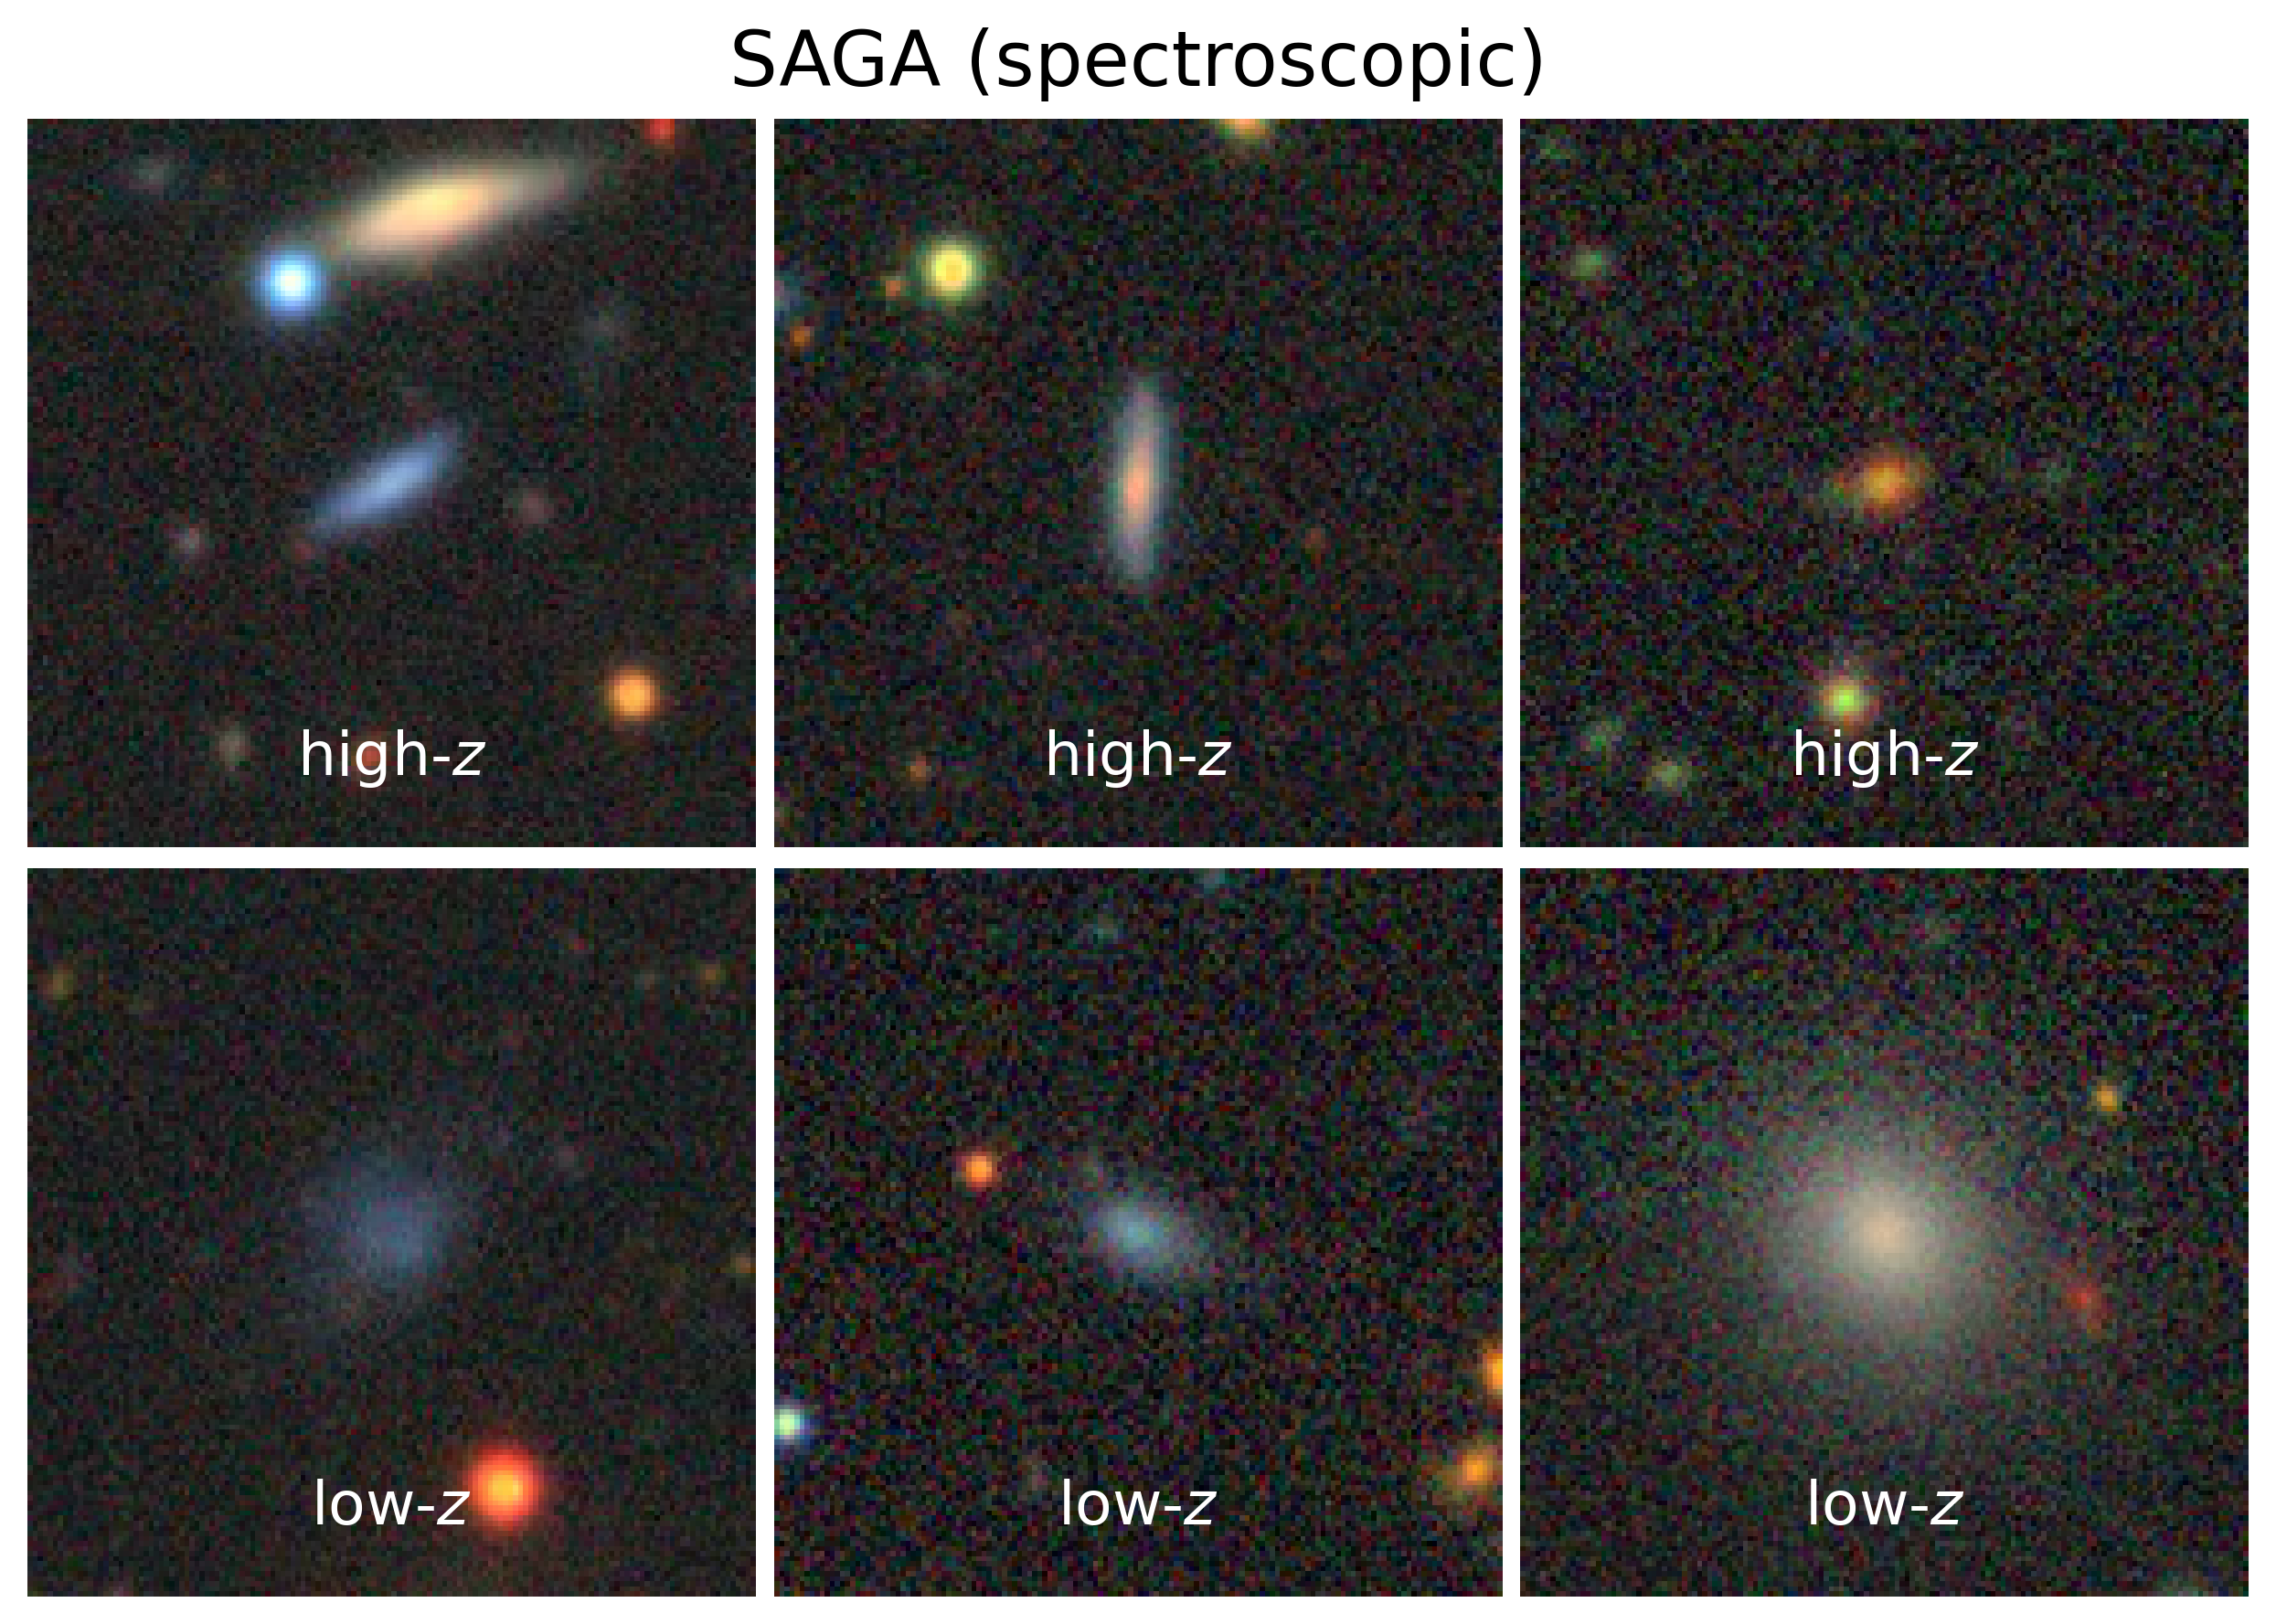

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=300)

# top row of figures
for ax, [objid, (ra, dec)] in zip(
        axes[0].flat,
        saga.loc[[901716660000005714, 903470840000004935, 902830140000001924]][['RA', 'DEC']].iterrows()
    ):
    ax.imshow(get_satellite_image(objid, ra, dec))
    ax.set_axis_off()
    
    ax.text(0.5, 0.1, r'high-$z$', ha='center', transform=ax.transAxes, color='white', fontsize=16)
    
# bottom row of figures
for ax, [objid, (ra, dec)] in zip(
        axes[1].flat,
        saga.loc[[901678900000005438, 903613300000002892, 903440480000002696]][['RA', 'DEC']].iterrows()
    ):
    ax.imshow(get_satellite_image(objid, ra, dec))
    ax.set_axis_off()
    
    ax.text(0.5, 0.1, r'low-$z$', ha='center', transform=ax.transAxes, color='white', fontsize=16)
        
fig.subplots_adjust(
    left=0.05,
    right=0.95,
    bottom=0.025,
    top=0.925,
    wspace=0.025, 
    hspace=0.025
)
fig.suptitle("SAGA (spectroscopic)", fontsize=20);

fig.savefig(figures_dir / "examples-saga.pdf")

## (Fig 1b) xSAGA examples

A few examples of CNN-identified low-$z$ and high-$z$ candidates.

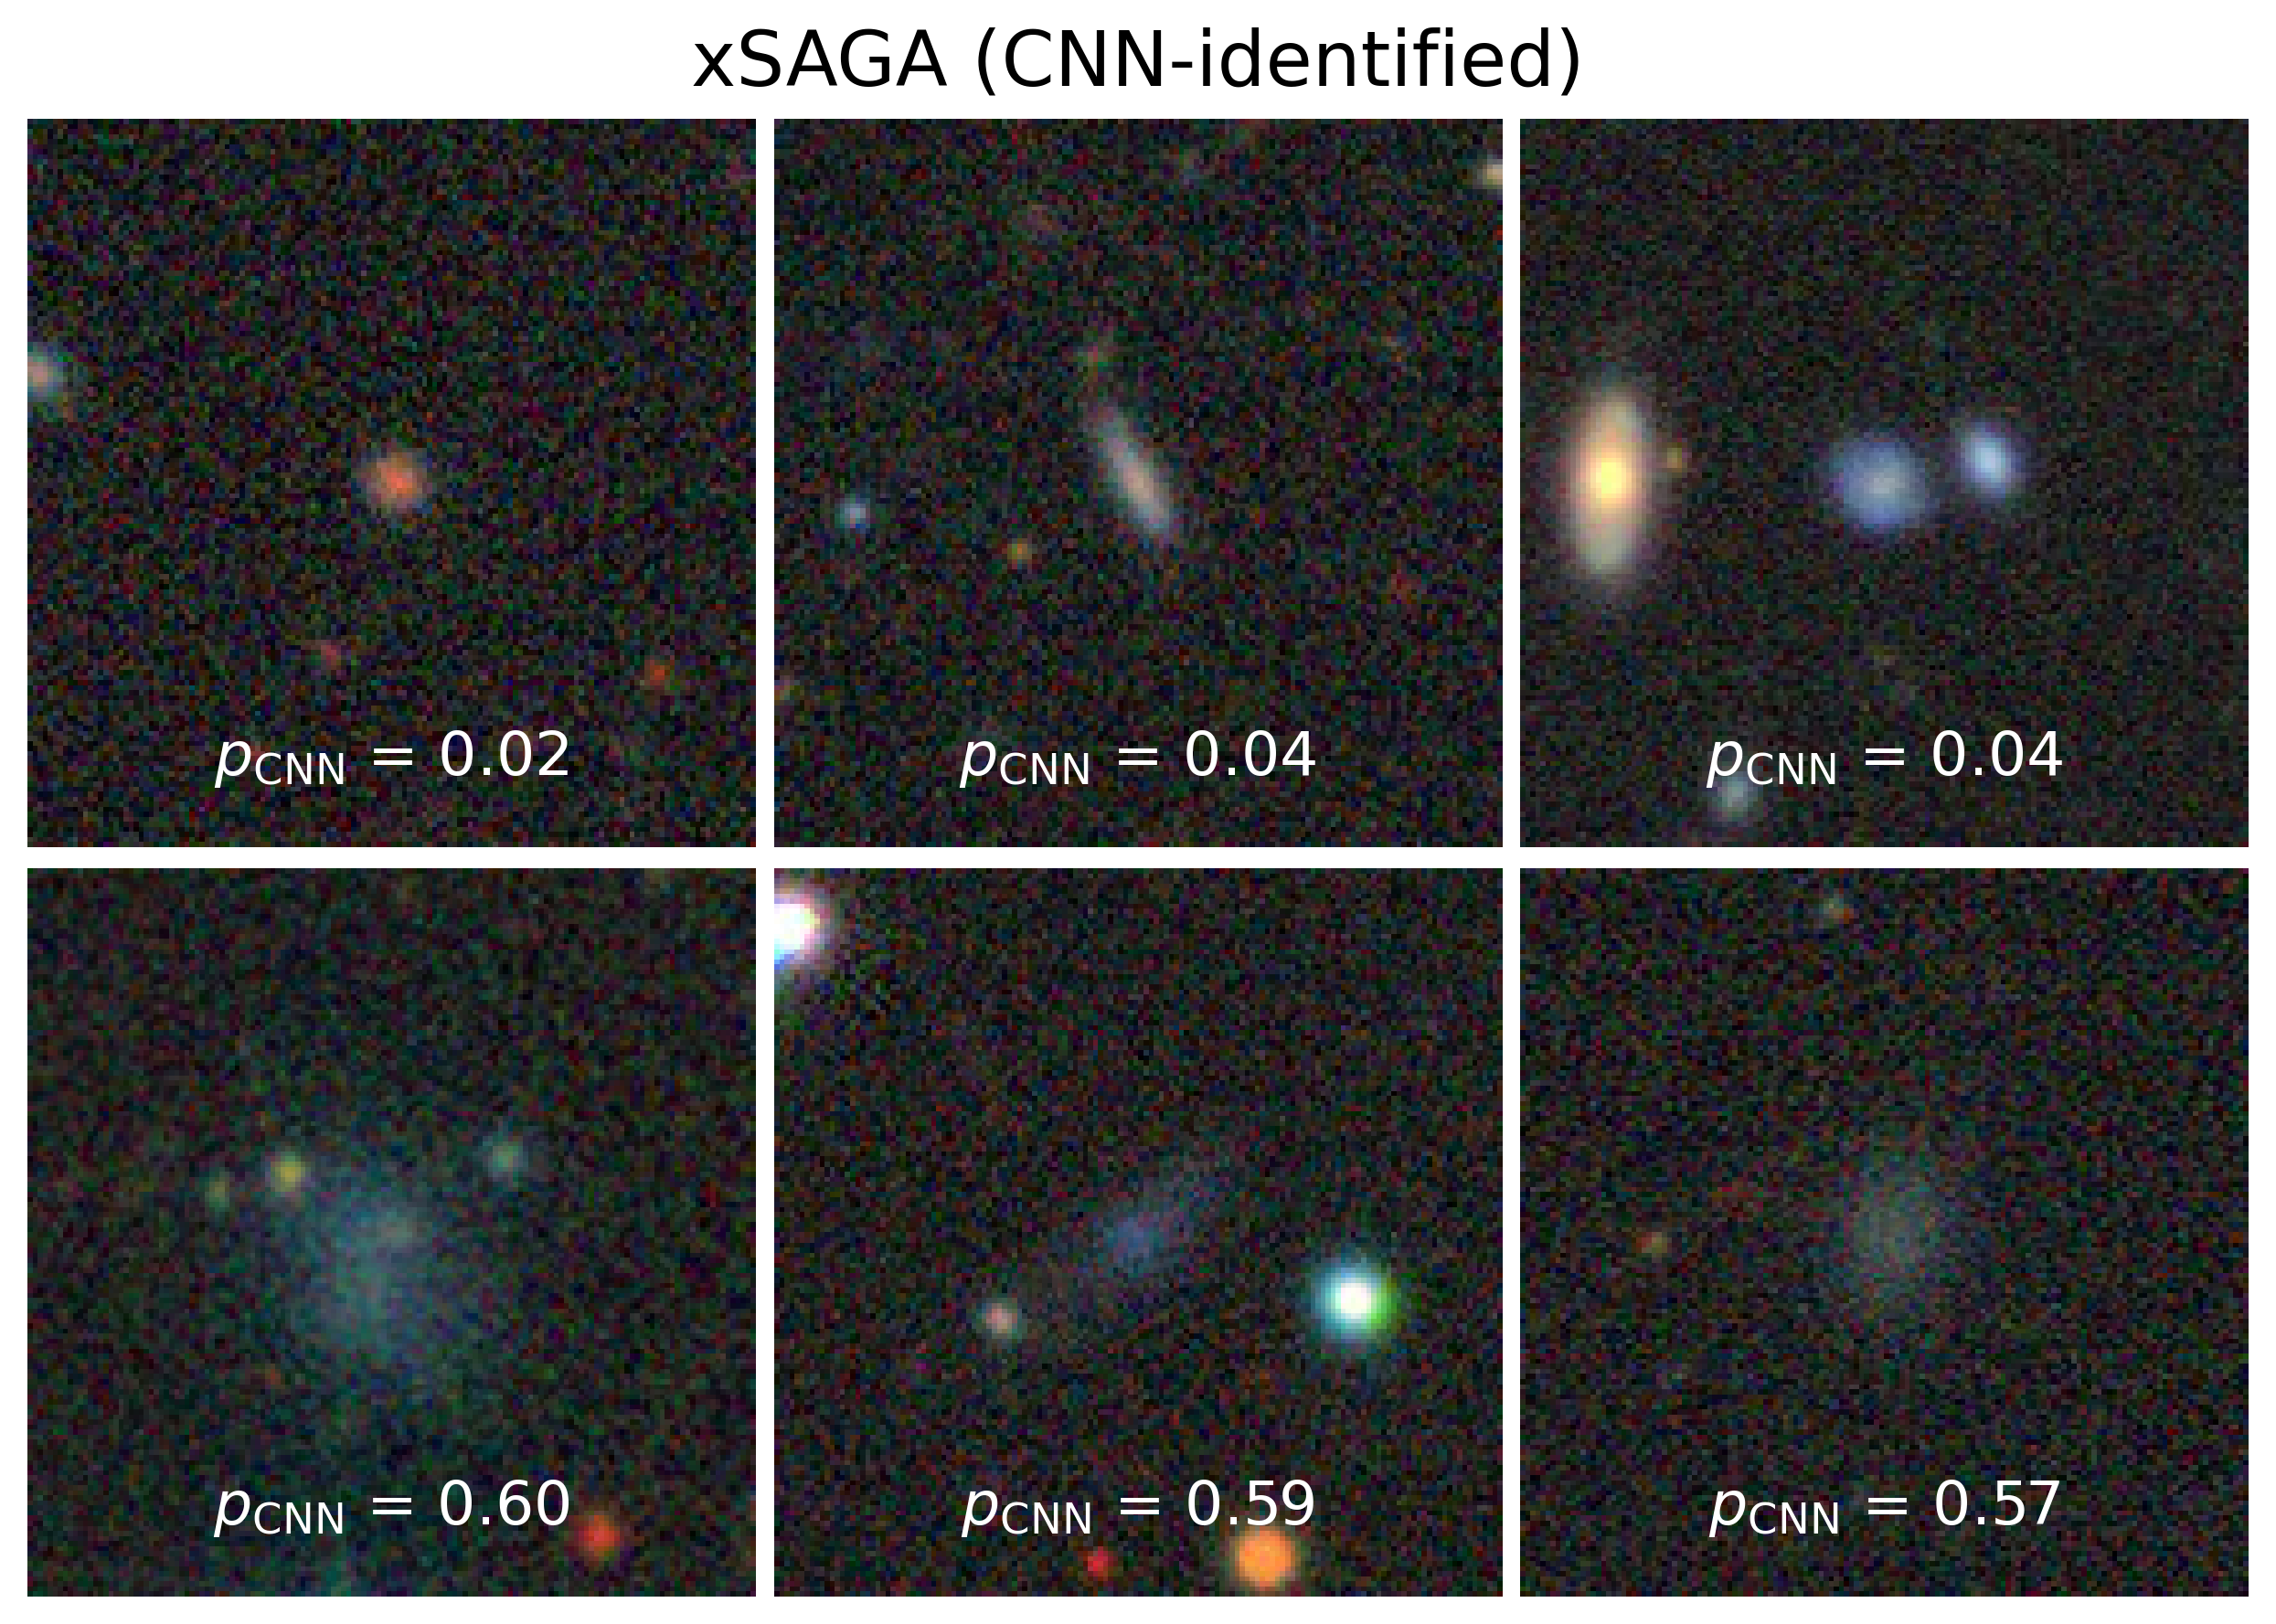

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=300)

# top row of figures
for ax, [objid, (ra, dec, p_CNN)] in zip(
        axes[0].flat,
        preds.loc[[1237667225546391759, 1237668315384709716, 1237674285925270037]][['ra', 'dec', 'p_CNN']].iterrows()
    ):
    ax.imshow(get_satellite_image(objid, ra, dec))
    ax.set_axis_off()
    
    ax.text(0.5, 0.1, r'$p_{\rm CNN}$' f' = {p_CNN:0.2f}', ha='center', transform=ax.transAxes, color='white', fontsize=16)
    
# bottom row of figures
for ax, [objid, (ra, dec, p_CNN)] in zip(
        axes[1].flat,
        xsaga.loc[[1237655107834151579, 1237667781733844044, 1237661949719019863]][['ra', 'dec', 'p_CNN']].iterrows()
    ):
    ax.imshow(get_satellite_image(objid, ra, dec))
    ax.set_axis_off()
    
    ax.text(0.5, 0.1, r'$p_{\rm CNN}$' f' = {p_CNN:0.2f}', ha='center', transform=ax.transAxes, color='white', fontsize=16)
      
fig.subplots_adjust(
    left=0.05,
    right=0.95,
    bottom=0.025,
    top=0.925,
    wspace=0.025, 
    hspace=0.025
)
fig.suptitle("xSAGA (CNN-identified)", fontsize=20);

fig.savefig(figures_dir / "examples-xsaga.pdf")

# CNN cross-validation

## (Fig 2) CNN ROC curve

The Receiving Operating Characteristic curve, used to show how a model trades off true positives and false positives. We'd like to maximize the area under the curve, or AUC.

In [10]:
from cnn_evaluation import *

cv = load_saga_crossvalidation()
cv["ranking"] = cv.p_CNN.rank(ascending=False)
cv["M_r"] = cv.r_mag - cosmo.distmod(z=cv.Z)

In [14]:
def plot_roc_curve(
    df,
    K=4,
    color="#003f5c",
    label="FL-hdxresnet34",
    fig=None,
    ax=None,
    figname="roc-curve.png",
):
    """Plot one or more ROC curves.
    """
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)

    for k in range(K):
        k = k + 1
        q = Query(f"kfold == {k}")

        fpr, tpr, thresholds = roc_curve(q.filter(df).low_z, q.filter(df).p_CNN)
        ax.plot(fpr, tpr, c=color, lw=1, alpha=0.5, zorder=1)

    # plot mean trend and mean scores
    score = roc_auc_score(df.low_z, df.p_CNN)
    fpr, tpr, thresholds = roc_curve(df.low_z, df.p_CNN)

    ax.plot(fpr, tpr, c=color, lw=3, zorder=5, label=f"{label}\n(AUC = {score:.3f})")

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    ax.grid(alpha=0.15)
    handles, labels = ax.get_legend_handles_labels()
    
    ax.legend(handles[::-1], labels[::-1], loc="lower right", fontsize=14)
    
    ax.plot([0, 1], [0, 1], ls="--", lw=1, c="k")

    return fig, ax

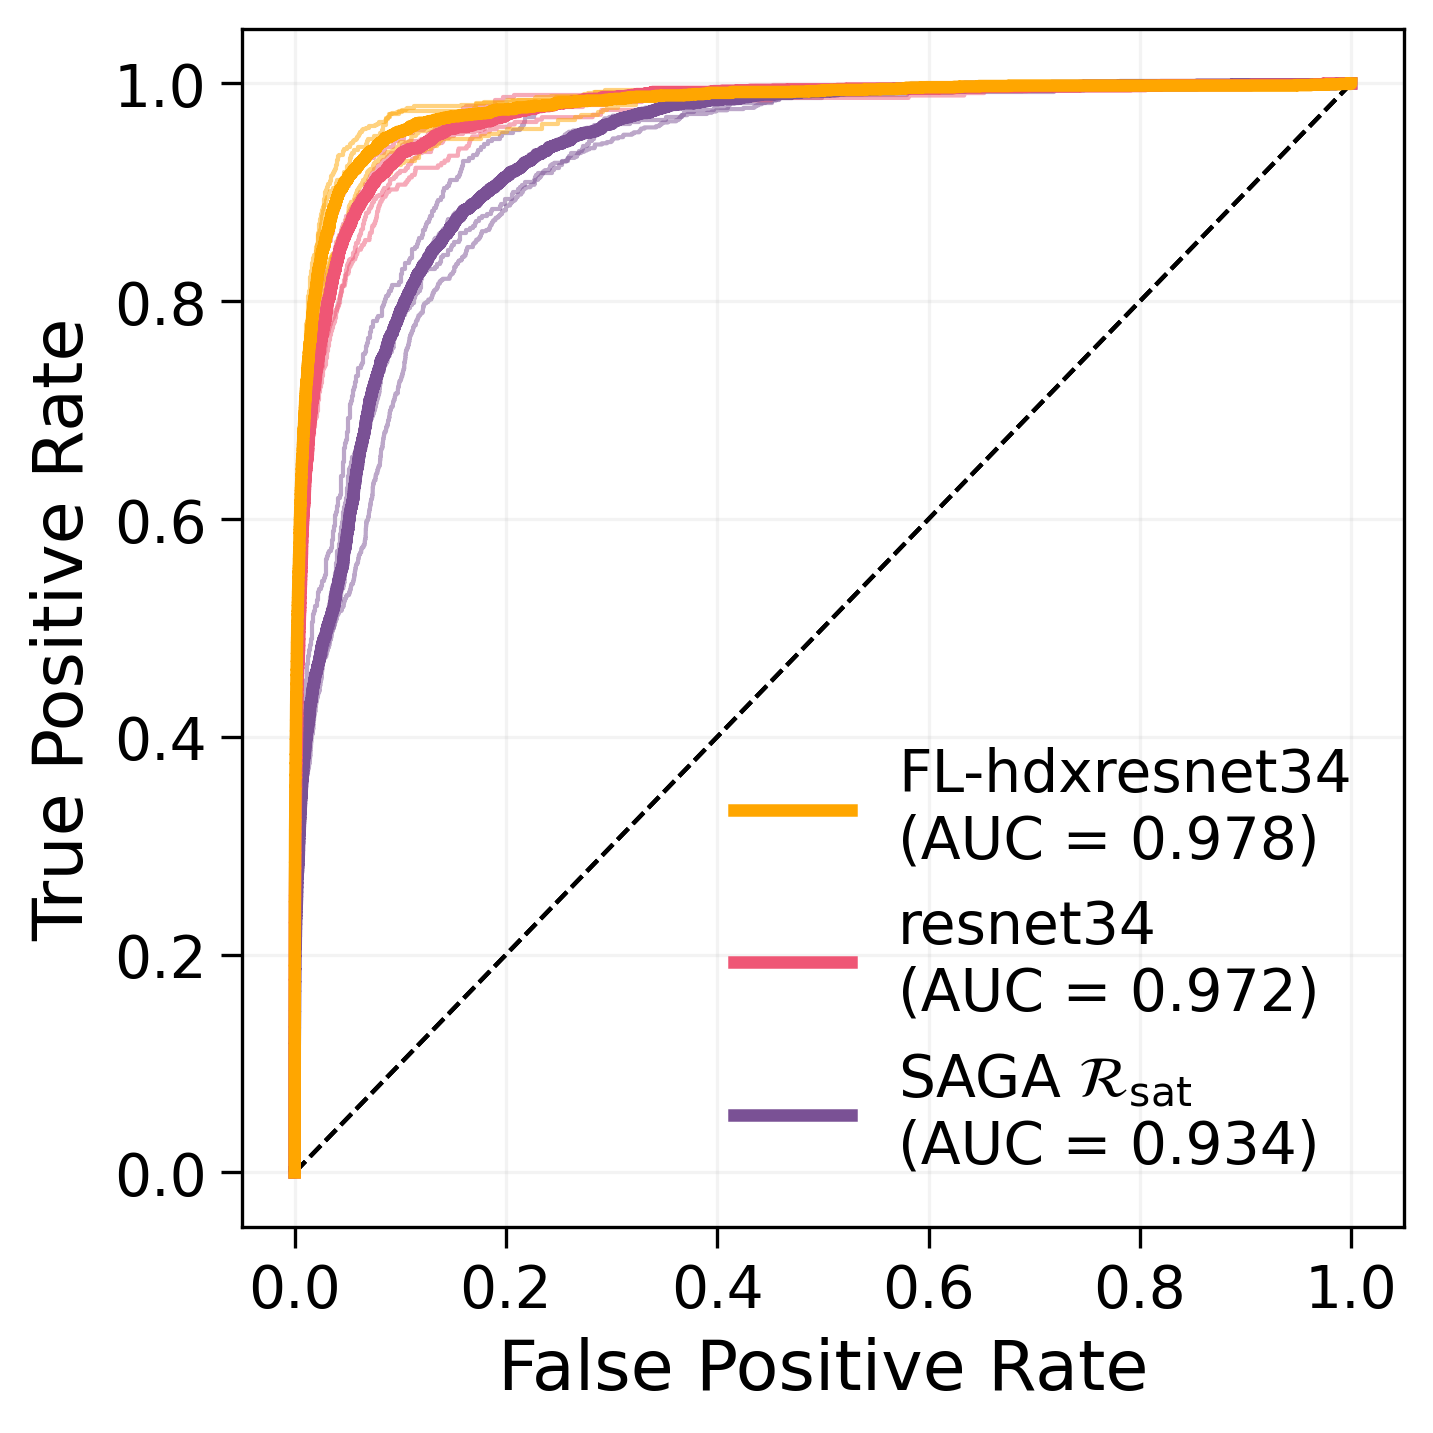

In [15]:
# start with p_sat from SAGA II
saga_psat = cv.copy()
saga_psat["p_CNN"] = saga_psat.p_sat_approx
fig, ax = plot_roc_curve(
    saga_psat, color="#7a5195", label=r"SAGA $\mathcal{R}_{\rm sat}$", figname=None
)

# get resnet cross-validation and add to ROC curve
saga_resnet_cv = load_saga_crossvalidation(
    catalogname="saga-validation_resnet34.csv"
)
fig, ax = plot_roc_curve(
    saga_resnet_cv, color="#ef5675", label="resnet34", fig=fig, ax=ax, figname=None
)

# finally include highly optimized CNN
plot_roc_curve(
    cv,
    color="#ffa600",
    label="FL-hdxresnet34",
    fig=fig,
    ax=ax,
    figname="roc-curve.png",
)

plt.tight_layout()

plt.savefig(figures_dir / "roc-curve.pdf")

## (Fig 3) CNN cross-validation purity and completeness 

The completeness, purity, and geometric mean of the two, for CNN predictions cross-validated from the SAGA survey. These metrics are plotted in bins of various galaxy photometric properties, such as $r$, $g-r$, $\mu_{r,\rm eff}$, and $M_r$.

In [16]:

def plot_comparison_by_X(
    df,
    X,
    X_min,
    X_max,
    delta_X,
    X_label,
    figname,
    z_thresh=0.03,
    p_cnn_thresh=0.5,
    N_boot=100,
    label="fraction",
    legend=True,
):
    """Compare metrics as a function of column X.

    If N_boot is an integer, then it will bootstrap resample each metric `N_boot` times.

    The param `label` can be either "count" or "fraction", depending on whether the
    total number or fraction of low-z galaxies should be labeled at the top of the
    figure.
    """

    q_true = Query(f"Z < {z_thresh}")
    q_pred = Query(f"p_CNN > {p_cnn_thresh}")

    X_bins = np.arange(X_min, X_max, delta_X)
    X_queries = [
        Query(f"{X} >= {x1}", f"{X} < {x2}") for x1, x2 in zip(X_bins, X_bins + delta_X)
    ]

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)

    # get the True/False mask for labels and predictions for each q (magnitude bin)
    def completeness_score_bootfunc(x):
        return recall_score(q_true.mask(x), q_pred.mask(x))

    def purity_score_bootfunc(x):
        return precision_score(q_true.mask(x), q_pred.mask(x))

    boot_completeness = np.array(
        [
            [
                completeness_score_bootfunc(q.filter(df).sample(frac=1, replace=True))
                for _ in range(N_boot)
            ]
            for q in X_queries
        ]
    )

    boot_purity = np.array(
        [
            [
                purity_score_bootfunc(q.filter(df).sample(frac=1, replace=True))
                for _ in range(N_boot)
            ]
            for q in X_queries
        ]
    )

    boot_geometric_mean = np.sqrt(boot_completeness * boot_purity)

    ax.plot(
        X_bins + delta_X / 2,
        boot_completeness.mean(1),
        c="#ff6361",
        lw=2,
        label="Completeness",
        zorder=1,
    )
    ax.fill_between(
        X_bins + delta_X / 2,
        *np.quantile(boot_completeness, [0.16, 0.84], axis=1),
        color="#ff6361",
        lw=0,
        zorder=1,
        alpha=0.3,
    )

    ax.plot(
        X_bins + delta_X / 2,
        boot_purity.mean(1),
        c="#ffa600",
        lw=2,
        label="Purity",
        zorder=2,
    )
    ax.fill_between(
        X_bins + delta_X / 2,
        *np.quantile(boot_purity, [0.16, 0.84], axis=1),
        color="#ffa600",
        lw=0,
        zorder=2,
        alpha=0.3,
    )

    ax.plot(
        X_bins + delta_X / 2,
        boot_geometric_mean.mean(1),
        c="#003f5c",
        lw=2,
        label="Geometric mean",
        zorder=3,
    )
    ax.fill_between(
        X_bins + delta_X / 2,
        *np.quantile(boot_geometric_mean, [0.16, 0.84], axis=1),
        color="#003f5c",
        lw=0,
        zorder=3,
        alpha=0.3,
    )
    if label == "fraction":
        fracs = np.array([q_true.count(q.filter(df)) / q.count(df) for q in X_queries])
        for x, l in zip(X_bins + delta_X / 2, fracs):
            ax.text(x, 1.08, f"{l:.3f}", rotation=60, fontsize=8, color="k")
    elif label == "count":
        counts = np.array([q_true.count(q.filter(df)) for q in X_queries])
        for x, l in zip(X_bins + delta_X / 2, counts):
            ax.text(x, 1.08, l, rotation=60, fontsize=8, color="k")
    else:
        raise ValueError("Please specify a valid `label`.")

    ax.set_xlabel(X_label, fontsize=12)
    ax.set_ylim(-0.06, 1.06)
    # ax.set_ylabel("Evaluation metric", fontsize=14)
    ax.tick_params(which="both", labelsize=12)

    ax.grid(alpha=0.15)
    if legend:
        ax.legend(
            framealpha=1,
            loc="lower left" if X not in ("sb_r", "DEC") else "lower right",
            fontsize=12,
        )

    fig.tight_layout()

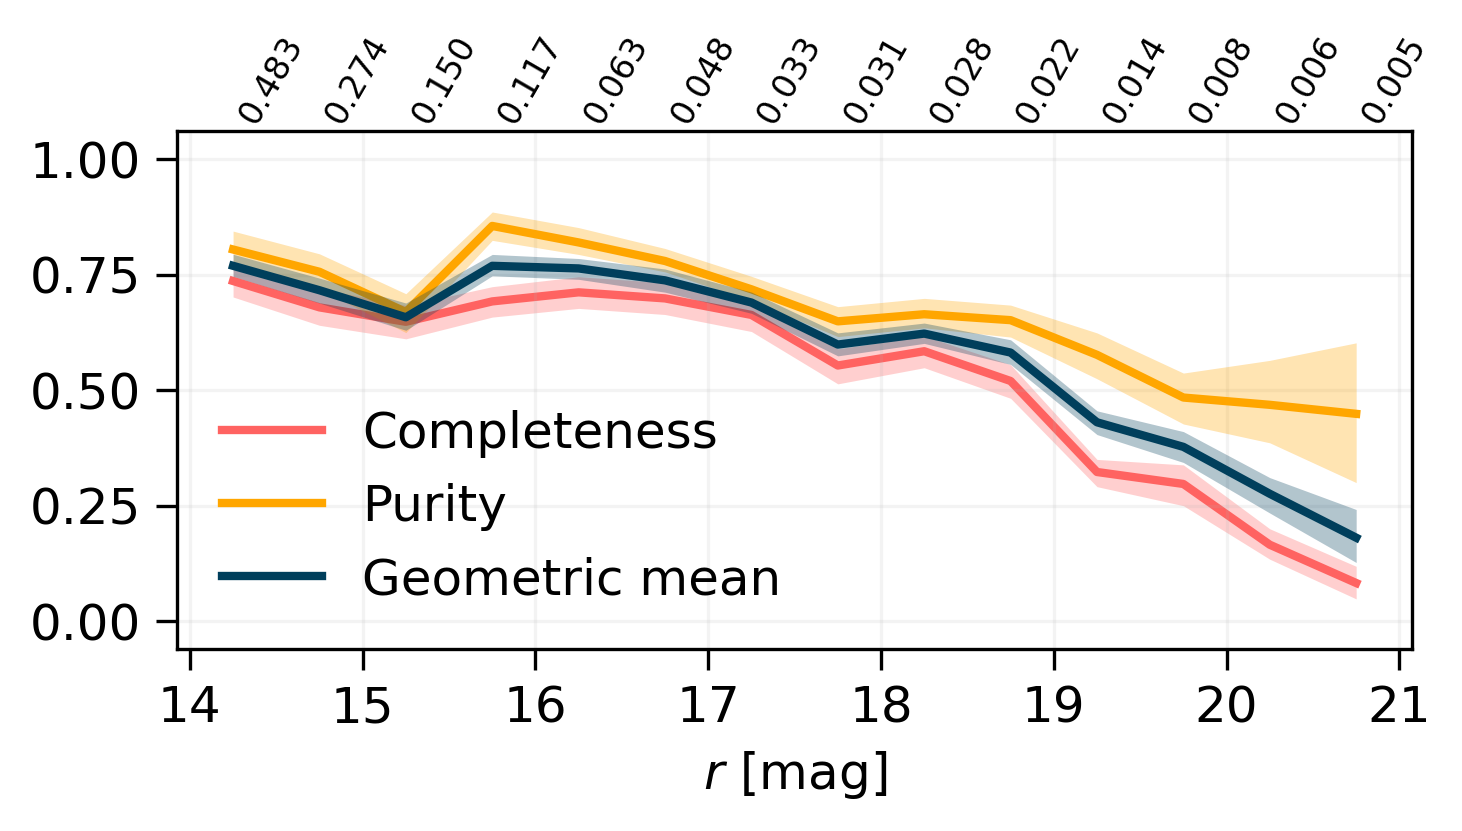

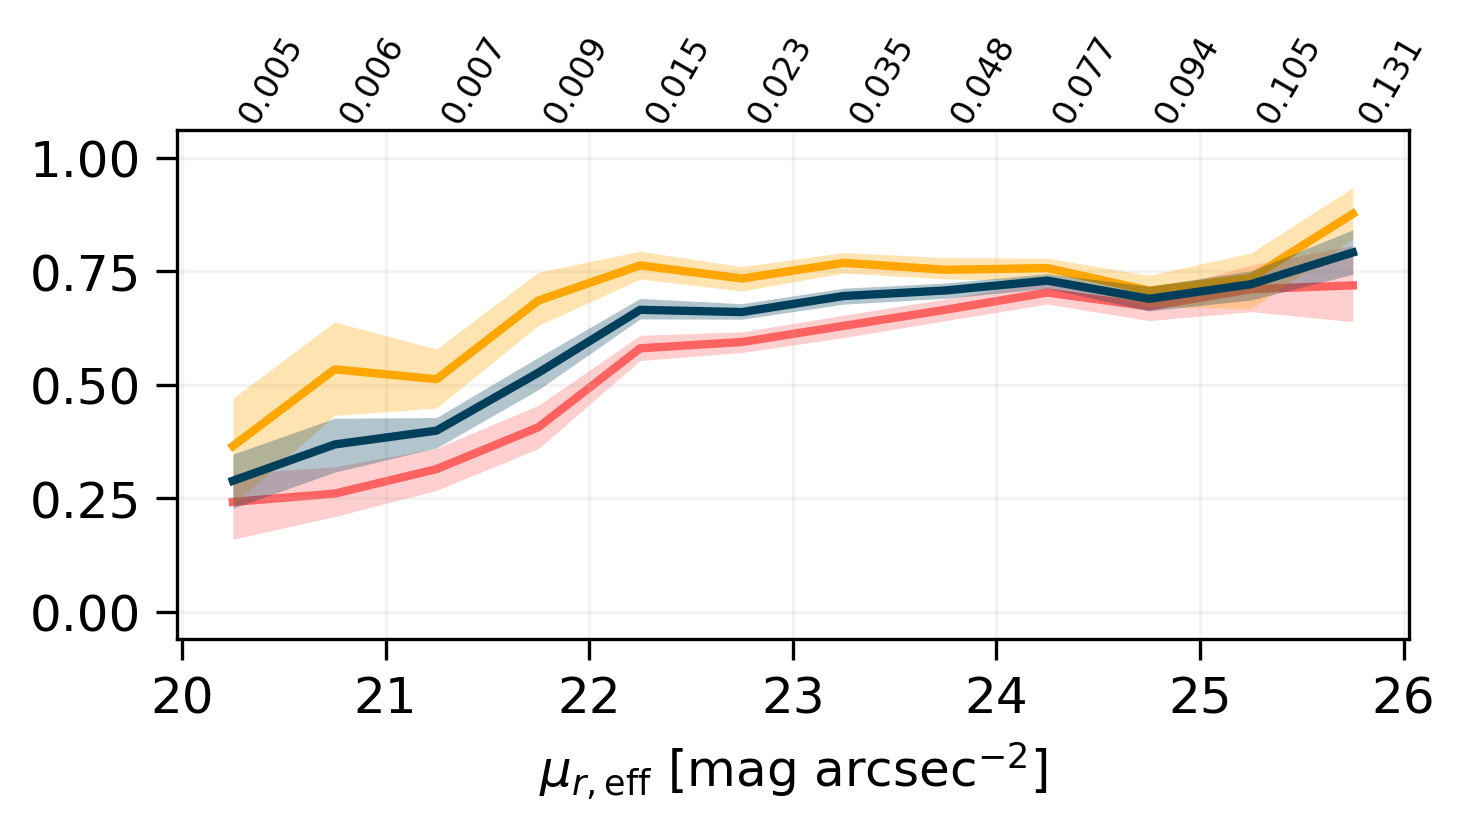

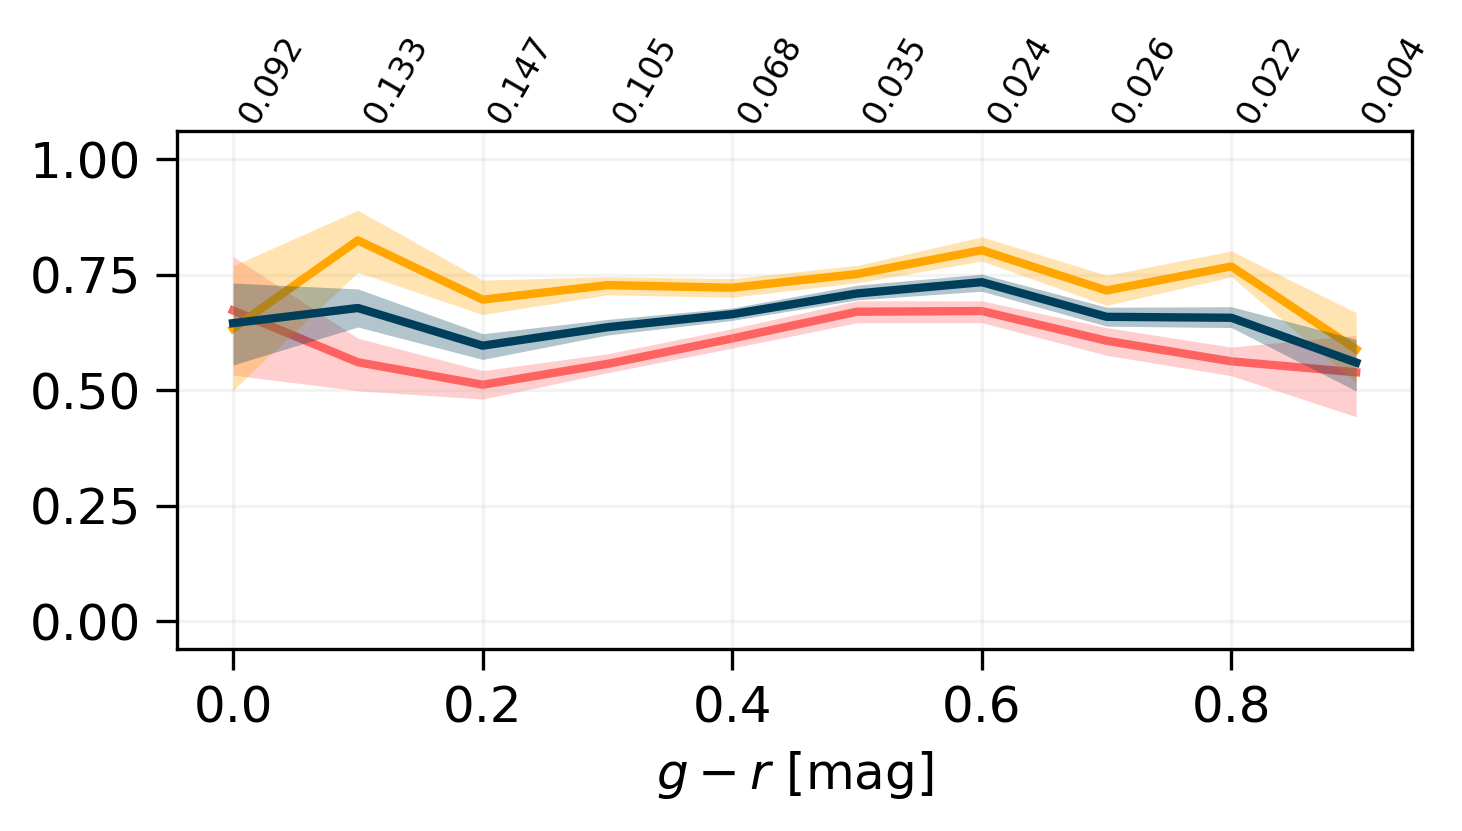

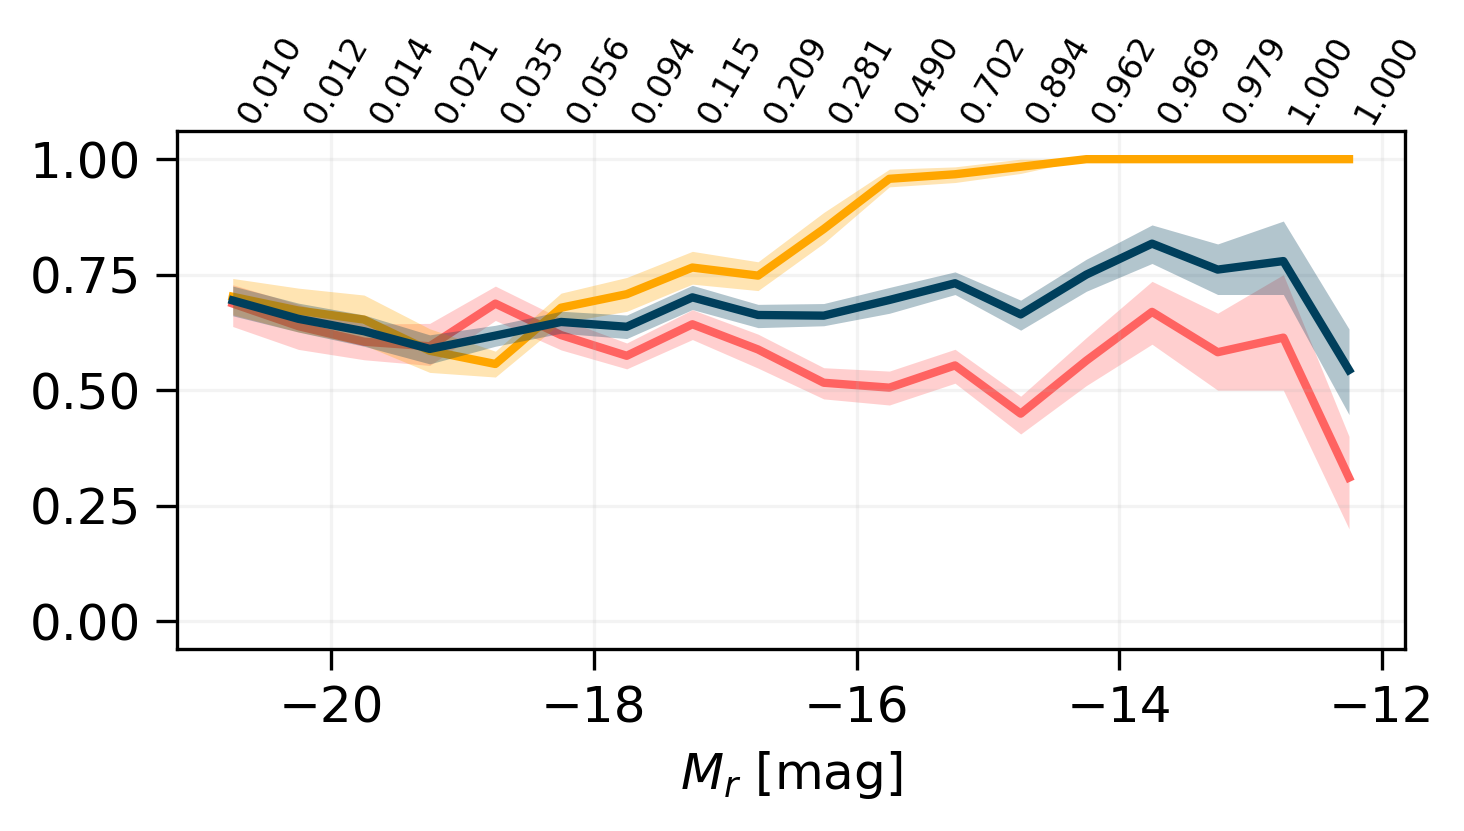

In [17]:
plot_comparison_by_X(
    cv,
    X="r_mag",
    X_min=14,
    X_max=21,
    delta_X=0.5,
    X_label=r"$r$ [mag]",
    figname="magnitude-comparison.png",
)
plt.savefig(figures_dir / "magnitude-comparison.pdf")

plot_comparison_by_X(
    cv,
    X="sb_r",
    X_min=20,
    X_max=26,
    delta_X=0.5,
    legend=False,
    X_label=r"$\mu_{r,\rm eff}$ [mag arcsec$^{-2}$]",
    figname="surface_brightness-comparison.png",
)
plt.savefig(figures_dir / "surface_brightness-comparison.pdf")


plot_comparison_by_X(
    cv,
    X="gr",
    X_min=-0.05,
    X_max=0.9,
    delta_X=0.1,
    legend=False,
    X_label=r"$g-r$ [mag]",
    figname="gmr-comparison.png",
)
plt.savefig(figures_dir / "gmr-comparison.pdf")


plot_comparison_by_X(
    cv,
    X="M_r",
    X_min=-21,
    X_max=-12,
    delta_X=0.5,
    legend=False,
    X_label=r"$M_{r}$ [mag]",
    figname="M_r-comparison.png",
)
plt.savefig(figures_dir / "M_r-comparison.pdf")


## (Fig 14 --- A.1) Model for purity, completeness, and low-$z$ rate 

In [27]:
from uncertainties import *

In [28]:
best_fit_params = fit_logistic_model(cv)

In [29]:
def plot_purity_completeness_radial_trends(
    cv, saga_sats, saga_hosts, params, figname="purity_completeness_radial_trends"
):
    """Given the cross-validated data, SAGA satellite and host catalogs,
    and best-fit model parameters from above, plots the radial and magnitude dependence
    for candidates colored by the photometric model predictions for low-z rate,
    purity, and completeness.
    """
    cv_coords = SkyCoord(cv.RA, cv.DEC, unit="deg")
    s2_coords = SkyCoord(saga_sats.RA, saga_sats.DEC, unit="deg")

    idx, sep, _ = s2_coords.match_to_catalog_sky(cv_coords)

    df = pd.concat(
        [
            saga_sats.reset_index(),
            cv.iloc[idx][["Z", "low_z", "p_CNN", "r_mag", "sb_r", "gr"]].reset_index(),
        ],
        axis=1,
    )
    df = df[sep < 10 * u.arcsec].copy()

    predictions = dict()

    for hostname, host in saga_hosts.set_index("INTERNAL_HOSTID", drop=True).iterrows():
        host_coord = SkyCoord(host.RA, host.DEC, unit="deg")
        sep = host_coord.separation(cv_coords)
        max_angsep = ((0.3 / host.DIST) * u.rad).to(u.arcsec)
        sub_cv = cv[sep < max_angsep].copy()
        sub_cv["D_PROJ"] = sep[sep < max_angsep].to(u.rad).value * host.DIST * 1e3
        predictions[hostname] = sub_cv

    pred_df = pd.concat(predictions)

    # include scaled photometric quantities and compute model predictions
    pred_df["r_mag_scaled"] = (pred_df.r_mag - 19.30038351) / 1.63920353
    pred_df["sb_r_scaled"] = (pred_df.sb_r - 22.23829513) / 1.60764197

    pred_df["gr_scaled"] = (pred_df.gr - 0.97987122) / 1.16822956

    pred_df["p_model_rate"] = lowz_rate_model(
        params["rate"], pred_df.r_mag_scaled, pred_df.sb_r_scaled, pred_df.gr_scaled
    )

    pred_df["p_model_completeness"] = lowz_rate_model(
        params["completeness"],
        pred_df.r_mag_scaled,
        pred_df.sb_r_scaled,
        pred_df.gr_scaled,
    )

    pred_df["p_model_purity"] = lowz_rate_model(
        params["purity"], pred_df.r_mag_scaled, pred_df.sb_r_scaled, pred_df.gr_scaled
    )

    # make plots
    fig, axes = plt.subplots(
        3, 1, sharex=True, constrained_layout=True, figsize=(10, 8), dpi=300
    )

    is_lowz = Query("low_z == True")
    cnn_selected = Query("p_CNN > 0.5")

    TP = (is_lowz & cnn_selected).filter(pred_df)
    FP = (~is_lowz & cnn_selected).filter(pred_df)
    FN = (is_lowz & ~cnn_selected).filter(pred_df)

    for ax, metric, (df1, df2) in zip(
        axes.flat, ["rate", "completeness", "purity"], [(TP, FP), (TP, FN), (TP, FP)]
    ):

        ax.scatter(
            df2.D_PROJ,
            df2.r_mag,
            c=df2[f"p_model_{metric}"],
            marker="x",
            edgecolor="none",
            s=30,
            vmin=0,
            vmax=1,
            cmap="viridis_r",
        )

        sc = ax.scatter(
            df1.D_PROJ,
            df1.r_mag,
            c=df1[f"p_model_{metric}"],
            vmin=0,
            vmax=1,
            s=30,
            cmap="viridis_r",
            edgecolor="k",
            marker="o",
        )

        ax.set_xlim(15, 300)
        ax.set_ylim(12, 22)
        ax.set_ylabel("$r$ [mag]")
        ax.grid(alpha=0.15)

        ax.text(18, 20.7, f"Modeled {metric}", fontsize=16)
    axes.flat[-1].set_xlabel("$r$ [projected kpc]")

    fig.colorbar(sc, ax=axes.flat, aspect=50, pad=-0.01)

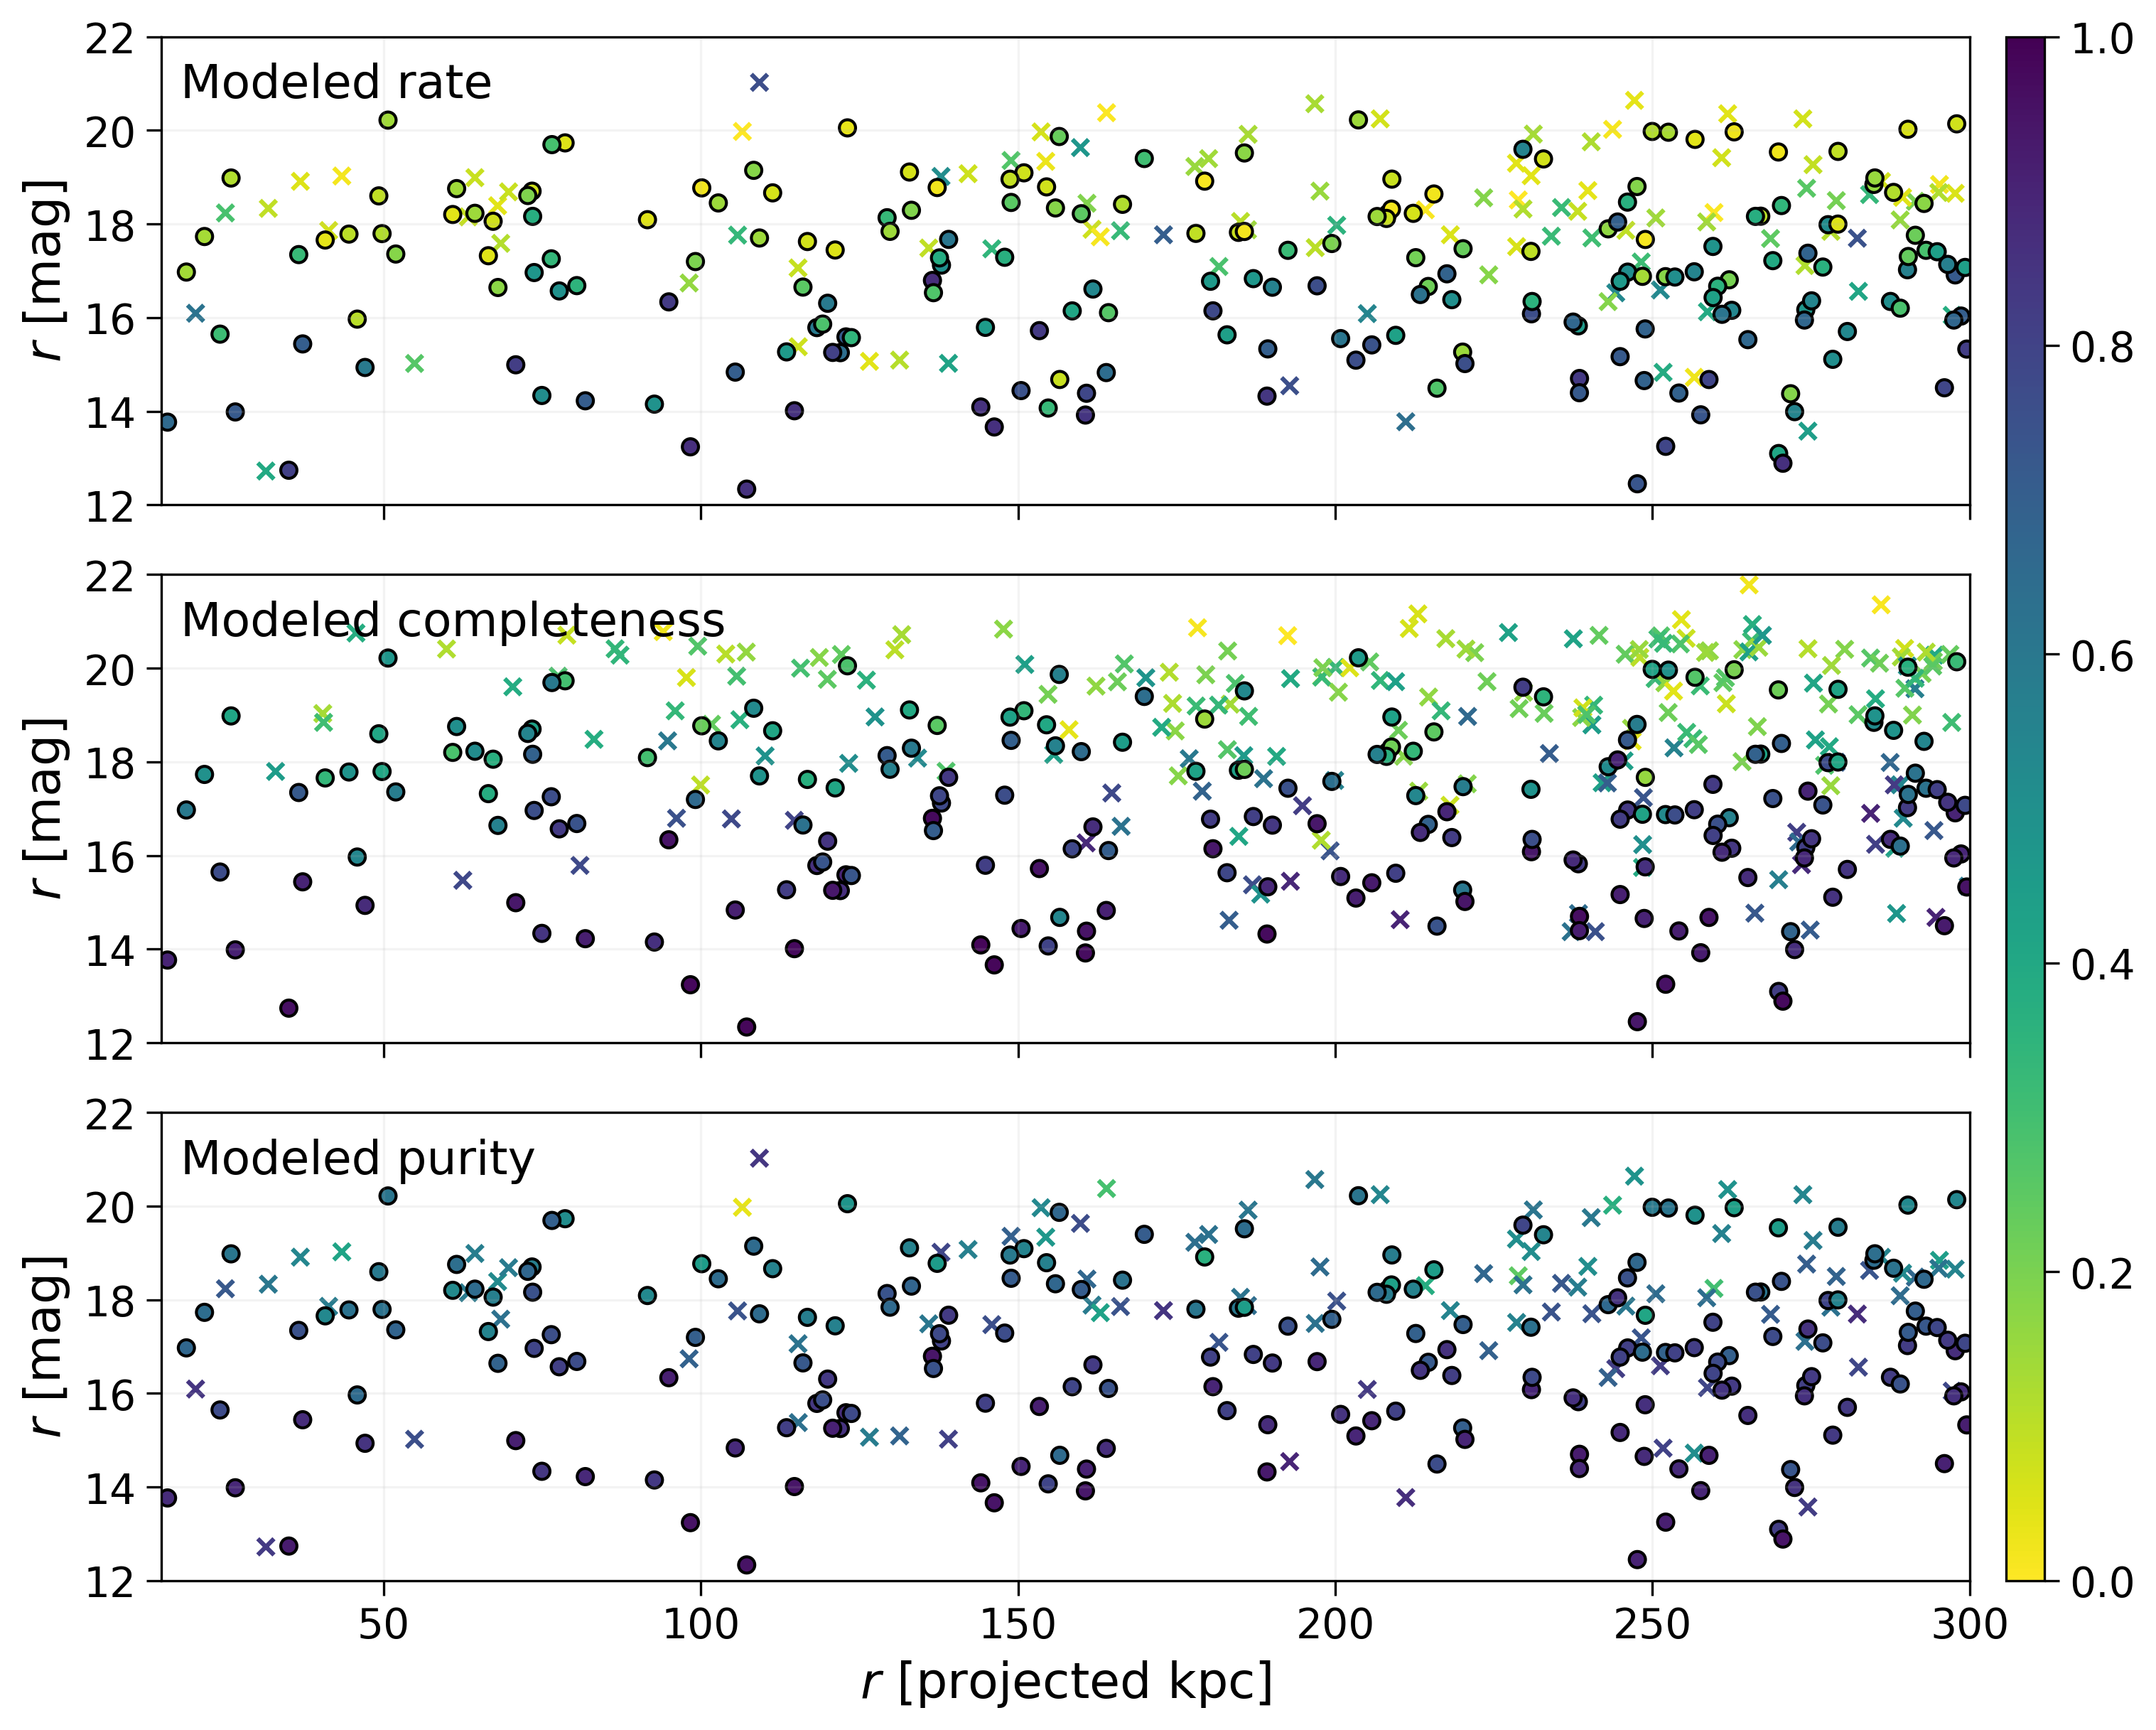

In [14]:
plot_purity_completeness_radial_trends(cv, saga2_sats, saga2_hosts, best_fit_params)
plt.savefig(figures_dir / "purity_completeness_radial_trends.pdf")


## (Fig 15 --- A.2) Fitting modeled purity and completeness trends

In [63]:
def plot_model_fit_statistic(cv, params, statistic, figname="model_fit_lowz-stat.png"):
    """Given data, fit parameters, and some desired statistic (`rate`, `purity`,
    `completeness`, makes a plot)
    """

    # scale photometric parameters and corresponding bins
    X = np.array([cv.r_mag, cv.sb_r, cv.gr]).T
    X_scaled = (X - X.mean(0)) / X.std(0)
    y_true = cv.low_z
    y_pred = cv.p_CNN > 0.5

    bins_scaled = [
        (r0_range - X.mean(0)[0]) / X.std(0)[0],
        (sb_range - X.mean(0)[1]) / X.std(0)[1],
        (gmr_range - X.mean(0)[2]) / X.std(0)[2],
    ]

    # prepare plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300, sharey=True)

    if statistic == "rate":
        X_ = X_scaled
        y_ = y_true
        color = "#58508d"
        label = "SAGA"
    elif statistic == "completeness":
        X_ = X_scaled[y_true]
        y_ = y_pred[y_true]
        color = "#ff6361"
        label = "CNN"
    elif statistic == "purity":
        X_ = X_scaled[y_pred]
        y_ = y_true[y_pred]
        color = "#ffa600"
        label = "CNN"
    else:
        raise ValueError("Statistic must be one of 'purity', 'completeness', or 'rate'")

    binned_statistic_result = binned_statistic_dd(X_, y_, bins=bins_scaled)
    lowz_rate = binned_statistic_result.statistic

    model_preds = lowz_rate_model(params, *X_.T)
    binned_statistic_result = binned_statistic_dd(X_, model_preds, bins=bins_scaled)
    model_rate = binned_statistic_result.statistic

    xbins = [r0_bins, sb_bins, gmr_bins]
    xlabels = [
        r"$r$ [mag]",
        r"$\mu_{r, \rm eff}$ [mag arcsec$^{-2}$]",
        r"$g-r$ [mag]",
    ]

    for i, (ax, xbins, xlabel) in enumerate(zip(axes.flat, xbins, xlabels)):
        axis = tuple(j for j in [0, 1, 2] if j != i)

        p_data = np.nanmean(lowz_rate, axis=axis)
        p_model = np.nanmean(model_rate, axis=axis)
        N = np.isfinite(model_rate).sum(axis=axis)

        def _wald_interval(p, N):
            return 2 * [np.sqrt(p * (1 - p) / N)]

        yerr = _wald_interval(p_data, N)
        width = 0.95 * (xbins[1] - xbins[0])

        ax.bar(xbins, p_data, width=width, alpha=0.5, color=color, label=label)
        ax.errorbar(xbins, p_data, yerr=yerr, ls="none", color=color)
        ax.plot(xbins, p_model, c="k", label="Model")

        ax.set_ylim(1e-2, 1)
        ax.set_yscale("log")
        ax.set_xlabel(xlabel)
        ax.grid(color="white", lw=0.5, alpha=0.5)

    axes.flat[0].set_ylabel(f"Low-$z$ {statistic}")
    axes.flat[0].legend(fontsize=16, loc='lower left')
    fig.tight_layout()


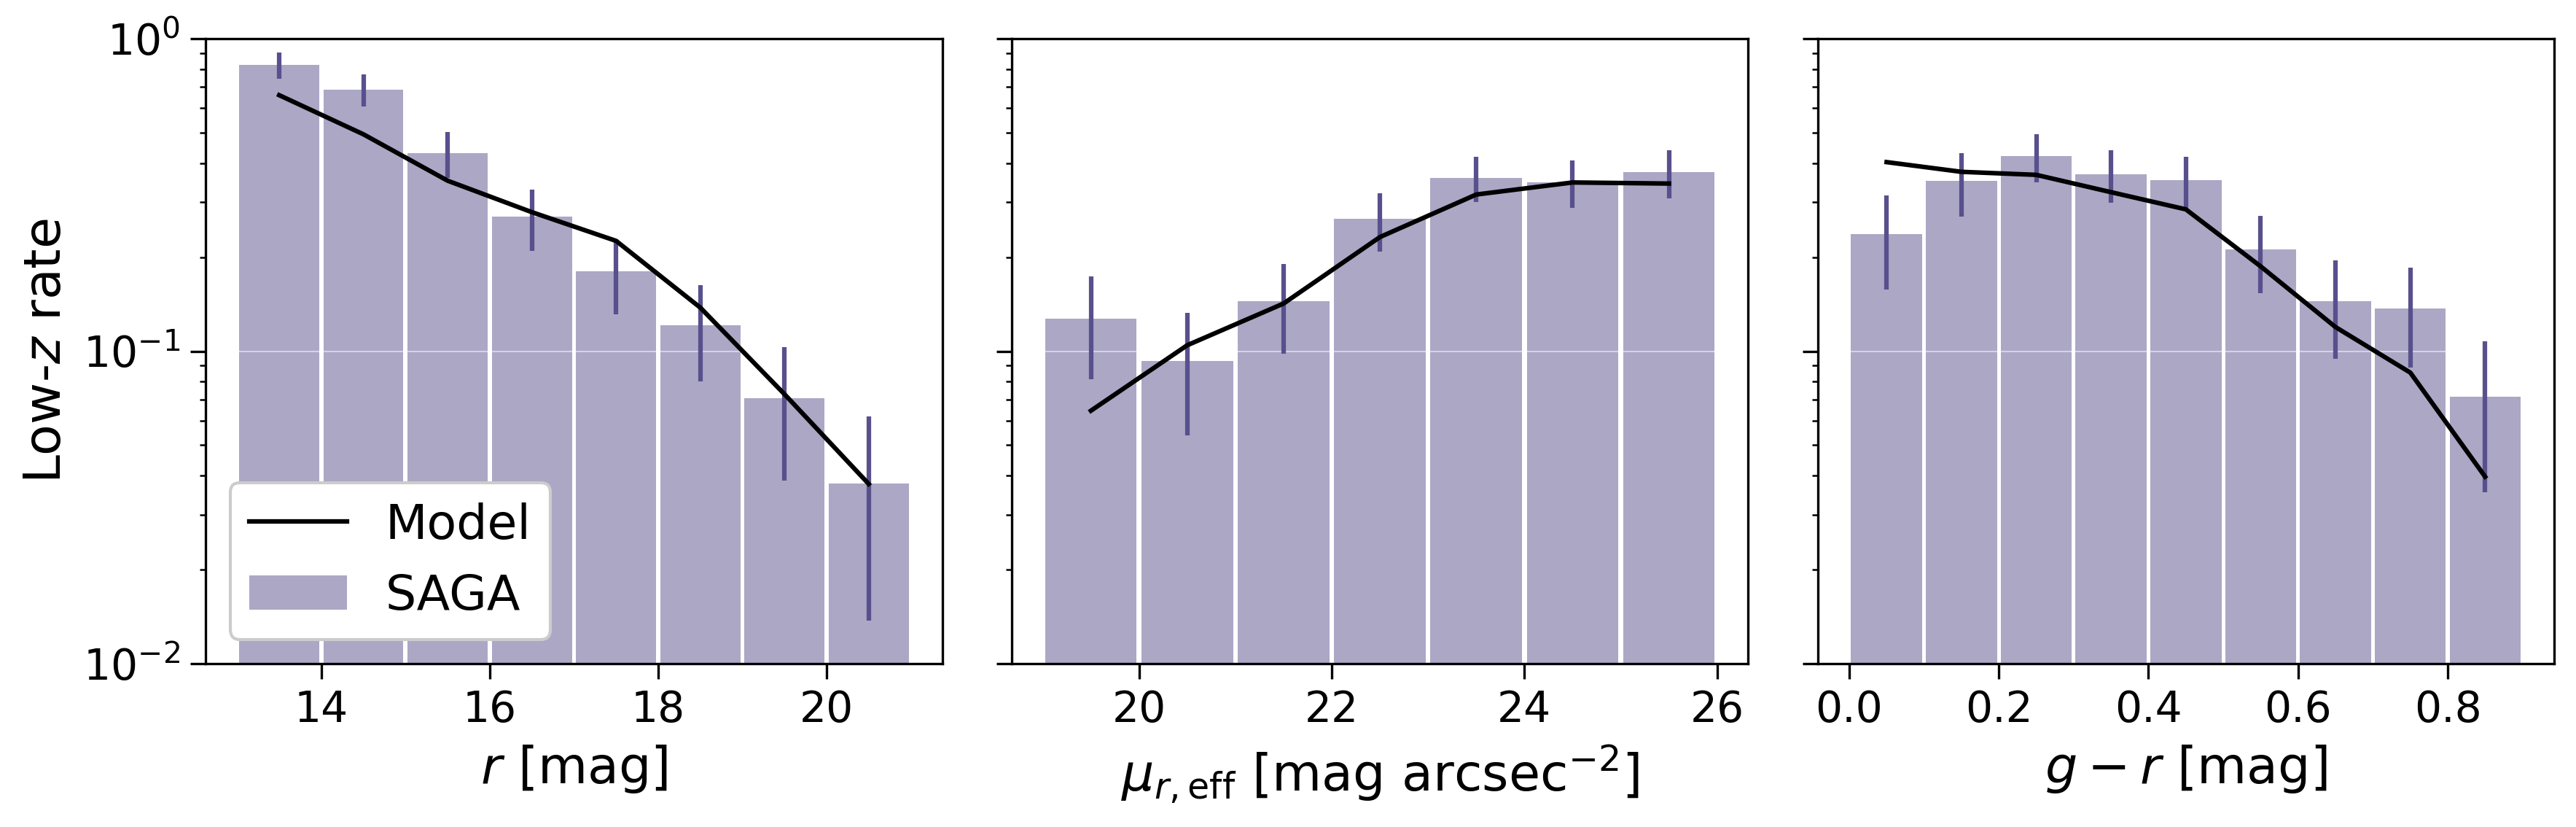

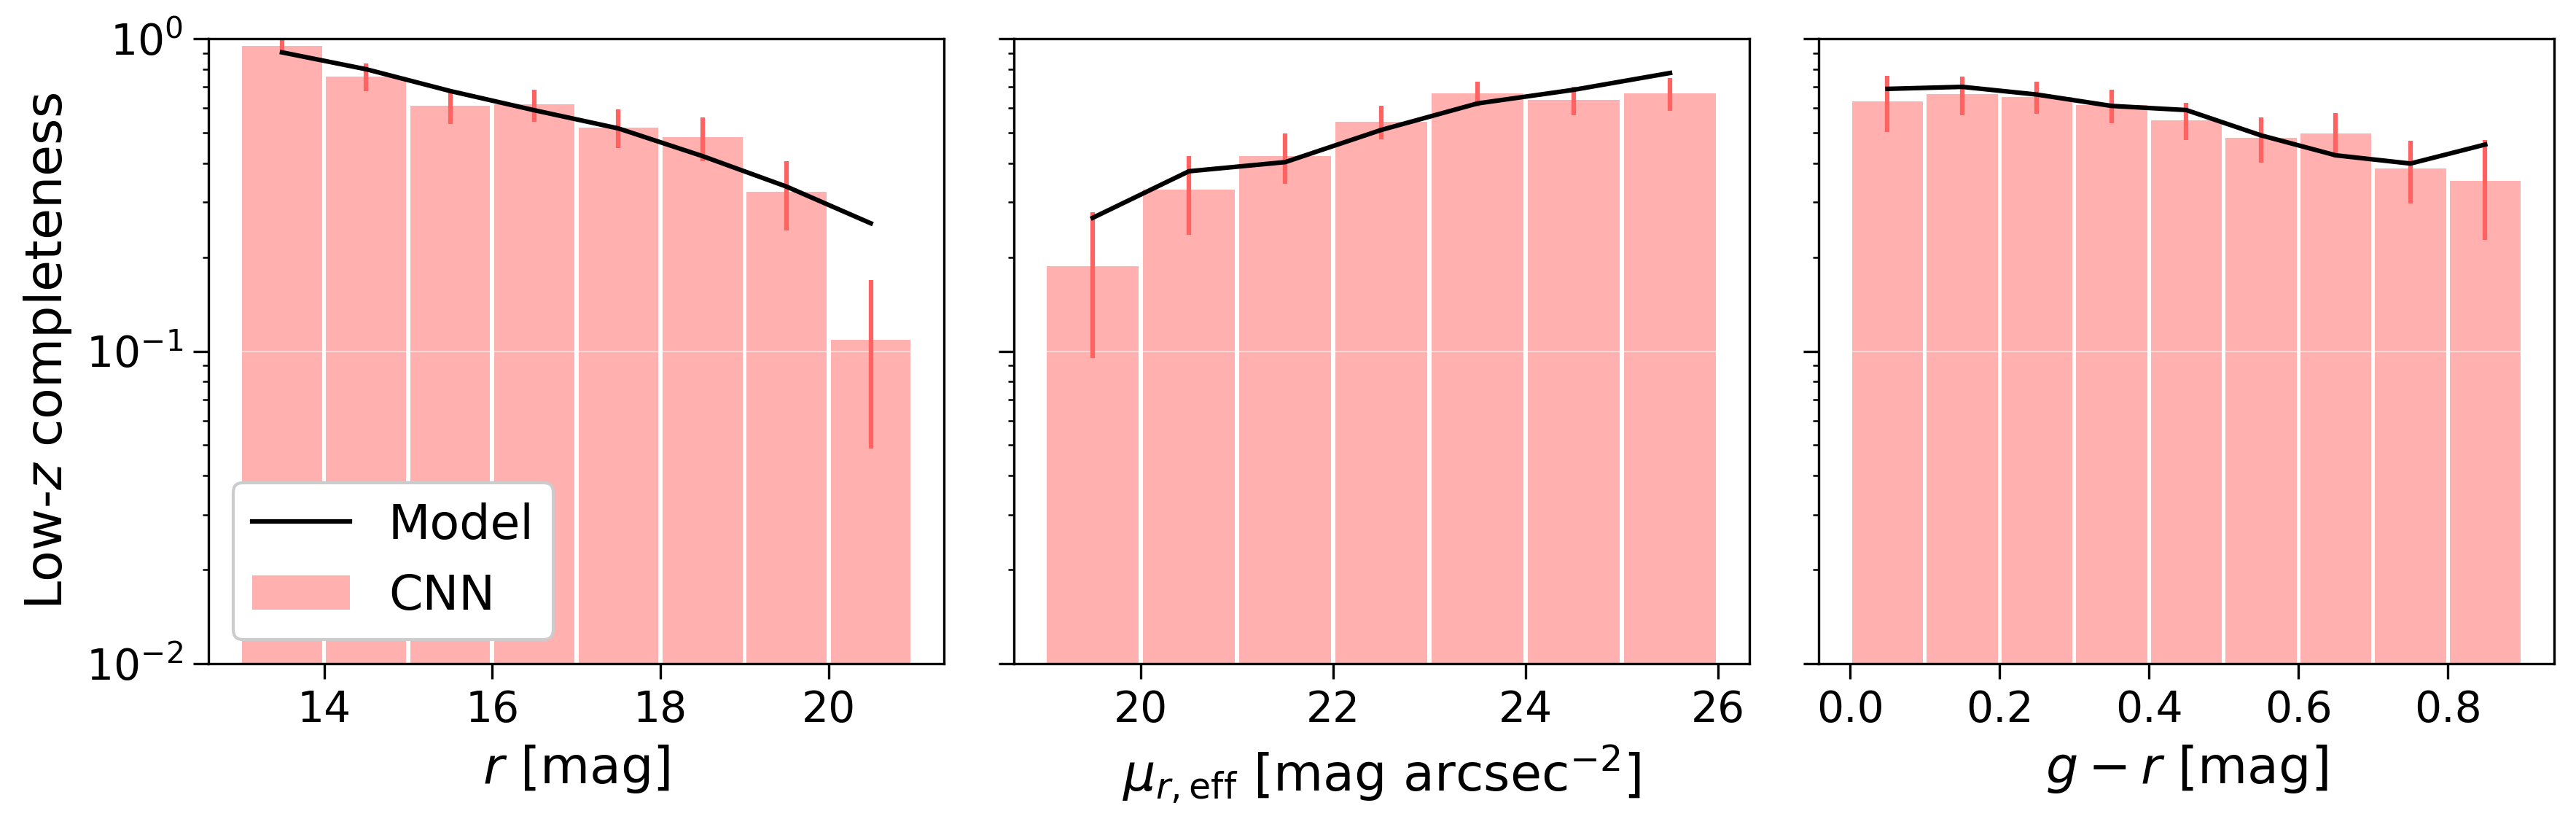

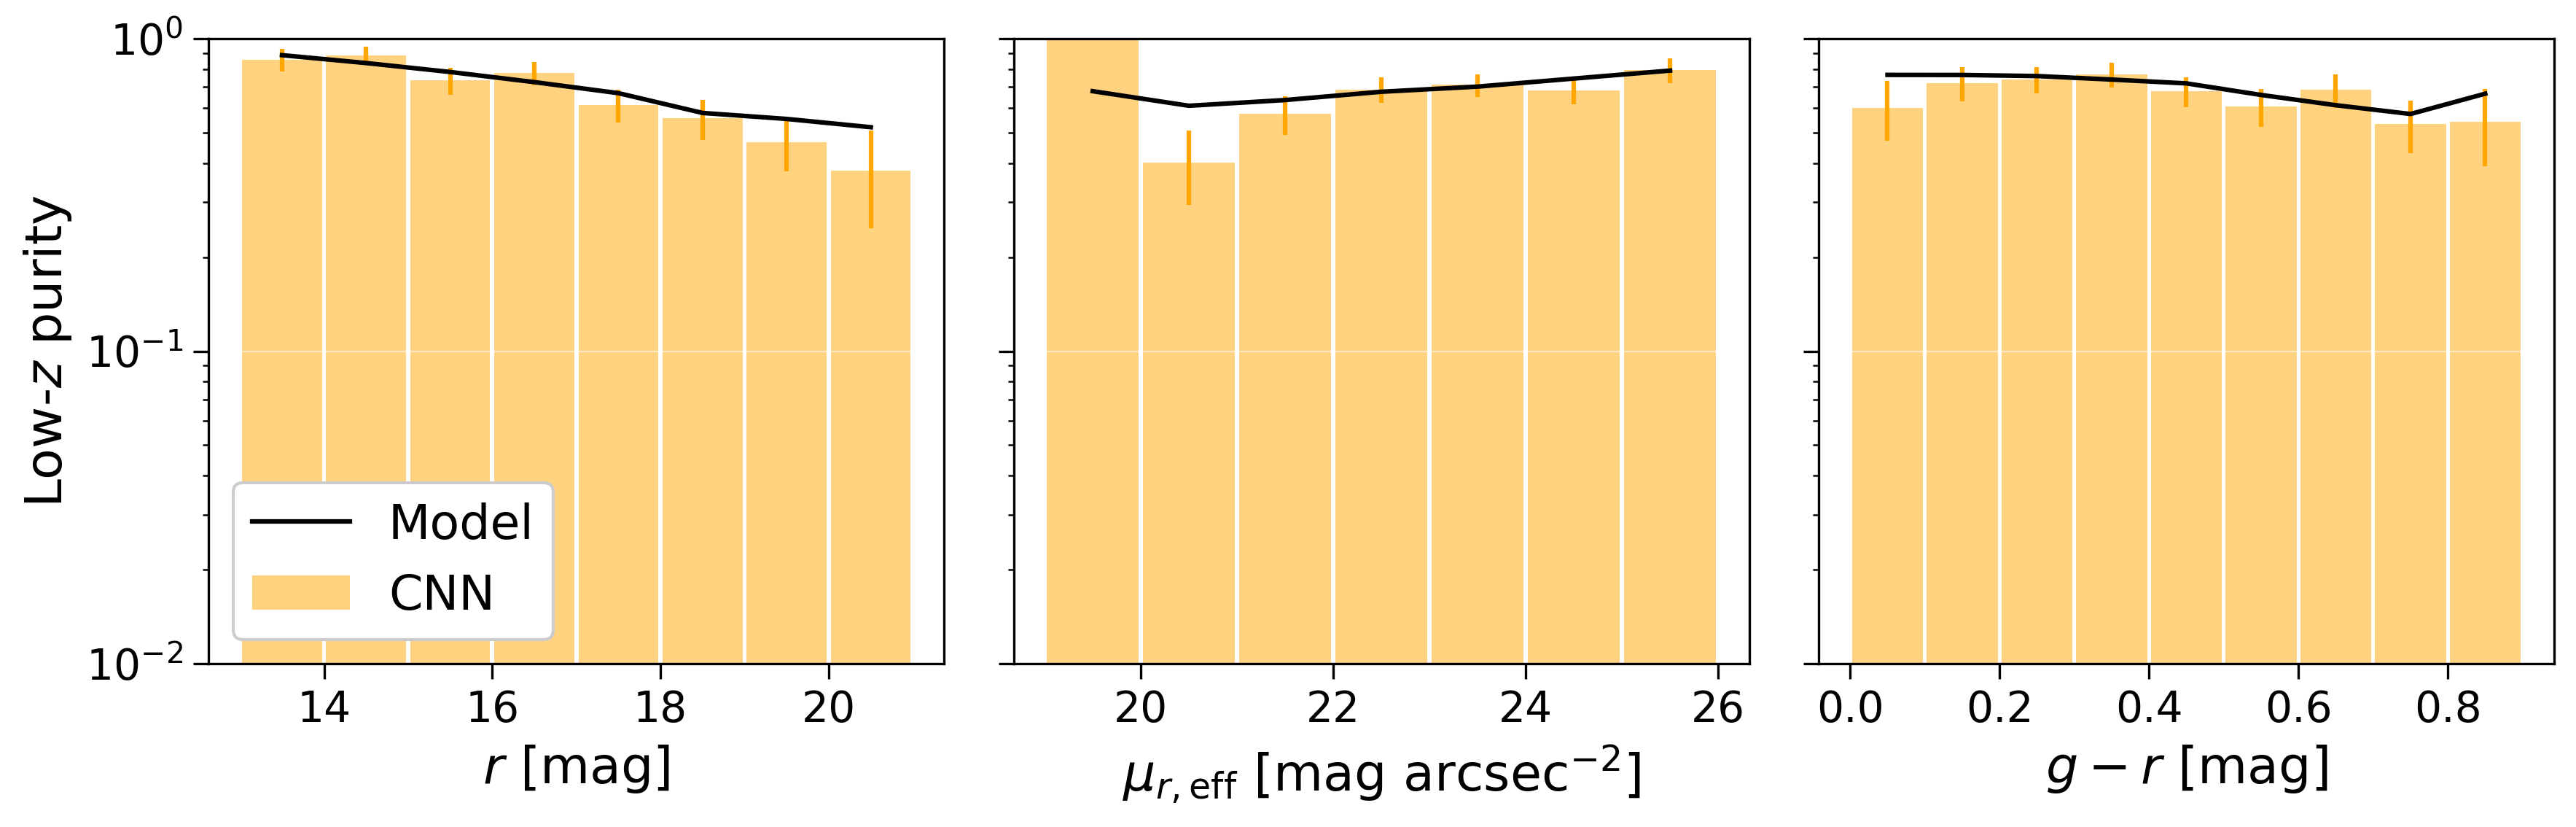

In [64]:
for statistic in ["rate", "completeness", "purity"]:
    plot_model_fit_statistic(
        cv,
        best_fit_params[statistic],
        statistic,
        figname=f"model_fit_lowz-{statistic}.png",
    )
    plt.savefig(figures_dir / f"model_fit_lowz-{statistic}.pdf")


## (Fig 16 --- A.3) Modeled purity and completeness with radius

In [25]:
from scipy.stats import binned_statistic

In [30]:
pred_df["r_mag_scaled"] = (pred_df.r_mag - 19.30038351) / 1.63920353
pred_df["sb_r_scaled"] = (pred_df.sb_r - 22.23829513) / 1.60764197
pred_df["gr_scaled"] = (pred_df.gr - 0.97987122) / 1.16822956

pred_df['p_model_rate'] = lowz_rate_model(
    best_fit_params['rate'], 
    pred_df.r_mag_scaled , 
    pred_df.sb_r_scaled, 
    pred_df.gr_scaled
)

pred_df['p_model_completeness'] = lowz_rate_model(
    best_fit_params['completeness'], 
    pred_df.r_mag_scaled , 
    pred_df.sb_r_scaled, 
    pred_df.gr_scaled
)

pred_df['p_model_purity'] = lowz_rate_model(
    best_fit_params['purity'], 
    pred_df.r_mag_scaled , 
    pred_df.sb_r_scaled, 
    pred_df.gr_scaled
)

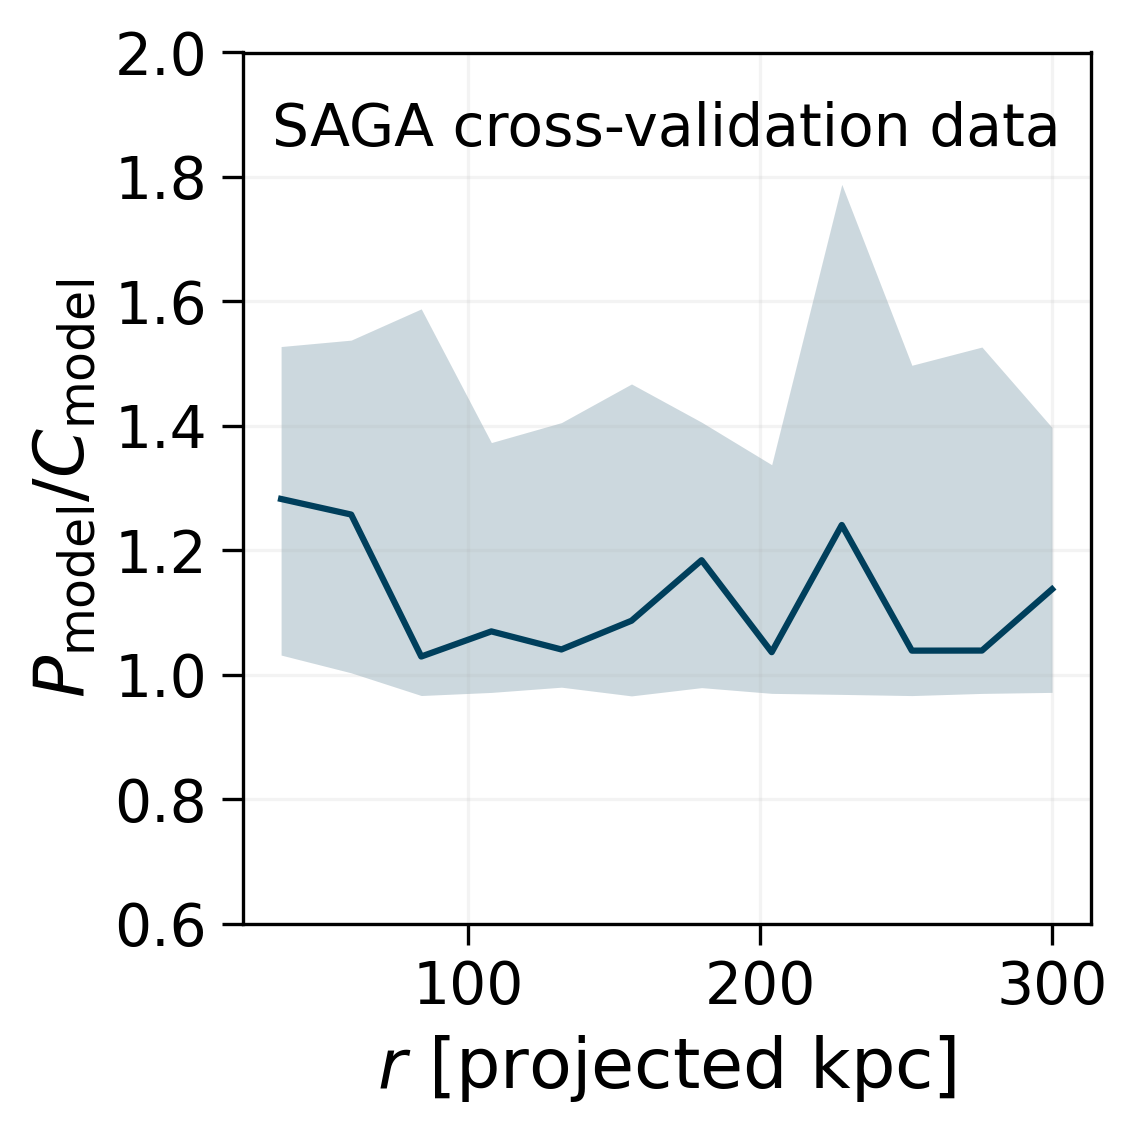

In [74]:
N_bins = 12
q = Query("p_CNN > 0.5", "D_PROJ > 36")

## compute corrections
correction_factor_with_radius = binned_statistic(
    q.filter(pred_df).D_PROJ, 
    (q.filter(pred_df).p_model_purity / q.filter(pred_df).p_model_completeness),
    bins=N_bins,
    statistic='median'
).statistic

correction_factor_with_radius_q16 = binned_statistic(
    q.filter(pred_df).D_PROJ, 
    (q.filter(pred_df).p_model_purity / q.filter(pred_df).p_model_completeness),
    statistic=partial(np.quantile, q=0.16), bins=N_bins,
).statistic
correction_factor_with_radius_q84 = binned_statistic(
    q.filter(pred_df).D_PROJ, 
    (q.filter(pred_df).p_model_purity / q.filter(pred_df).p_model_completeness),
    statistic=partial(np.quantile, q=0.84), bins=N_bins,
).statistic


## PLOT
plt.figure(figsize=(4,4))
plt.plot(
    np.linspace(36, 300, N_bins),
    correction_factor_with_radius,
    color='#003f5c',
)
plt.fill_between(
    np.linspace(36, 300, N_bins),
    correction_factor_with_radius_q16,
    correction_factor_with_radius_q84,
    color='#003f5c',
    lw=0,
    alpha=0.2
)

plt.grid(alpha=0.15)
plt.ylim(0.6, 2.);
plt.ylabel(r'$P_{\rm model}/C_{\rm model}$')
plt.xlabel('$r$ [projected kpc]');

plt.text(33, 1.85, 'SAGA cross-validation data')
plt.tight_layout()


plt.savefig(figures_dir / "model-purity-completeness_host-separation.pdf")

## (Fig 17a --- A.4a) Modeled P/C with mass

In [31]:
xsaga = pd.read_parquet(ROOT / 'results/xSAGA/sats-nsa_p0_5.parquet')

xsaga["r_mag_scaled"] = (xsaga.r0 - 19.30038351) / 1.63920353
xsaga["sb_r_scaled"] = (xsaga.mu_eff - 22.23829513) / 1.60764197
xsaga["gr_scaled"] = (xsaga.gmr - 0.97987122) / 1.16822956

xsaga['p_model_rate'] = lowz_rate_model(
    best_fit_params['rate'], 
    xsaga.r_mag_scaled , 
    xsaga.sb_r_scaled, 
    xsaga.gr_scaled
)

xsaga['p_model_completeness'] = lowz_rate_model(
    best_fit_params['completeness'], 
    xsaga.r_mag_scaled , 
    xsaga.sb_r_scaled, 
    xsaga.gr_scaled
)

xsaga['p_model_purity'] = lowz_rate_model(
    best_fit_params['purity'], 
    xsaga.r_mag_scaled , 
    xsaga.sb_r_scaled, 
    xsaga.gr_scaled
)

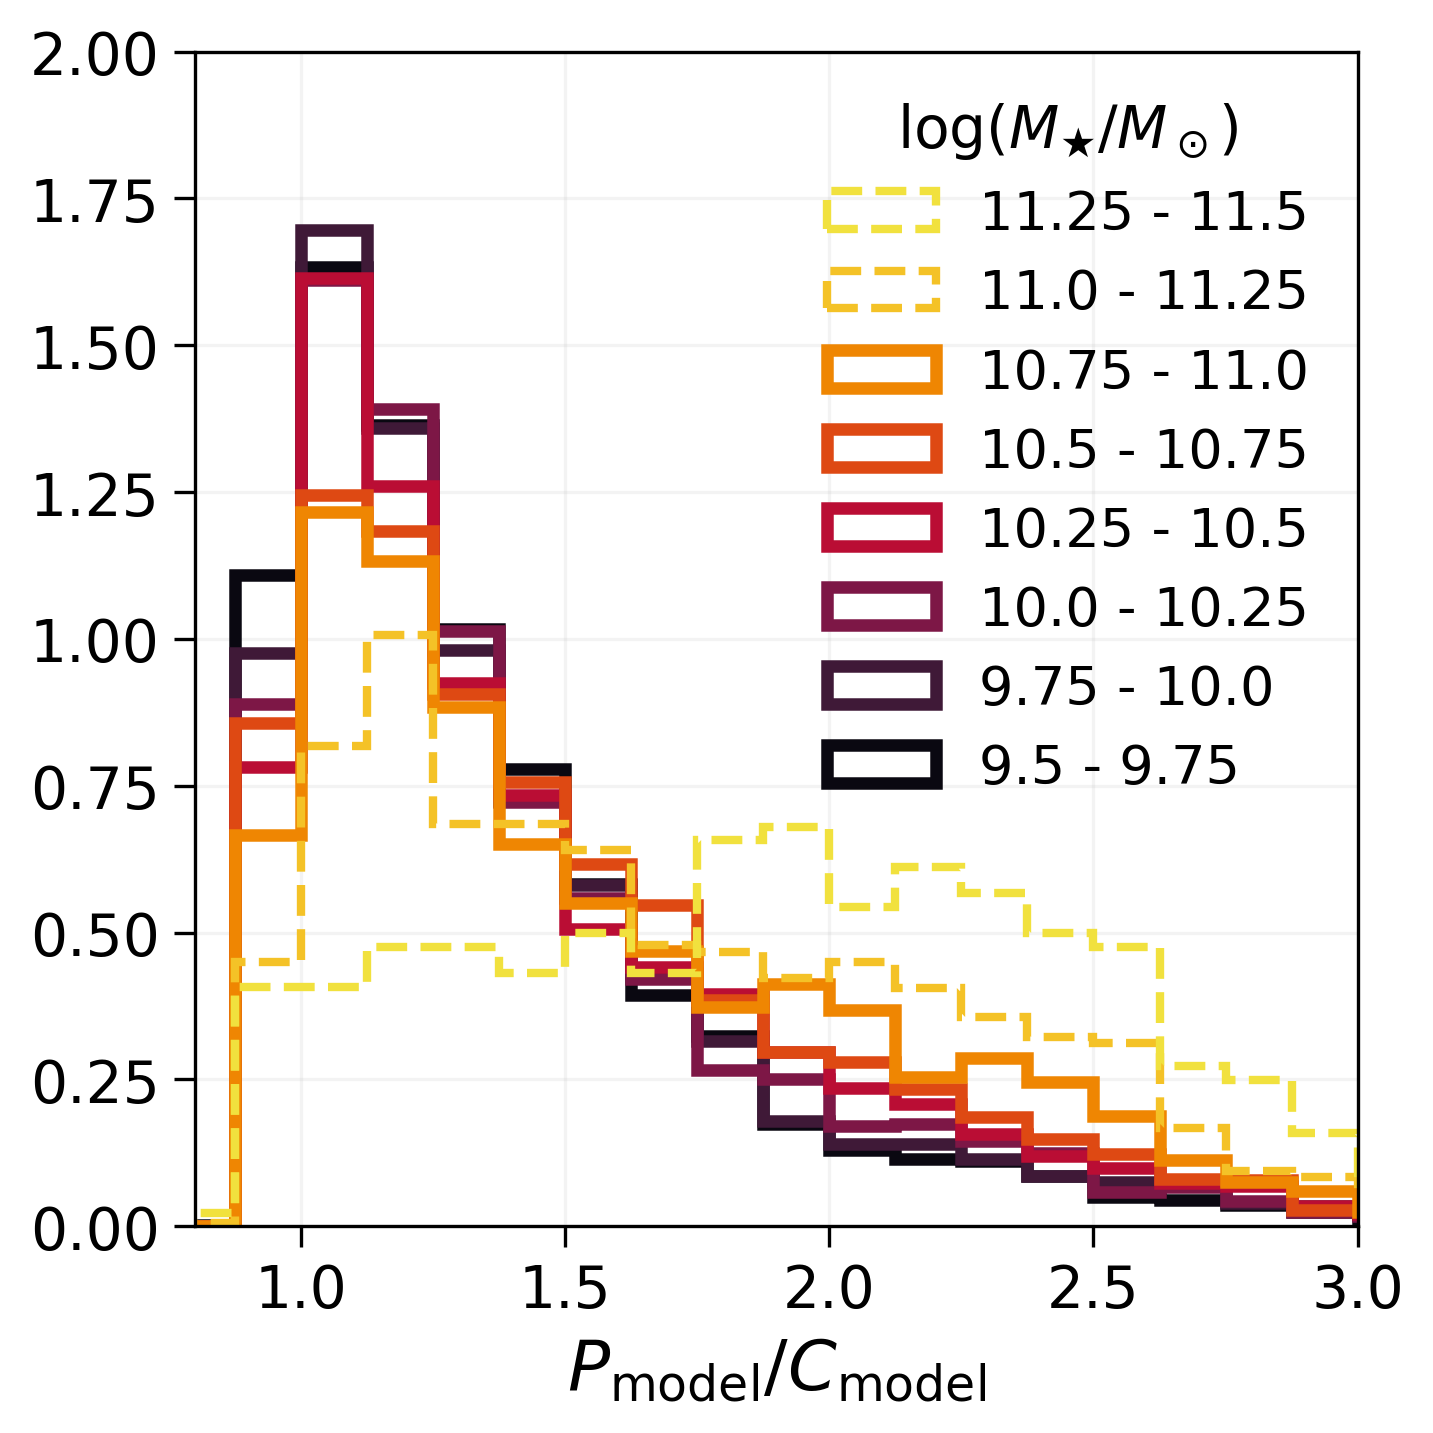

In [33]:
plt.figure(figsize=(5, 5))

mass_bins = np.arange(9.5, 11.5, 0.25)
for m1, m2 in zip(mass_bins, mass_bins+0.25):
    q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")

    plt.hist(
        q.filter(xsaga).p_model_purity / q.filter(xsaga).p_model_completeness, 
        bins=24, range=[0.5, 3.5], histtype='step', 
        density=True,
        color=mass2color((m1 + m2) / 2, mass_max=11.25), 
        lw=3 if m2 <= 11 else 2,
        ls='-' if m2 <= 11 else '--',
        label=f'{m1} - {m2}'
    )
#     print((q.filter(xsaga).p_model_purity / q.filter(xsaga).p_model_completeness).quantile([0.16, 0.5, 0.84]).values)

plt.grid(alpha=0.15)
plt.xlim(0.8, 3.0)
plt.ylim(0, 2.0)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=13, title=r'$\log(M_★/M_\odot)$')
plt.xlabel(r'$P_{\rm model} / C_{\rm model}$')
plt.tight_layout()


plt.savefig(figures_dir / "model-purity-completeness_host-mass.pdf")

## (Fig 17b --- A.4b) Modeled P/C with morphology

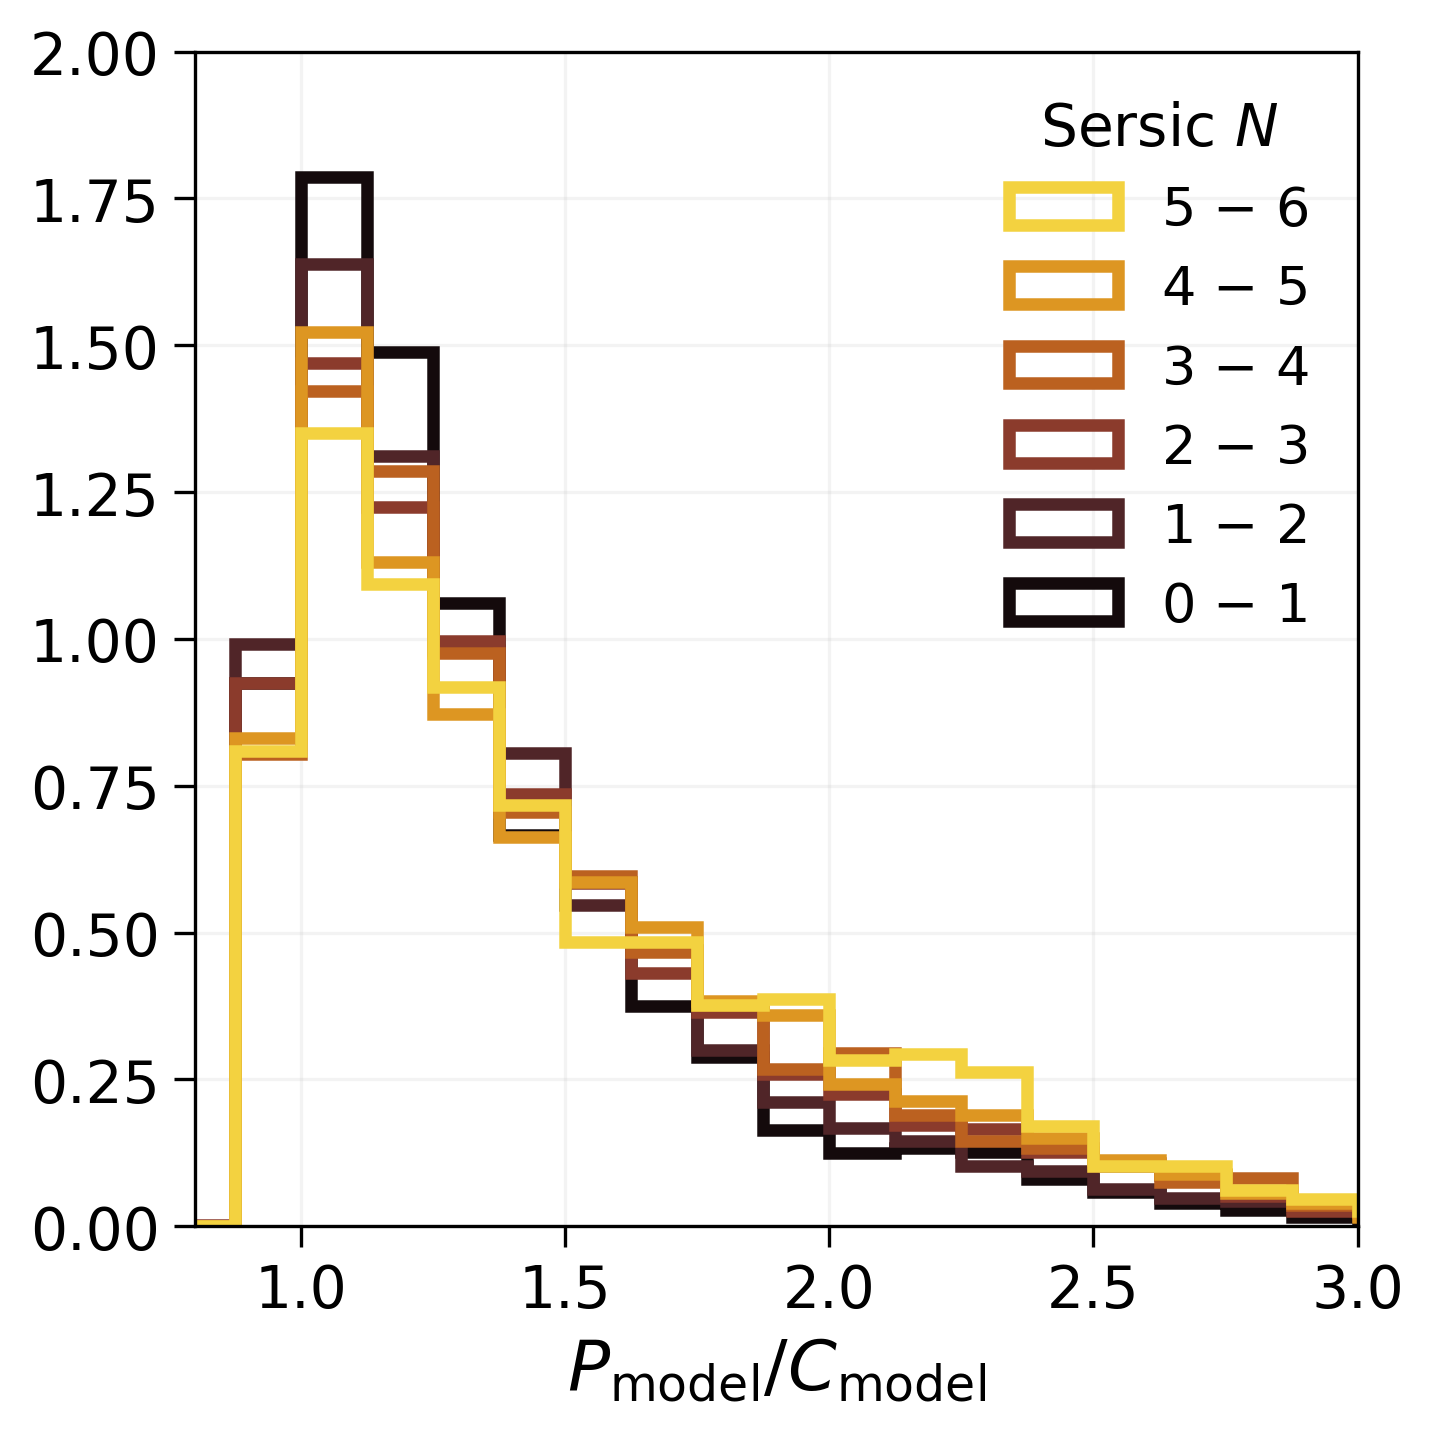

In [34]:
N_bins = np.arange(0, 6, 1)

plt.figure(figsize=(5, 5))
for n1, n2 in zip(N_bins, N_bins+1):
    q = Query(f"SERSIC_N_NSA > {n1}", f"SERSIC_N_NSA < {n2}", "mass_GSE < 11")

    plt.hist(
        q.filter(xsaga).p_model_purity / q.filter(xsaga).p_model_completeness, 
        bins=24, range=[0.5, 3.5], histtype='step', 
        density=True,
        color=mass2color((n1 + n2) / 2, cmap=cmr.amber, mass_min=0, mass_max=6.0), lw=3,
        label=f"{n1} $-$ {n2}"
    )
    
#     print((q.filter(xsaga).p_model_purity / q.filter(xsaga).p_model_completeness).quantile([0.16, 0.5, 0.84]).values)
plt.grid(alpha=0.15)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=13, title='Sersic $N$')
plt.xlabel(r'$ P_{\rm model} / C_{\rm model}$')
plt.xlim(0.8, 3.0)
plt.ylim(0, 2.0)

plt.tight_layout()

plt.savefig(figures_dir / "model-purity-completeness_host-morphology.pdf")

## (Fig 18 --- A.5) Purity correction factors 

In [18]:
saga2_hosts = pd.read_csv(ROOT / "data/saga_stage2_hosts.csv")
saga2_sats = pd.read_csv(ROOT / "data/saga_stage2_sats.csv")

cv_coords = SkyCoord(cv.RA, cv.DEC, unit='deg')
s2_coords = SkyCoord(saga2_sats.RA, saga2_sats.DEC, unit='deg')

# joining CNN predictions with SAGA labels
predictions = dict()

for hostname, host in saga2_hosts.set_index("INTERNAL_HOSTID", drop=True).iterrows():
    host_coord = SkyCoord(host.RA, host.DEC, unit='deg')
    sep = host_coord.separation(cv_coords)
    
    max_angsep = ((0.3 / host.DIST) * u.rad).to(u.arcsec)
    
    sub_cv = cv[sep < max_angsep].copy()
    sub_cv['D_PROJ'] = sep[sep < max_angsep].to(u.rad).value * host.DIST * 1e3 # in pkpc
    
    predictions[hostname] = sub_cv
    
pred_df = pd.concat(predictions)

In [19]:
# confusion matrix elements
FP = (~pred_df.low_z & (pred_df.p_CNN > 0.5)).groupby(level=0).sum()
TP = (pred_df.low_z & (pred_df.p_CNN > 0.5)).groupby(level=0).sum()
TN = (~pred_df.low_z & (pred_df.p_CNN < 0.5)).groupby(level=0).sum()
FN = (pred_df.low_z & (pred_df.p_CNN < 0.5)).groupby(level=0).sum()

N_highz = FP + TN

In [20]:
FP.mean() / (np.pi * 0.5**2)

3.5721442782847617

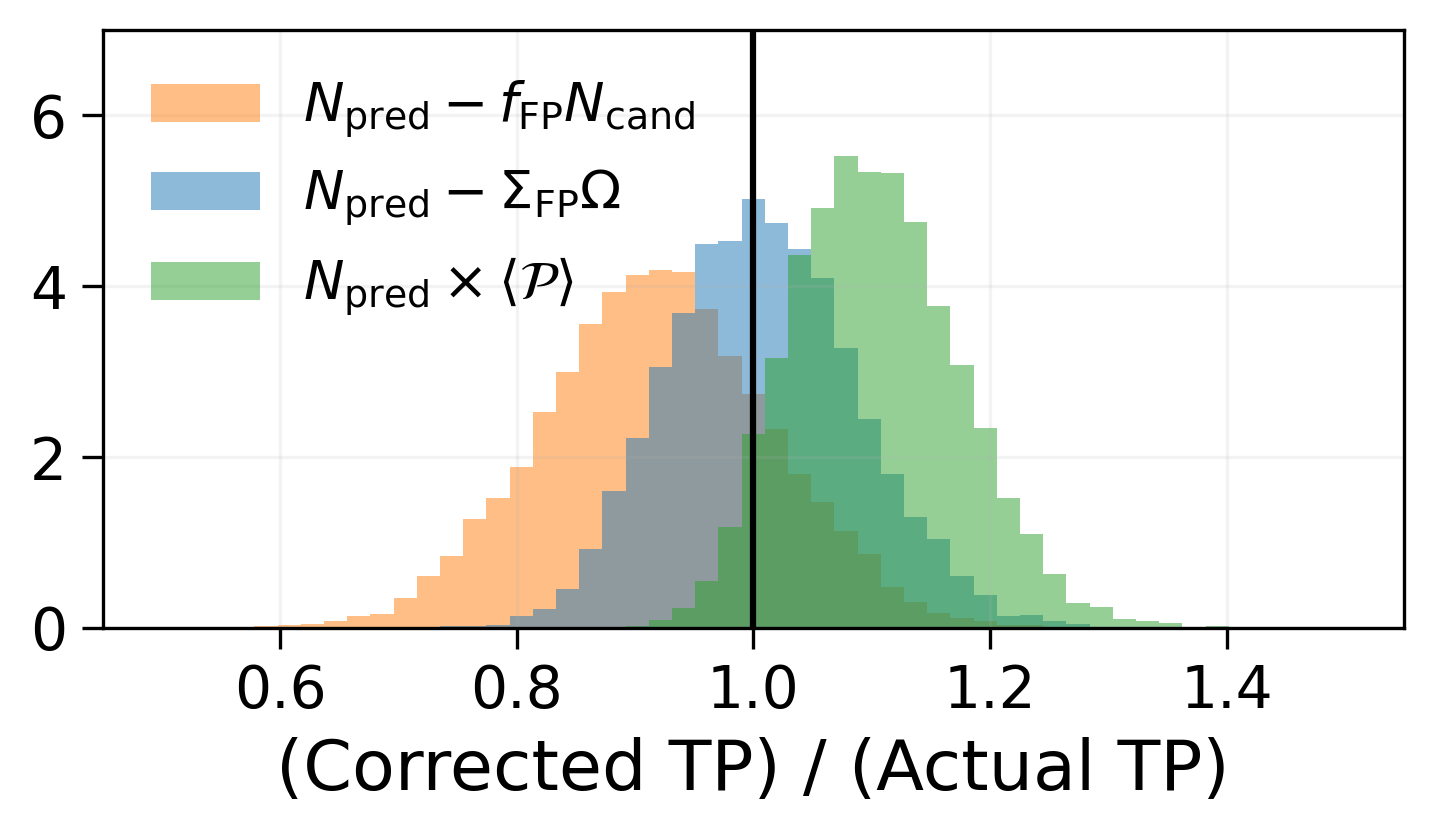

In [109]:
plt.figure(figsize=(5, 3), dpi=300)



FPR_correction = bootstrap(
    ((TP+FP) - (FP/(TP+FP+TN+FN)).mean()*(TP+FP+TN+FN) ) / TP,
    bootfunc=np.mean, bootnum=10000
)
plt.hist(
    FPR_correction, bins=51, range=(0.5, 1.5), color='C1',alpha=0.5, density=True,
    label=r"$N_{\rm pred} - f_{\rm FP} N_{\rm cand}$",
)

FP_correction = bootstrap(
    ((TP+FP) - FP.mean()) / TP, 
    bootfunc=np.mean, bootnum=10000
)

plt.hist(
    FP_correction, bins=51, range=(0.5, 1.5), color='C0', alpha=0.5, density=True,
    label=r"$N_{\rm pred} - \Sigma_{\rm FP} \Omega$",
)


purity_correction = bootstrap(
    (TP+FP) * (TP/(TP+FP)).mean() / TP,
    bootfunc=np.mean, bootnum=10000
)

plt.hist(
    purity_correction, bins=51, range=(0.5, 1.5), color='C2', alpha=0.5, density=True,
    label=r"$N_{\rm pred} \times \langle \mathcal{P} \rangle$",
);
plt.axvline(1, c='k')

plt.legend(fontsize=13)
plt.xlabel("(Corrected TP) / (Actual TP)")
# plt.ylabel("Number of SAGA halos", fontsize=14)
plt.grid(alpha=0.15)
plt.ylim(0,7)

plt.tight_layout()

plt.savefig(figures_dir / "TP-corrections.pdf")


In [120]:
# only SAGA II selection
FP = (~pred_df.low_z & (pred_df.p_CNN > 0.5) & (pred_df.saga_sel == 2)).groupby(level=0).sum()
TP = (pred_df.low_z & (pred_df.p_CNN > 0.5) & (pred_df.saga_sel == 2)).groupby(level=0).sum()
TN = (~pred_df.low_z & (pred_df.p_CNN < 0.5) & (pred_df.saga_sel == 2)).groupby(level=0).sum()
FN = (pred_df.low_z & (pred_df.p_CNN < 0.5) & (pred_df.saga_sel == 2)).groupby(level=0).sum()

In [124]:
np.mean(FP / (FP + TP + TN + FN))

0.0161348323666571

In [33]:
FP.mean() / (np.pi * 0.5**2)

3.0416278013117775

# Results: satellite radial profiles

In [11]:
from radial_profiles import *
from satellites import *

In [12]:
def corrected_satellite_richness(sats, hosts, max_radius=300, min_radius=36, nonsatellite_volume_density=0.0142, FP_surface_density=3.04):
    """Returns the correct N_sat per host, such that the end result has the 
    same shape as `hosts`.
    
    Corections:
        - Completeness correction is now split into an extra (equal) 
          contribution per host: 1/0.600 - 1 = 2/3 the mean value.
          Note: this is done in order to make the completeness correction
          "commute" with taking the mean or std.
        - Interlopers appear at a rate of 2.34 per sq deg
        - Non-satellite low-z galaxies appear at a volume density 
          of 0.0142 per Mpc^-3.
    """
    
    # get data ready
    sats = Query(f"sep < {max_radius}").filter(sats)
    
    sats = sats[sats.NSAID.isin(hosts.index)]
    
    # count number of satellites
    N_sats = (
        sats.value_counts("NSAID")
        .append(
            pd.Series(
                {nsaid: 0 for nsaid in hosts.index[~hosts.index.isin(sats.NSAID)]}, 
                dtype=np.float64
            )
        )
    )
    
    # add contribution for completeness
    N_incomplete = np.full(len(hosts), N_sats.mean() * 2/3)
    
    # count number of interlopers
    N_interlopers = compute_interloper_numbers(hosts.z_NSA, max_radius=max_radius, FP_surface_density=FP_surface_density)
    
    # count number of non-satellites
    N_unrelated_lowz = compute_nonsatellite_numbers(hosts.z_NSA, max_radius=max_radius, volume_density=nonsatellite_volume_density)
    
    return (N_sats + N_incomplete - N_interlopers - N_unrelated_lowz).values
    
    
def f(s, h, q, N_boot=100, r=300):
    """Helper function for bootstrapping satellite number counts"""
    
    
    return bootstrap(
        corrected_satellite_richness(q.filter(s), q.filter(h), max_radius=r),
        bootnum=N_boot,
        bootfunc=np.mean
    )

def compute_nonsatellite_numbers(redshifts, delta_z=0.005, volume_density=0.0142, max_radius=300, min_radius=36):
    """Compute the number of low-z galaxies that *aren't* satellites, for hosts
    at given redshifts. `volume_density` should be in Mpc^-3.
    """
    z_upper = redshifts + delta_z
    z_lower = redshifts - delta_z
    z_upper = np.where(z_upper > 0.03, 0.03, z_upper)
    z_lower = np.where(z_lower < 0, 0, z_lower)

    total_volumes = (
        cosmo.comoving_volume(0.03) - cosmo.comoving_volume(z_upper)
    ) / 1.03 ** 3 + (cosmo.comoving_volume(z_lower)) / (1 + z_lower) ** 3
    volumes = (
        (((max_radius * u.kpc)**2 - (min_radius * u.kpc)**2) / (cosmo.kpc_proper_per_arcmin(redshifts)**2))
        .to(u.steradian)
        .value
        / (4 * np.pi)
        * total_volumes
    )

    return volume_density * volumes.value
        
def compute_interloper_numbers(redshifts, max_radius=300, min_radius=36, FP_surface_density=3.04):
    """Compute the number of interlopers that the CNN gets wrong, on average, 
    per square degree.
    """

    sq_deg_per_sq_kpc = (
        cosmo.arcsec_per_kpc_proper(redshifts).to(u.deg / u.kpc).value
    ) ** 2
    surface_area = np.pi * (max_radius ** 2 - min_radius ** 2) * sq_deg_per_sq_kpc

    return surface_area * FP_surface_density

In [13]:
def plot_radial_profile_by_host_mass(
    hosts,
    sats,
    corrected=True,
    include_saga=True,
    radial_bins=np.arange(36, 300, 1),
    cumulative=True,
    normalize=False,
    areal_density=False,
    N_boot=None,
    sigma_smooth=None,
    mass_min=9.5,
    mass_max=11.0,
    dmass=0.5,
    fname="radial_profile-by-host_mass",
):
    """Creates a radial profile plot for satellites colored by host mass.

    Parameters
        hosts : pd.DataFrame
            DataFrame of hosts, which is assumed to be pre-filtered using
            cuts at top of this script.
        sats : pd.DataFrame
            DataFrame of satellites, also assumed to be filtered.
        corrected : bool
            If true, correct by dividing by the completeness (0.600) and subtracting
            the number of interlopers based on a constant false positive surface
            density (3.04 per deg^2).
        radial_bins : 1d array-like
            A list or array of (maximum) projected radii.
        cumulative : bool
            Toggles whether to plot the satellite number within a given projected
            radius versus at a given radius.
        normalize : bool
            Toggles whether to divide the curves by the total number of satellites
        areal_density : bool
            Toggles whether to divide by the annular area at each radius.
        N_boot : int or None
            The number of bootstrap resamples (for estimating uncertainties).
            Can also be `None` if boostrapping is not wanted.
        sigma_smooth : float or None
            The sigma for 1d Gaussian convolution. Can be None.
        include_saga : bool
            If true, then include the 16-84th percentile range for SAGA mean profile.
        mass_min : float
            The minimum host (log) mass.
        mass_max : float
            The maximum host (log) mass.
        dmass : float
            The interval per mass bin.
        fname : str
            The name of the output figure (JPG format), to be saved in the directory
            `./results/xSAGA/plots/profiles/`.
    """

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    mass_bins = np.arange(mass_min, mass_max, dmass)

    dr = (radial_bins.max() - radial_bins.min()) / len(radial_bins)
    
    
    # plot saga curve
    if include_saga and cumulative and (not areal_density):
        boot_saga_profile = bootstrap_saga_profile(radial_bins=radial_bins, N_boot=100)

        if normalize:
            boot_saga_profile /= boot_saga_profile.max(1, keepdims=True)

        ax.fill_between(
            radial_bins,
            *np.quantile(boot_saga_profile, [0.16, 0.84], axis=0),
            color="0.5",
            lw=0,
            alpha=0.5,
            label="SAGA II",
        )

    for m1, m2 in zip(mass_bins, mass_bins + dmass):
        q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
        satellite_separations = q.filter(sats).sep.values

        try:
            # compute sat cumulative profile or bootstrapped profile
            if N_boot is None:
                profile = compute_radial_profile(satellite_separations, radial_bins)
                profile = profile / q.count(hosts)

                if sigma_smooth is not None:
                    profile = smooth(profile, sigma_smooth)

                # correct using completeness and interlopers
                if corrected:
                    interloper_profile = compute_interloper_profile(
                        q.filter(sats).z_NSA,
                        radial_bins,
                    )

                    nonsatellite_profile = compute_nonsatellite_profile(
                        hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
                    )

                    profile = (
                        profile / 0.600 - interloper_profile - nonsatellite_profile
                    )

                if areal_density:
                    # kpc^-2 --> Mpc^-2
                    surface_area = (
                        np.pi
                        * (
                            (radial_bins + dr / 2) ** 2
                            - (radial_bins.min() - dr / 2) ** 2
                        )
                        / 1e6
                    )

                    profile = profile / surface_area

                if not cumulative:
                    profile = np.gradient(profile, radial_bins, edge_order=2)

                if normalize:
                    profile /= profile.max()

                ax.plot(
                    radial_bins,
                    profile.mean(0),
                    c=mass2color((m1 + m2) / 2),
                    label=f"${m1}-{m2}$",
                    lw=3,
                )
            else:
                assert isinstance(N_boot, int), "Please enter an integer `N_boot`."
                profile_bootstrapped = bootstrap(
                    satellite_separations,
                    bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
                    bootnum=N_boot,
                )

                profile_bootstrapped = profile_bootstrapped / q.count(hosts)

                if sigma_smooth is not None:
                    profile_bootstrapped = smooth(profile_bootstrapped, sigma_smooth)

                if corrected:
                    interloper_profile = compute_interloper_profile(
                        q.filter(sats).z_NSA,
                        radial_bins,
                    )

                    interloper_profile_bootstrapped = rng.choice(
                        interloper_profile, size=N_boot, replace=True
                    )

                    nonsatellite_profile = compute_nonsatellite_profile(
                        hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
                    )

                    nonsatellite_profile_bootstrapped = rng.choice(
                        nonsatellite_profile, size=N_boot, replace=True
                    )

                    profile_bootstrapped = (
                        profile_bootstrapped / 0.600
                        - interloper_profile_bootstrapped
                        - nonsatellite_profile_bootstrapped
                    )

                if not cumulative:
                    profile_bootstrapped = np.gradient(
                        profile_bootstrapped, radial_bins, axis=1, edge_order=2
                    )

                if areal_density:
                    surface_area = (
                        np.pi
                        * (
                            (radial_bins + dr / 2) ** 2
                            - (radial_bins.min() - dr / 2) ** 2
                        )
                        / 1e6
                    )
                    profile_bootstrapped = profile_bootstrapped / surface_area

                if normalize:
                    profile_bootstrapped /= profile_bootstrapped.max(1, keepdims=True)

                ax.fill_between(
                    radial_bins,
                    *np.quantile(profile_bootstrapped, [0.16, 0.84], axis=0),
                    color=mass2color((m1 + m2) / 2),
                    label=f"${m1}-{m2}$",
                    lw=0,
                    alpha=0.7,
                )

        except ValueError as e:
            raise e

    xlabel = "$r$ [projected kpc]"
    ylabel = (
        ("Normalized " if normalize else "")
        + (r"$\Sigma_{\rm sat}$" if areal_density else r"$N_{\rm sat}$")
        + ("(r)" if not cumulative else "(<r)")
        + (" [Mpc$^{-2}$]" if areal_density else "")
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.15)

    legend_location = (
        "upper right" if (areal_density and (not cumulative)) else "upper left"
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1], loc=legend_location, fontsize=12, title=r"log($M_★/M_\odot$)", title_fontsize=14
    )
    fig.tight_layout()

In [38]:
N_boot = 100

## Numbers of hosts, satellites, and corrected satellites

In [39]:
hosts, sats = load_hosts_and_sats()

print("No cuts")

N_hosts = len(hosts)
N_sats_CNN = len(sats)

print(f"  Number of hosts: {N_hosts}")
print(f"  Number of CNN-detected satellites: {N_sats_CNN}")

No cuts
  Number of hosts: 12769
  Number of CNN-detected satellites: 21492


In [40]:
print("After mass, redshift, and completeness cuts")

# impose cuts
hosts = HOST_QUERY.filter(hosts)
sats = (HOST_QUERY & SAT_QUERY).filter(sats)

N_hosts = len(hosts)
N_sats_CNN = len(sats)

print(f"  Number of hosts: {N_hosts}")
print(f"  Number of CNN-detected satellites: {N_sats_CNN}")

After mass, redshift, and completeness cuts
  Number of hosts: 12053
  Number of CNN-detected satellites: 14661


In [41]:
print("After mass/redshift/completeness + isolation cuts")

# isolate hosts and sats
hosts = isolate_hosts(hosts, delta_mass=0.0, delta_z=0.005, delta_d=1.0)
sats = sats[sats.NSAID.isin(hosts.index) & (sats.M_r < M_r_lim)].copy()

N_hosts = len(hosts)
N_sats_CNN = len(sats)

print(f"  Number of hosts: {N_hosts}")
print(f"  Number of CNN-detected satellites: {N_sats_CNN}")

After mass/redshift/completeness + isolation cuts
  Number of hosts: 7542
  Number of CNN-detected satellites: 11449


Without bootstrap resampling

In [42]:
corrected_satellite_richness(sats, hosts).sum()

16241.42335083025

In [43]:
corrected_satellite_richness(sats, hosts).mean()

2.1534637166309003

With bootstrap resampling

In [57]:
boot_N_sat = bootstrap(
    corrected_satellite_richness(sats, hosts),
    bootnum=100,
    bootfunc=np.mean
)

print(f'{boot_N_sat.mean():.3f} +/- {boot_N_sat.std():.3f}')

2.153 +/- 0.021


### MW analogs

In [58]:
q = Query("mass_GSE > 10", "mass_GSE < 11")

corrected_satellite_richness(q.filter(sats), q.filter(hosts)).mean()

2.5415410801876317

In [59]:
np.percentile(
    corrected_satellite_richness(q.filter(sats), q.filter(hosts)),
    [16, 50, 84]
)

array([0.83529598, 1.89545913, 3.94710504])

Host-to-host scatter ranges from 0.84 to 3.95!

### MW analogs out to 150 kpc

In [60]:
q = Query("mass_GSE > 10", "mass_GSE < 11")

corrected_satellite_richness(q.filter(sats), q.filter(hosts), max_radius=150).mean()

0.8818137862704115

### Disk galaxies in MW mass range

In [61]:
q = Query("mass_GSE > 10", "mass_GSE < 11", "SERSIC_N_NSA < 2.5")

corrected_satellite_richness(q.filter(sats), q.filter(hosts)).mean()

2.144722733260225

In [62]:
np.percentile(
    corrected_satellite_richness(q.filter(sats), q.filter(hosts)),
    [16, 50, 84]
)

array([0.66932708, 1.70810792, 3.76386005])

## (Fig 5a) Radial profiles against host mass

In [44]:
mass_bins = np.arange(9.5, 11, 0.25)

for m1, m2 in zip(mass_bins, mass_bins + 0.25):
    print(Query(f'mass_GSE > {m1}', f'mass_GSE < {m2}').count(hosts), Query(f'mass_GSE > {m1}', f'mass_GSE < {m2}').count(sats))

970 898
1238 1238
1447 1860
1590 2358
1388 2774
909 2321


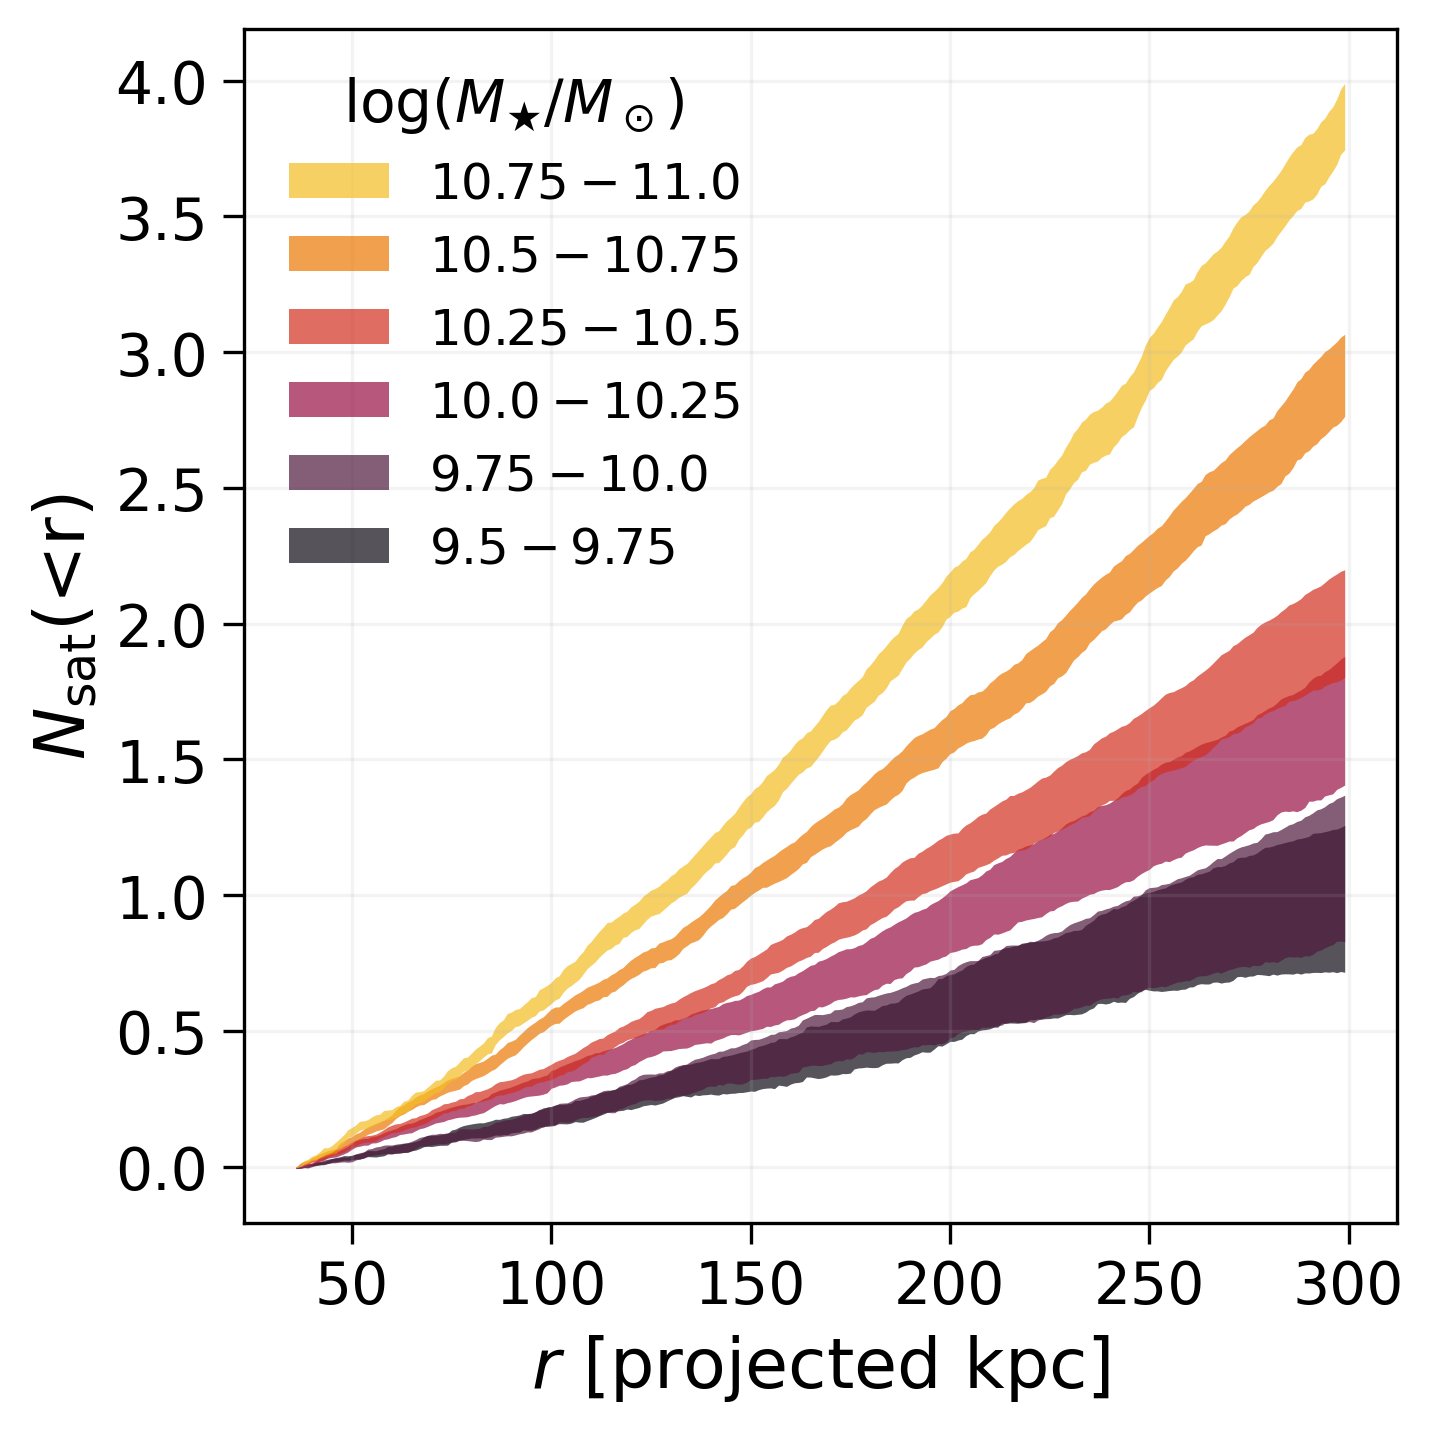

In [45]:
with rng_context:
    plot_radial_profile_by_host_mass(
        hosts,
        sats,
        corrected=True,
        include_saga=False,
        dmass=0.25,
        N_boot=N_boot,
        fname="radial_profile-by-host_mass",
    )
    plt.savefig(figures_dir / "radial_profile-by-host_mass.pdf")


## (Fig 5b) Radial *distributions* against host mass

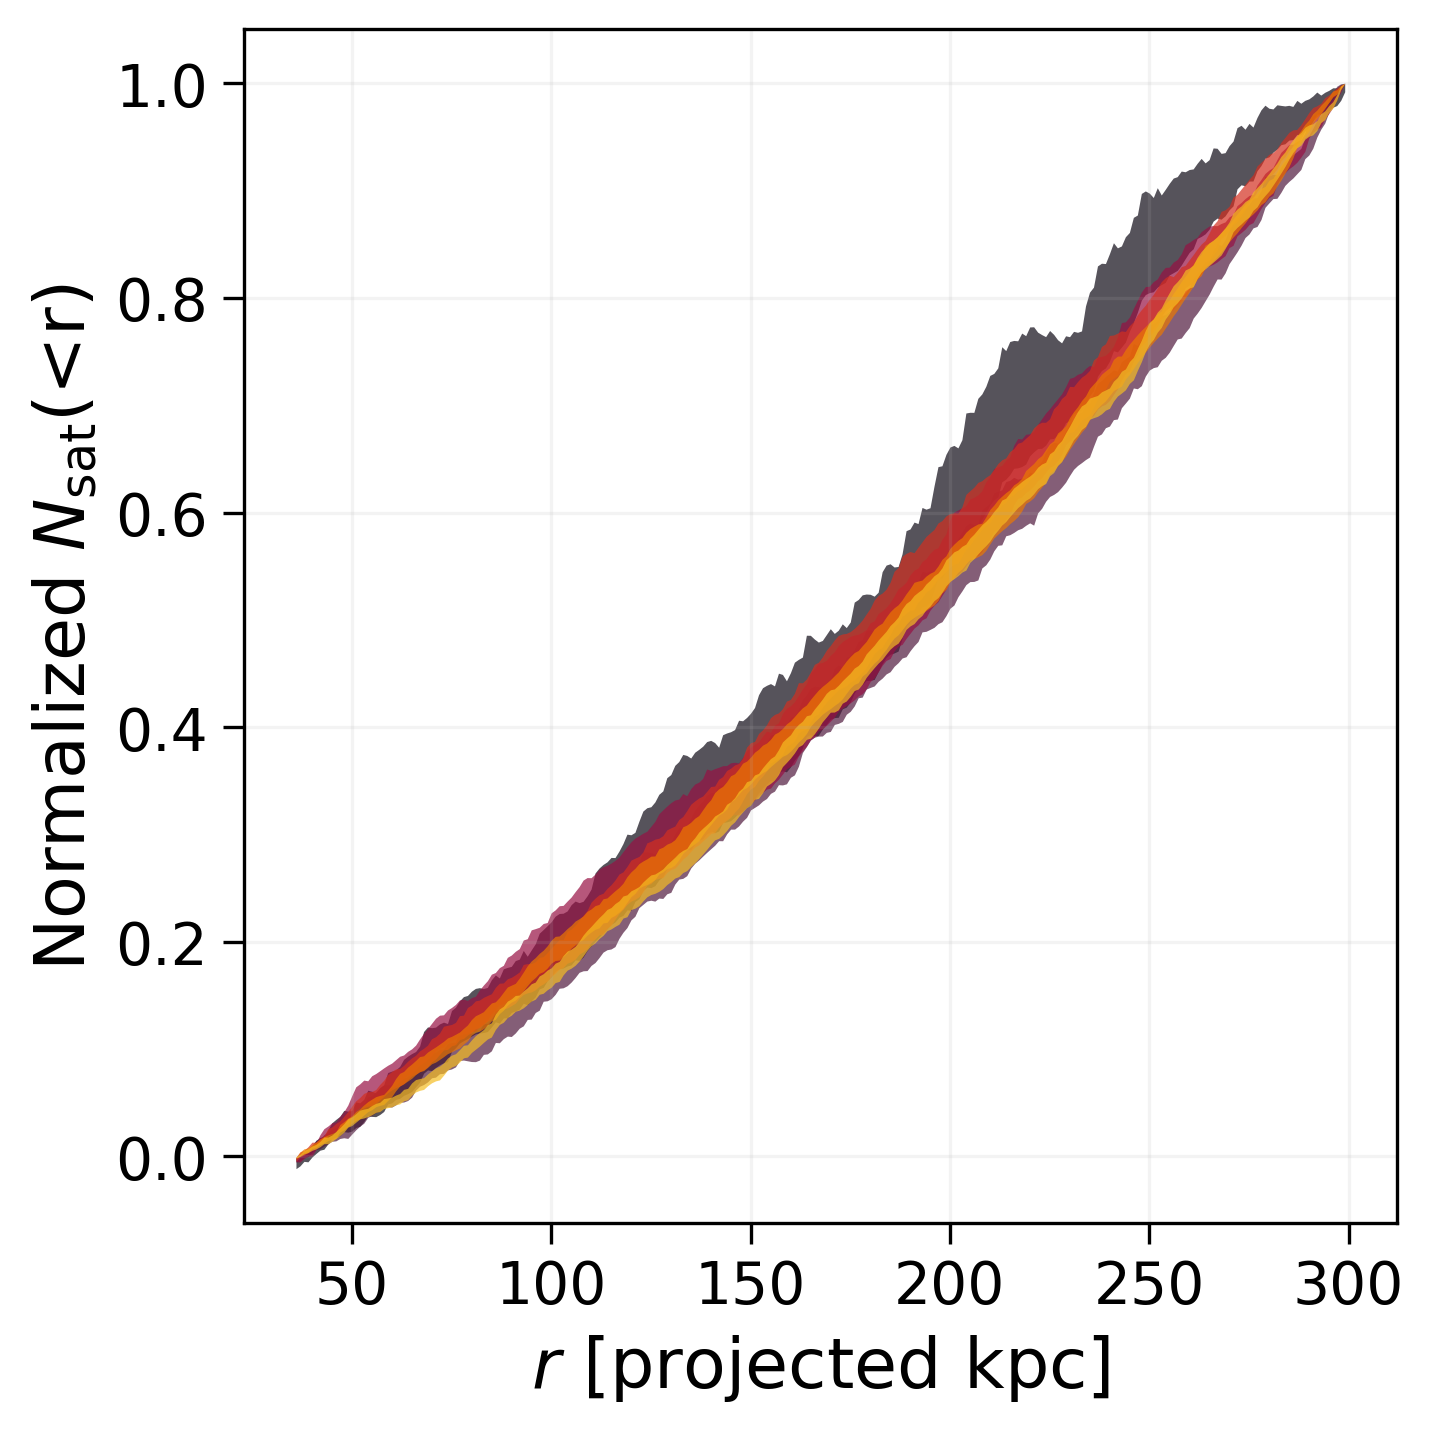

In [48]:
with rng_context:
    plot_radial_profile_by_host_mass(
        hosts,
        sats,
        corrected=True,
        include_saga=False,
        normalize=True,
        dmass=0.25,
        N_boot=N_boot,
        fname="normalized-radial_profile-by-host_mass",
    )
    plt.gca().get_legend().remove()
    plt.savefig(figures_dir / "normalized-radial_profile-by-host_mass.pdf")
  

## (Fig 6) Direct SAGA-xSAGA comparisons

In [49]:
def plot_xsaga_saga_comparison():
    m1 = 10
    m2 = 11

    r_min = 36
    r_max = 300
    dr = 1

    N_boot = 1000

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

    ### Satellite profiles
    ### ==================

    q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    satellite_separations = q.filter(sats).sep.values

    radial_bins = np.arange(r_min, r_max, dr)

    # xSAGA profile
    profile_bootstrapped = bootstrap(
        satellite_separations,
        bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
        bootnum=N_boot,
    )

    profile_bootstrapped = profile_bootstrapped / q.count(hosts)

    interloper_profile = compute_interloper_profile(
        q.filter(sats).z_NSA,
        radial_bins,
        interloper_surface_density=3.04,
    )

    interloper_profile_bootstrapped = rng.choice(
        interloper_profile, size=N_boot, replace=True
    )

    nonsatellite_profile = compute_nonsatellite_profile(
        hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
    )

    nonsatellite_profile_bootstrapped = rng.choice(
        nonsatellite_profile, size=N_boot, replace=True
    )

    profile_bootstrapped = (
        profile_bootstrapped / 0.600
        - interloper_profile_bootstrapped
        - nonsatellite_profile_bootstrapped
    )


    x1, = ax1.plot(
        radial_bins,
        profile_bootstrapped.mean(0),
        c=mass2color((m1 + m2) / 2),
        lw=1,
        zorder=3,
    )
    x2 = ax1.fill_between(
        radial_bins,
        *np.quantile(profile_bootstrapped, [0.16, 0.84], axis=0),
        color=mass2color((m1 + m2) / 2),
        lw=0,
        alpha=0.5,
        zorder=3,
    )


    # saga profile
    boot_saga_profile = bootstrap_saga_profile(radial_bins, N_boot=N_boot)


    s1, = ax1.plot(
        radial_bins,
        boot_saga_profile.mean(0),
        c='C0',
        lw=1,
        ls='--',
        zorder=3,
    )
    s2 = ax1.fill_between(
        radial_bins,
        *np.quantile(boot_saga_profile, [0.16, 0.84], axis=0),
        color='C0',
        alpha=0.5,
        lw=0,
    )


    ### Normalized distributions
    ### ------------------------

    ax2.plot(
        radial_bins,
        (profile_bootstrapped / profile_bootstrapped.max(1, keepdims=True)).mean(0),
        c=mass2color((m1 + m2) / 2),
        lw=1,
        zorder=3,
    )
    ax2.fill_between(
        radial_bins,
        *np.quantile((profile_bootstrapped / profile_bootstrapped.max(1, keepdims=True)), [0.16, 0.84], axis=0),
        color=mass2color((m1 + m2) / 2),
        lw=0,
        alpha=0.5,
        zorder=3,
    )


    ax2.plot(
        radial_bins,
        (boot_saga_profile / boot_saga_profile.max(1, keepdims=True)).mean(0),
        c='C0',
        lw=1,
        ls='--',
        zorder=3,
    )
    ax2.fill_between(
        radial_bins,
        *np.quantile((boot_saga_profile / boot_saga_profile.max(1, keepdims=True)), [0.16, 0.84], axis=0),
        color='C0',
        alpha=0.5,
        lw=0,
    )

    N_sat_saga = boot_saga_profile.max(1).mean()
    N_sat_saga_err = boot_saga_profile.max(1).std()
 
    N_sat = profile_bootstrapped.max(1).mean()
    N_sat_err = profile_bootstrapped.max(1).std()
    
    ax1.grid(alpha=0.15)

    ax1.set_xlabel("$r$ [projected kpc]")
    ax1.set_ylabel(r"$N_{\rm sat}(<r)$")
    
    ax1.text(0.04, 0.8, r'$N_{\rm sat}$' + f' = {N_sat_saga:.2f} $\pm$ {N_sat_saga_err:.2f}', color='C0', transform=ax1.transAxes, fontsize=16)
    ax1.text(0.04, 0.9, r'$N_{\rm sat}$' + f' = {N_sat:.2f} $\pm$ {N_sat_err:.2f}', color=mass2color(10.5), transform=ax1.transAxes, fontsize=16)
    
    ax2.legend(
        [(x1, x2), (s1, s2)], 
        [f'xSAGA (This work)\n$N_{{\\rm host}}={q.count(hosts)}$', 'SAGA (Mao et al. 2021)\n$N_{\\rm host}=36$'], 
        loc='upper left', fontsize=14, framealpha=0
    )
    
    ax2.grid(alpha=0.15)

    ax2.set_xlabel("$r$ [projected kpc]")
    ax2.set_ylabel(r"Normalized $N_{\rm sat}(<r)$");

    fig.tight_layout()

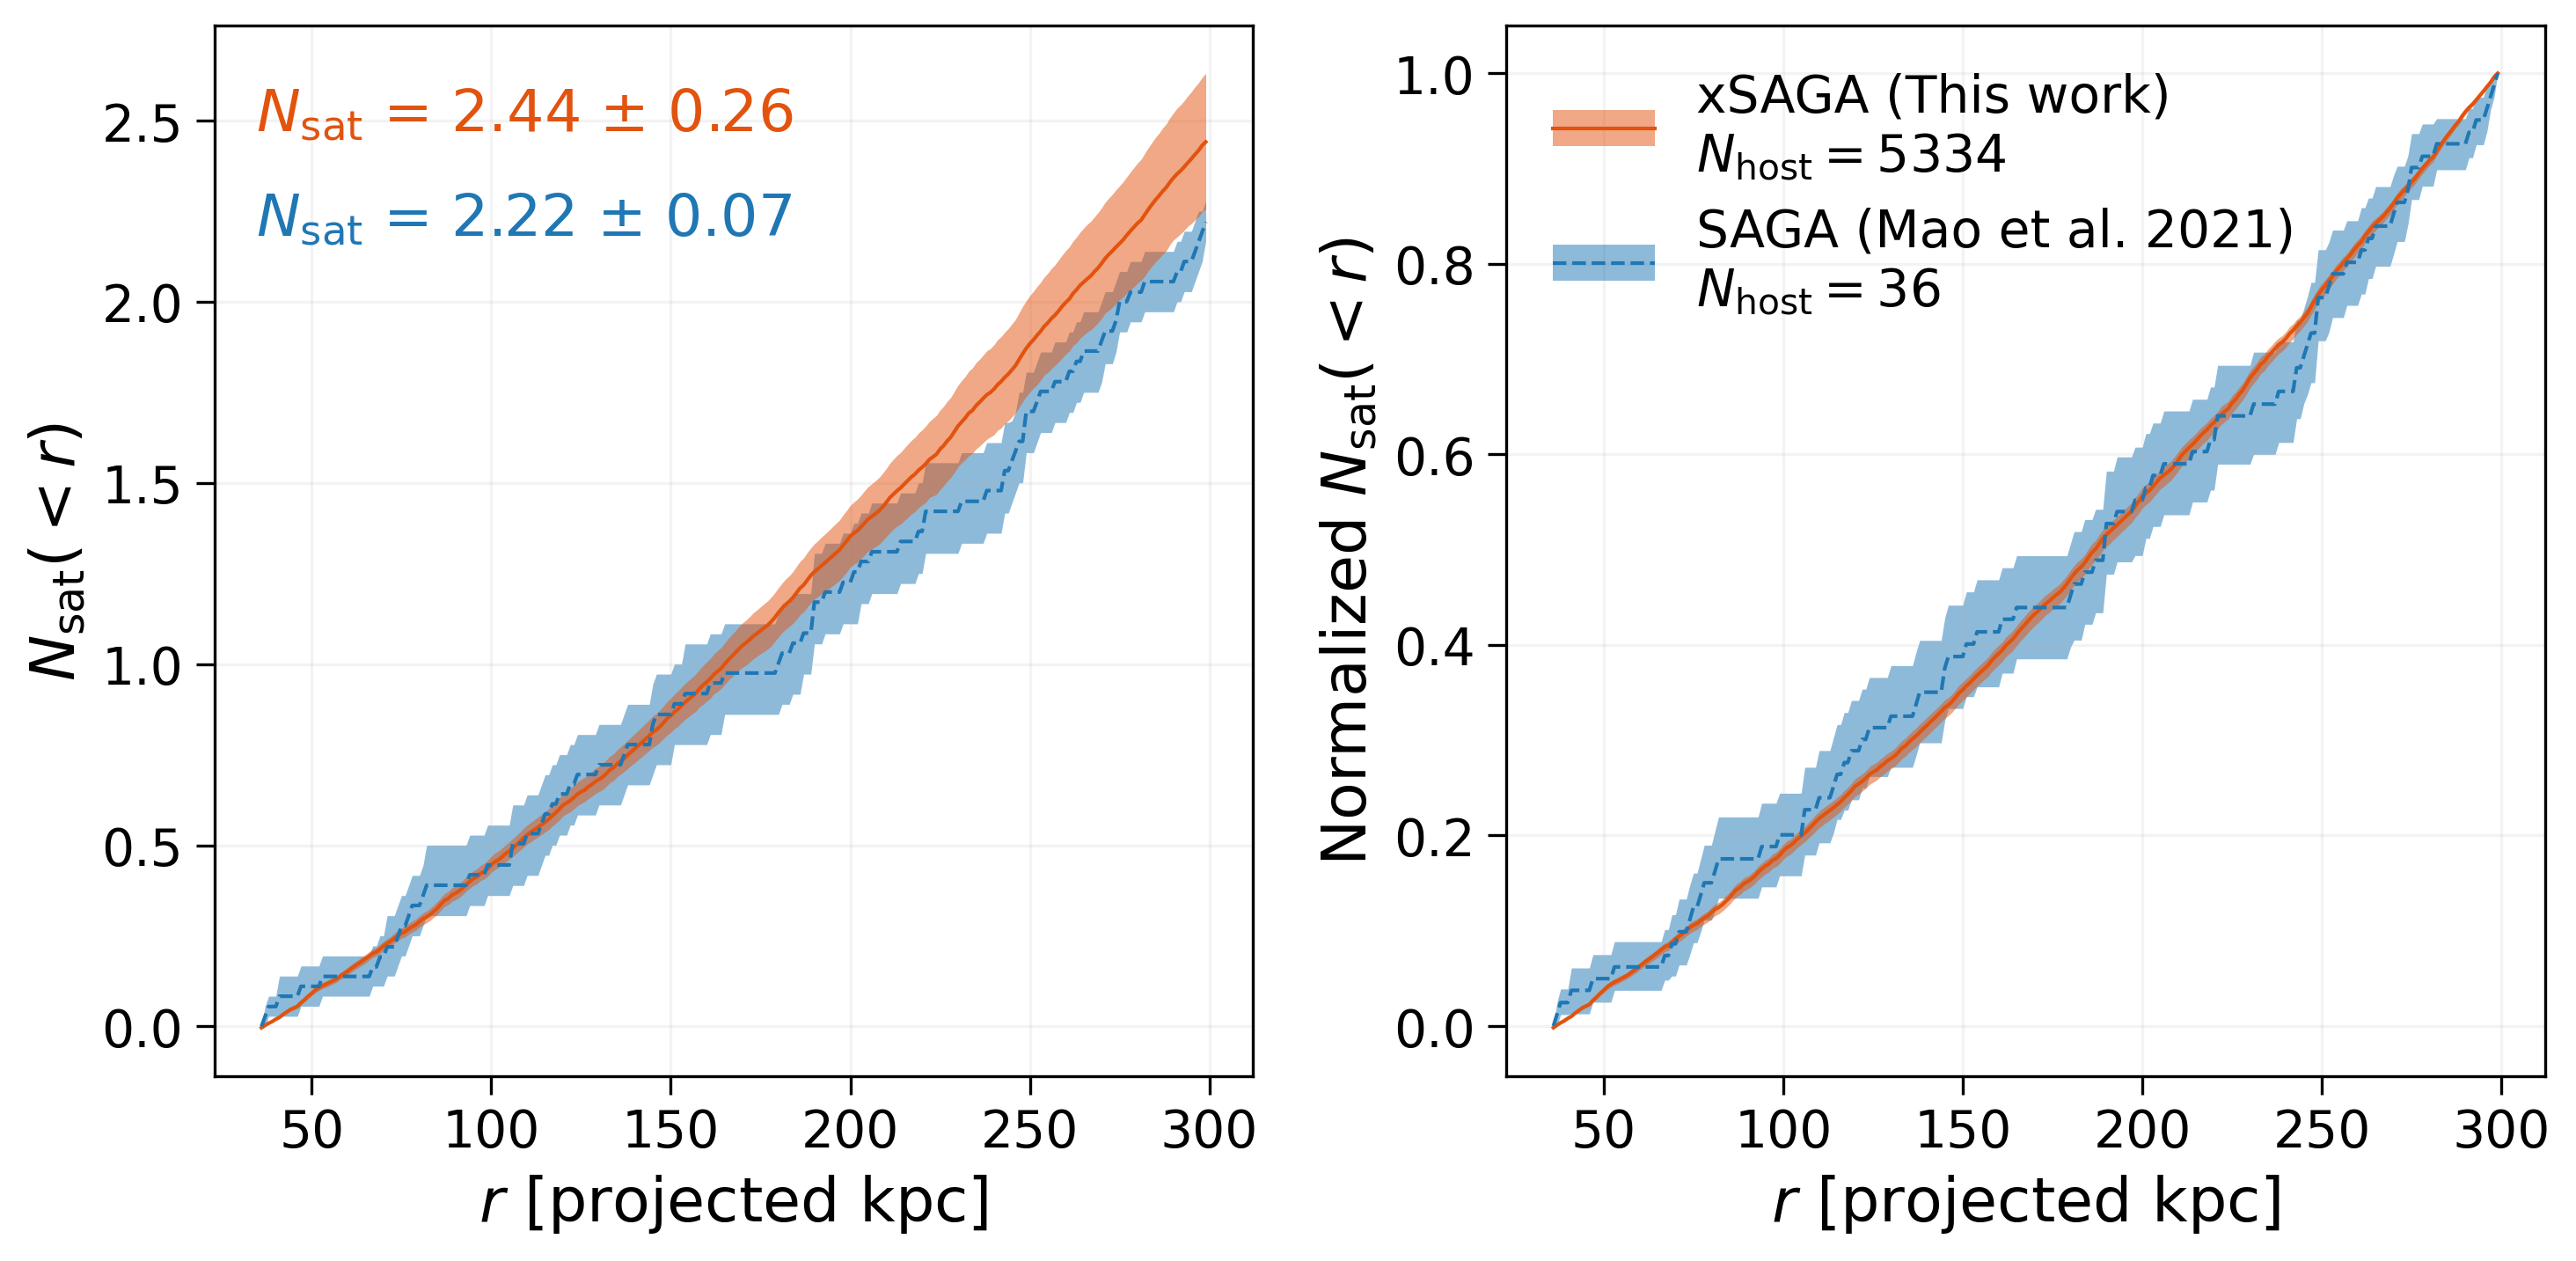

In [50]:
plot_xsaga_saga_comparison()
plt.savefig(figures_dir / 'xSAGA-SAGA_comparison.pdf')

## (Fig 7) Radial Profiles against morphology

In [54]:
def plot_radial_profile_by_host_morphology_alt(
    hosts,
    sats,
    radial_bins=np.arange(36, 300, 1),
    corrected=True,
    cumulative=True,
    normalize=False,
    areal_density=False,
    N_boot=None,
    sigma_smooth=None,
    sersic_n_low=(0, 2.5),
    sersic_n_high=(3, 6),
    mass_min=9.5,
    mass_max=11.0,
    dmass=0.5,
    fname="radial_profile-by-host_morphology-alt",
):
    """Creates two satellite radial profile plots based on a split in host morphology.

    Parameters
        hosts : pd.DataFrame
            DataFrame of hosts, which is assumed to be pre-filtered using
            cuts at top of this script.
        sats : pd.DataFrame
            DataFrame of satellites, also assumed to be filtered.
        radial_bins : 1d array-like
            A list or array of (maximum) projected radii.
        corrected : bool
            If true, correct by dividing by the completeness (0.600) and subtracting
            the number of interlopers based on a constant false positive surface
            density (3.04 per deg^2).
        cumulative : bool
            Toggles whether to plot the satellite number within a given projected
            radius versus at a given radius.
        normalize : bool
            Toggles whether to divide the curves by the total number of satellites
        areal_density : bool
            Toggles whether to divide by the annular surface area at each radius.
        N_boot : int
            The number of bootstrap resamples (for estimating uncertainties).
            Can also be `None` if boostrapping is not wanted.
        sersic_n_low : tuple(float, float)
            A pair of min and max Sersic indices to define the disk morphology.
        sersic_n_high : tuple(float, float)
            A pair of min and max Sersic indices to define the elliptical morphology.
        mass_min : float
            The minimum host (log) mass.
        mass_max : float
            The maximum host (log) mass.
        dmass : float
            The interval per mass bin.
        fname : str
            The name of the output figure (JPG format), to be saved in the directory
            `./results/xSAGA/plots/profiles/`.
    """

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300, sharey=True)
    mass_bins = np.arange(mass_min, mass_max, dmass)

    for sersic_n_range, label in zip([sersic_n_low, sersic_n_high], ['disk', 'elliptical']):
        n1, n2 = sersic_n_range
        q_sersic_n = Query(f"SERSIC_N_NSA > {n1}", f"SERSIC_N_NSA < {n2}")

        for m1, m2 in zip(mass_bins, mass_bins + dmass):
            q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")

            # combine morphology and mass queries
            q = q_sersic_n & q_mass
            satellite_separations = q.filter(sats).sep.values

            try:
                # compute sat cumulative profile or bootstrapped profile
                if N_boot is None:
                    profile = compute_radial_profile(satellite_separations, radial_bins)
                    profile = profile / q.count(hosts)

                    if sigma_smooth is not None:
                        profile = smooth(profile, sigma_smooth)

                    # correct using completeness and interlopers
                    if corrected:
                        interloper_profile = compute_interloper_profile(
                            q.filter(sats).z_NSA,
                            radial_bins,
                            interloper_surface_density=3.04,
                        )

                        nonsatellite_profile = compute_nonsatellite_profile(
                            hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz,
                            radial_bins,
                        )

                        profile = (
                            profile / 0.600 - interloper_profile - nonsatellite_profile
                        )

                    if areal_density:
                        surface_area = (
                            np.pi * np.gradient(radial_bins ** 2, edge_order=2) * 1e-6
                        )
                        profile = profile / surface_area

                    if not cumulative:
                        profile = np.gradient(profile, radial_bins)

                    if normalize:
                        profile /= profile.max()

                    ax.plot(
                        radial_bins,
                        profile,
                        c=mass2color((m1 + m2) / 2),
                        label=f"${m1}-{m2}$",
                        lw=3,
                    )
                else:
                    assert isinstance(N_boot, int), "Please enter an integer `N_boot`."
                    profile_bootstrapped = bootstrap(
                        satellite_separations,
                        bootfunc=partial(
                            compute_radial_profile, radial_bins=radial_bins
                        ),
                        bootnum=N_boot,
                    )

                    profile_bootstrapped = profile_bootstrapped / q.count(hosts)

                    if sigma_smooth is not None:
                        profile_bootstrapped = smooth(
                            profile_bootstrapped, sigma_smooth
                        )

                    if corrected:
                        interloper_profile = compute_interloper_profile(
                            q.filter(sats).z_NSA,
                            radial_bins,
                        )

                        interloper_profile_bootstrapped = rng.choice(
                            interloper_profile, size=N_boot, replace=True
                        )

                        nonsatellite_profile = compute_nonsatellite_profile(
                            hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz,
                            radial_bins,
                        )

                        nonsatellite_profile_bootstrapped = rng.choice(
                            nonsatellite_profile, size=N_boot, replace=True
                        )

                        profile_bootstrapped = (
                            profile_bootstrapped / 0.600
                            - interloper_profile_bootstrapped
                            - nonsatellite_profile_bootstrapped
                        )

                    if areal_density:
                        surface_area = (
                            np.pi * np.gradient(radial_bins ** 2, edge_order=2) * 1e-6
                        )
                        profile_bootstrapped = profile_bootstrapped / surface_area

                    if not cumulative:
                        profile_bootstrapped = np.gradient(
                            profile_bootstrapped, radial_bins, axis=1
                        )

                    if normalize:
                        profile_bootstrapped /= profile_bootstrapped.max(1)[
                            :, np.newaxis
                        ]

                    ax.fill_between(
                        radial_bins,
                        *np.quantile(profile_bootstrapped, [0.16, 0.84], axis=0),
                        color=mass2color((m1 + m2) / 2),
                        label=f"{label}, ${m1}-{m2}$",
                        lw=0.3,
                        hatch=None if label == "disk" else '//////',
                        facecolor=mass2color((m1 + m2) / 2) if label == "disk" else 'white',
                        alpha=0.7,
                    )

            except ValueError:
                continue

        ax.grid(alpha=0.15)

    xlabel = "$r$ [projected kpc]"
    ylabel = (
        ("Normalized " if normalize else "")
        + (r"$\Sigma_{\rm sat}$" if areal_density else r"$N_{\rm sat}$")
        + ("(r)" if not cumulative else "(<r)")
        + (" [Mpc$^{-2}$]" if areal_density else "")
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="upper left", fontsize=12)

    fig.tight_layout()
    fig.savefig(results_dir / f"plots/profiles/{fname}.png")


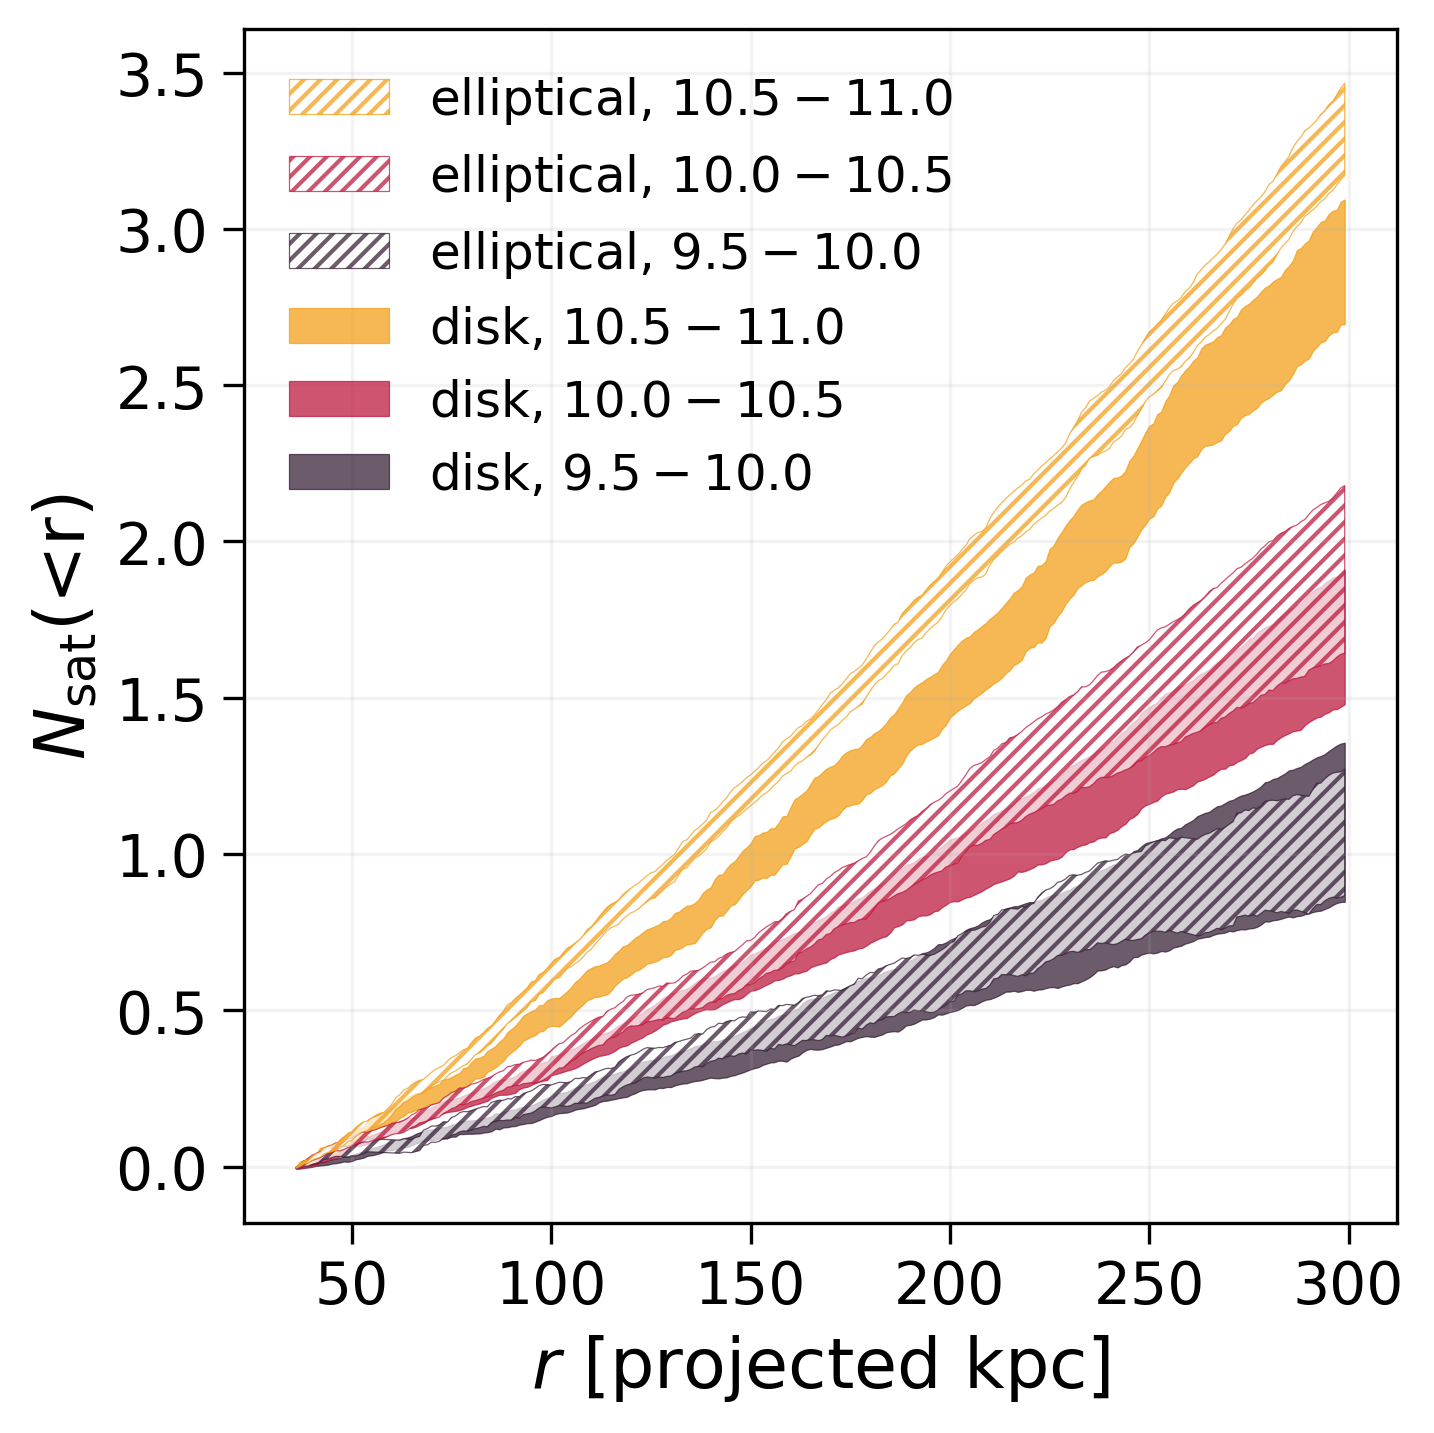

In [55]:
with rng_context:
    plot_radial_profile_by_host_morphology_alt(
        hosts,
        sats,
        radial_bins=np.arange(36, 300, 1),
        cumulative=True,
        N_boot=N_boot,
        fname="radial_profile-by-host_morphology-alt",
    )
    plt.savefig(figures_dir / "radial_profile-by-host_morphology-alt.pdf")


## (Fig 8) Radial distributions against morphology

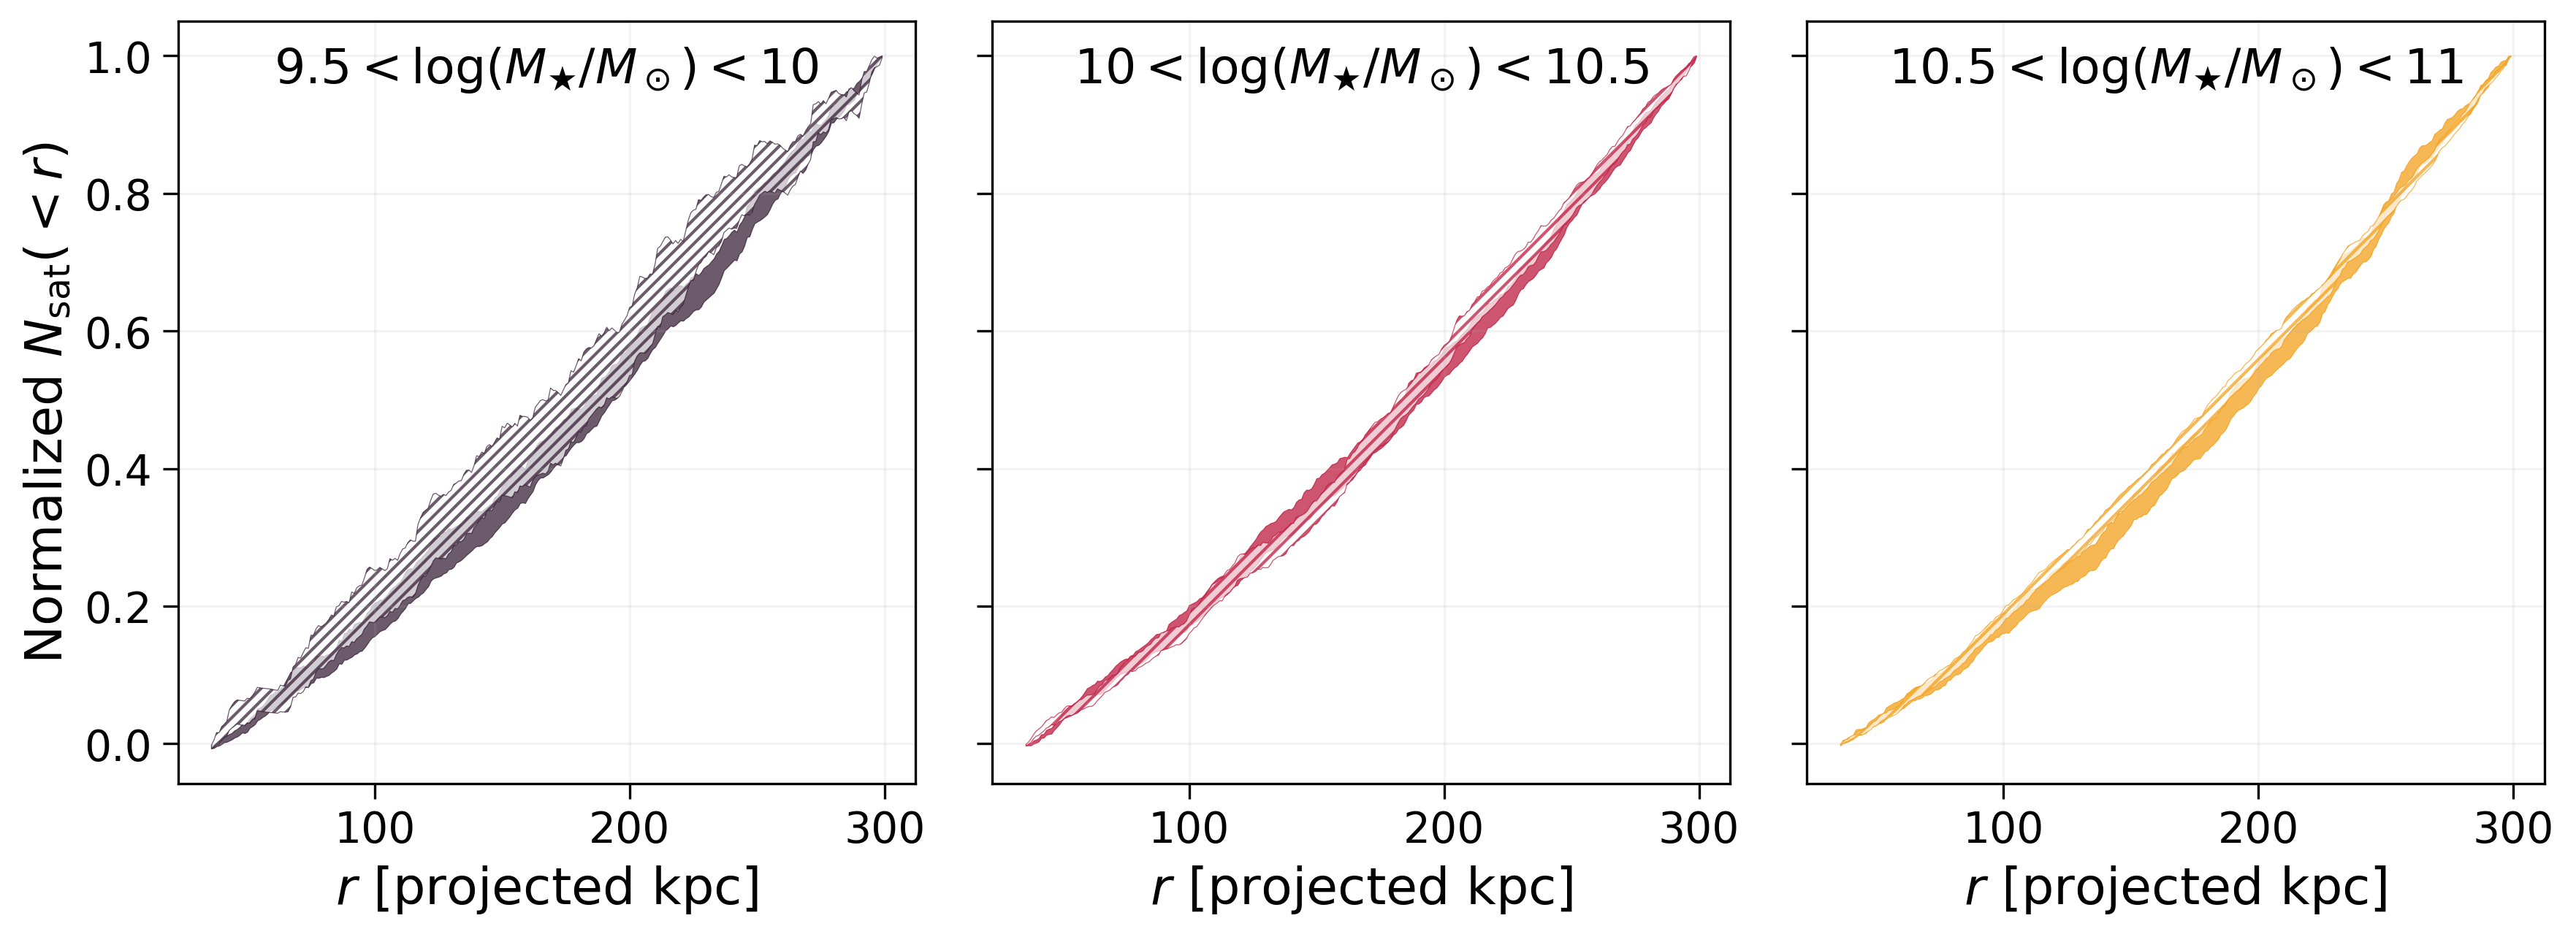

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), dpi=300, sharey=True)


N_boot = 100
radial_bins = np.arange(36, 300, 1)
mass_bins = np.arange(9.5, 11, 0.5)

for i, (ax, m1, m2) in enumerate(zip(axes.flat, mass_bins, mass_bins + 0.5)):
    q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    for n1, n2, label in zip([0, 3], [2.5, 6], ['disk', 'elliptical']):
            
        q = Query(f"SERSIC_N_NSA > {n1}", f"SERSIC_N_NSA < {n2}") & q_mass
        satellite_separations = q.filter(sats).sep.values

            
        profile_bootstrapped = bootstrap(
            satellite_separations,
            bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
            bootnum=N_boot,
        )

        profile_bootstrapped = profile_bootstrapped / q.count(hosts)

        interloper_profile = compute_interloper_profile(
            q.filter(sats).z_NSA,
            radial_bins,
        )

        interloper_profile_bootstrapped = rng.choice(
            interloper_profile, size=N_boot, replace=True
        )

        nonsatellite_profile = compute_nonsatellite_profile(
            hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
        )

        nonsatellite_profile_bootstrapped = rng.choice(
            nonsatellite_profile, size=N_boot, replace=True
        )

        profile_bootstrapped = (
            profile_bootstrapped / 0.600
            - interloper_profile_bootstrapped
            - nonsatellite_profile_bootstrapped
        )

        # normalize
        profile_bootstrapped /= profile_bootstrapped.max(1, keepdims=True)

        ax.fill_between(
            radial_bins,
            *np.quantile(profile_bootstrapped, [0.16, 0.84], axis=0),
            color=mass2color((m1 + m2) / 2),
            label=f"{label}, ${m1}-{m2}$",
            lw=0.3,
            hatch=None if label == "disk" else '//////',
            facecolor=mass2color((m1 + m2) / 2) if label == "disk" else 'white',
            alpha=0.7,
        )
    ax.grid(alpha=0.15)
    ax.set_xlabel("$r$ [projected kpc]")
    ax.text(
        0.5,
        0.92,
        r"${0:g} < \log(M_★/M_\odot) < {1:g}$".format(m1, m2),
        transform=ax.transAxes,
        ha="center",
        fontsize=16,
    )
axes.flat[0].set_ylabel(r"Normalized $N_{\rm sat}(<r)$")
# fig.legend(
#     *axes.flat[-1].get_legend_handles_labels(),
#     loc="upper left",
#     fontsize=14,
#     title="$\Delta m_{r,*}$",
#     title_fontsize=16,
#     bbox_to_anchor=(0.075, 0.885)
# )
fig.tight_layout()

plt.savefig(figures_dir / "normalized-radial_profile-by-morphology.pdf")


## (Fig 9) Areal density radial profiles against mass and morphology

In [59]:
def plot_areal_density_by_morphology():
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300, sharey=False)

    N_boot = 100
    dmass = 0.5
    mass_bins = np.arange(9.5, 11, dmass)

    COMPLETENESS = 0.600

    dr = 25
    radial_bins = np.arange(36, 300, dr)
    surface_area = np.pi * ((radial_bins+dr/2)**2  - (radial_bins.min() - dr/2)**2) / 1e6

    morphology_queries = [Query('SERSIC_N_NSA < 2.5'), Query('SERSIC_N_NSA > 3')]

    for q_morph, label in zip(morphology_queries, ['disk', 'elliptical']):
        for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):
            q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
            q = q_morph & q_mass

            satellite_separations = q.filter(sats).sep.values


            profile_bootstrapped = bootstrap(
                satellite_separations,
                bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
                bootnum=N_boot,
            )

            profile_bootstrapped = profile_bootstrapped / q.count(hosts)

            interloper_profile = compute_interloper_profile(
                q.filter(sats).z_NSA,
                radial_bins,
            )

            interloper_profile_bootstrapped = rng.choice(
                interloper_profile, size=N_boot, replace=True
            )

            nonsatellite_profile = compute_nonsatellite_profile(
                hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
            )

            nonsatellite_profile_bootstrapped = rng.choice(
                nonsatellite_profile, size=N_boot, replace=True
            )

            profile_bootstrapped = (
                profile_bootstrapped / COMPLETENESS
                - interloper_profile_bootstrapped
                - nonsatellite_profile_bootstrapped
            )

            pdf = np.gradient(profile_bootstrapped, radial_bins, axis=1, edge_order=2)
            areal_pdf = pdf / surface_area * dr

            ax.fill_between(
                radial_bins,
                *np.quantile(areal_pdf, [0.16, 0.84], axis=0),
                color=mass2color((m1 + m2) / 2),
                label=f"{label}, ${m1}-{m2}$",
                lw=0.3,
                hatch=None if label == "disk" else '//////',
                facecolor=mass2color((m1 + m2) / 2) if label == "disk" else 'white',
                alpha=0.7,
                zorder=3,
            )
            #     ax.plot(radial_bins, profile_bootstrapped.mean(0), color=mass2color((m1+m2)/2), lw=2, ls='--')
        ax.grid(alpha=0.2)
        ax.set_xlabel('$r$ [projected kpc]', fontsize=14)
        ax.set_xlim(20, 305)
#         ax.set_ylim(-1, 41)
    #     ax.text(0.5, 0.9, label, ha='center', fontsize=16, transform=ax.transAxes)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc="upper right", fontsize=12)

    ax.set_ylabel(r'$\Sigma_{\rm sat}(r)$ [Mpc$^{-2}$]', fontsize=14)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    fig.tight_layout()

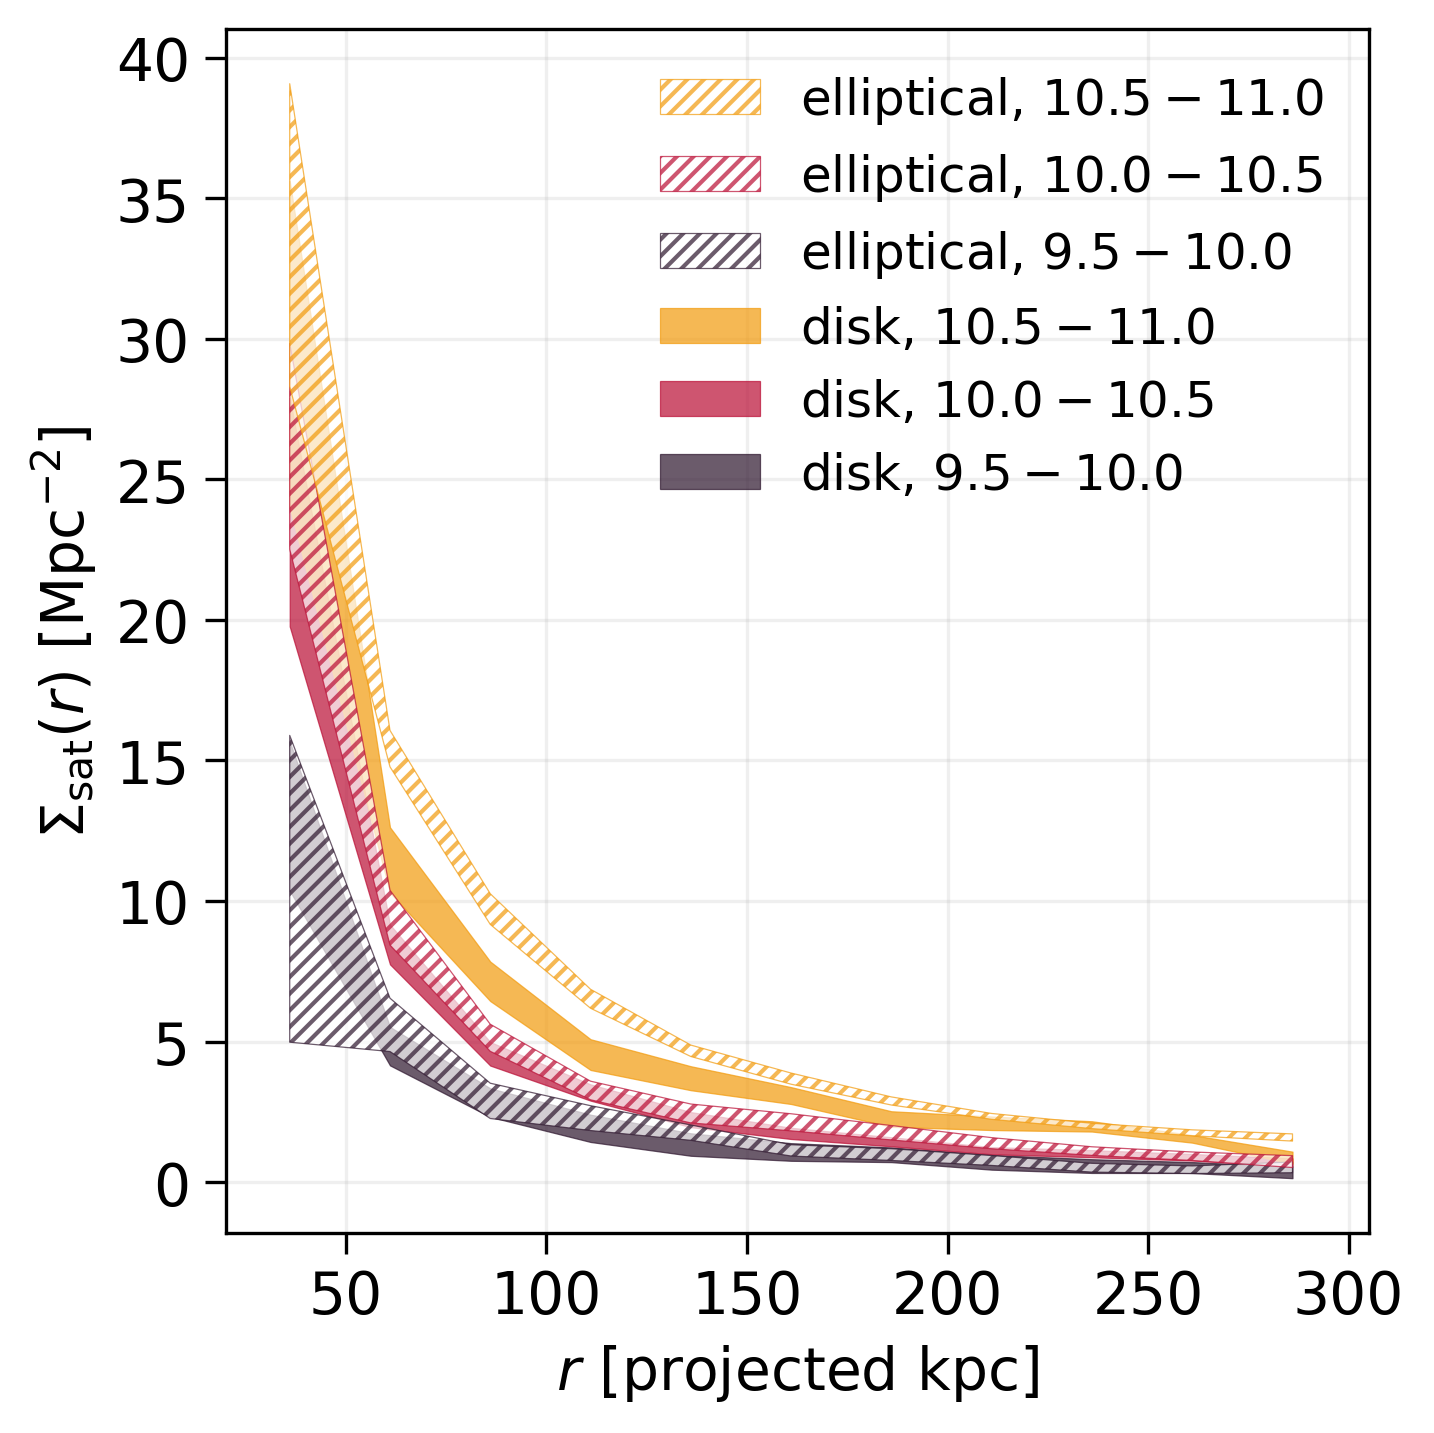

In [60]:
with rng_context:
    plot_areal_density_by_morphology()
    plt.savefig(figures_dir / "areal_density_pdf-by-host_morphology.pdf")

## Magnitude gap ($\Delta m_{r,*}$)

In [23]:
hosts, sats = load_hosts_and_sats()

# impose cuts
hosts = HOST_QUERY.filter(hosts)
sats = (HOST_QUERY & SAT_QUERY).filter(sats)

# isolate hosts and sats
hosts = isolate_hosts(hosts, delta_mass=0.0, delta_z=0.005, delta_d=1.0)
sats = sats[sats.NSAID.isin(hosts.index)].copy()

In [24]:
N_boot = 100

sats["r_abs"] = sats.r0 - cosmo.distmod(sats.z_NSA)

sats_subset = sats.join(
    sats.groupby("NSAID").M_r.min().rename("M_r_sat"),
    on="NSAID",
)

hosts_subset = hosts.join(
    sats_subset.set_index("NSAID", drop=True).M_r_sat, on="NSAID", how="left"
).drop_duplicates()

hosts_subset['magnitude_gap'] = hosts_subset.M_r_sat - hosts_subset.M_r_NSA
sats_subset['magnitude_gap'] = sats_subset.M_r_sat - sats_subset.M_r_NSA

### (Fig 10) Satellite richness vs magnitude gap

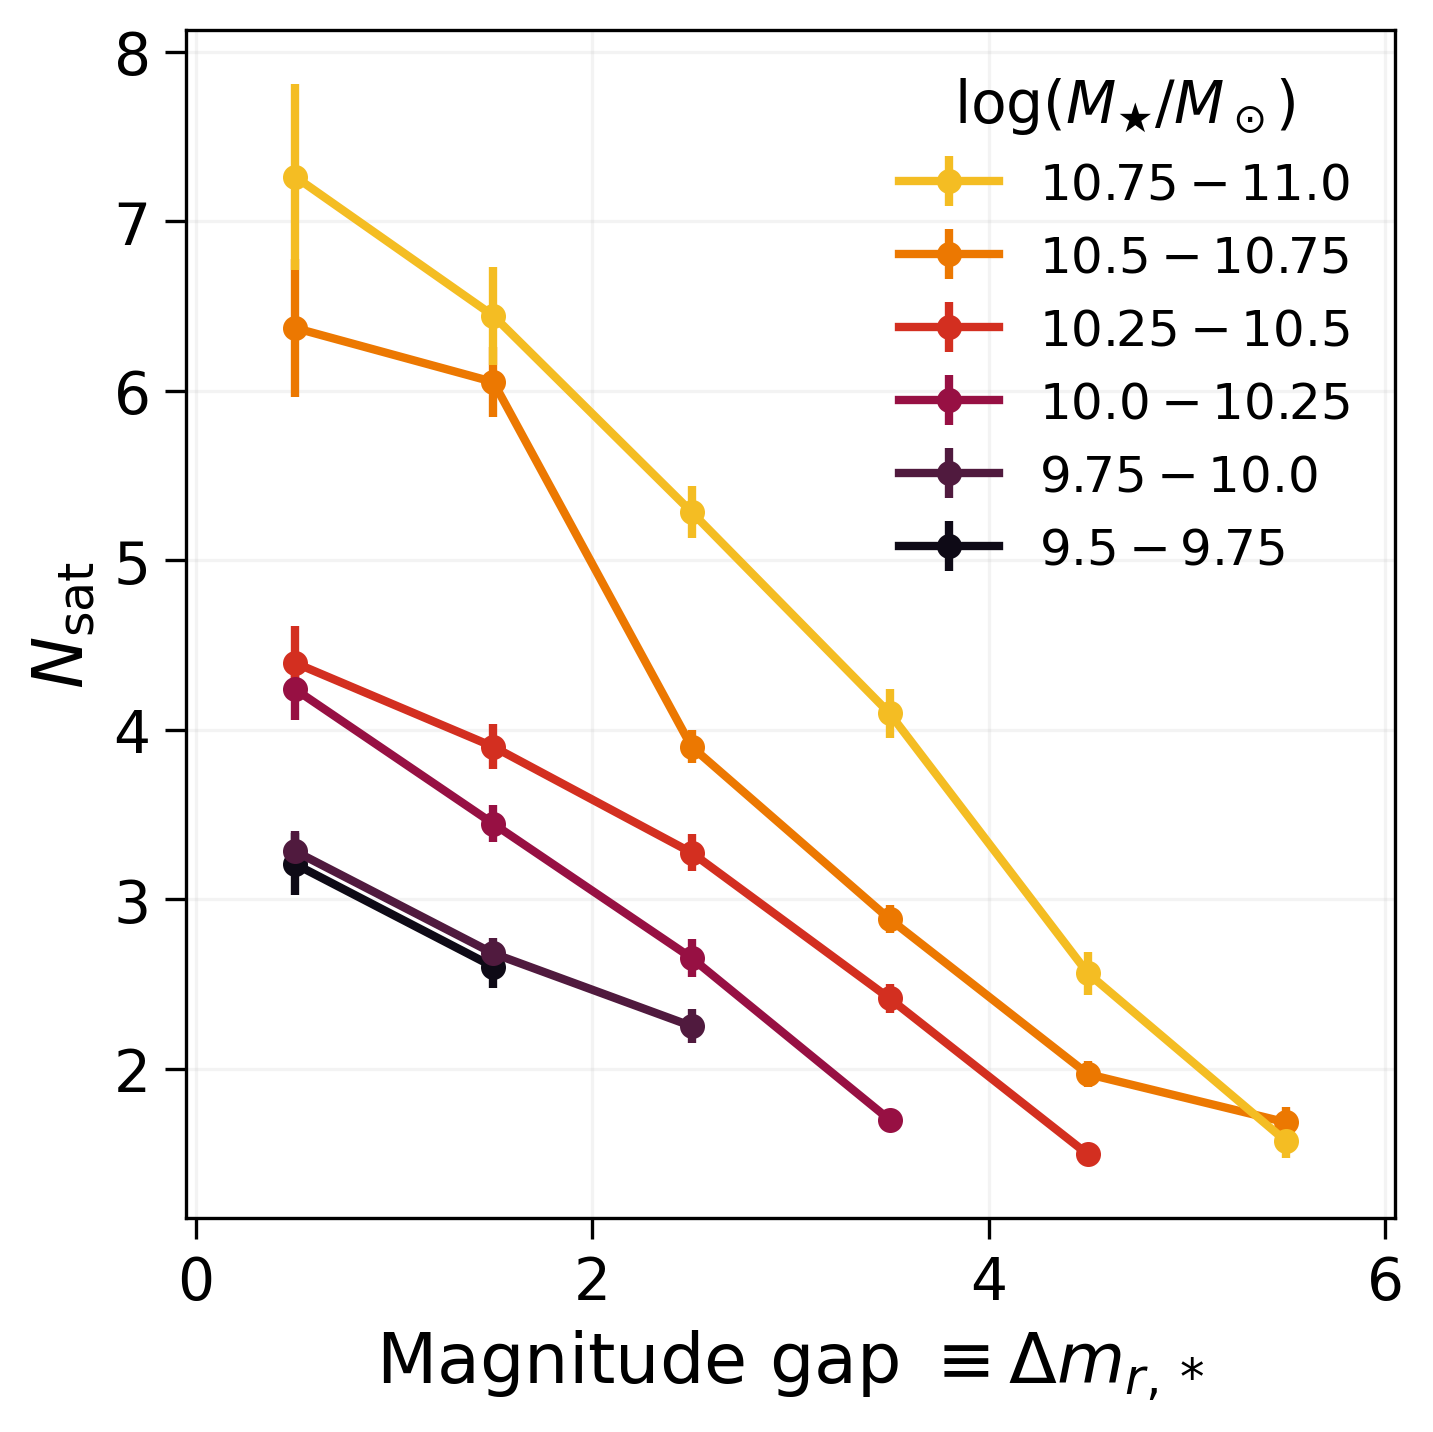

In [66]:
plt.figure(figsize=(5, 5), dpi=300)

dmass = 0.25
mass_bins = np.arange(9.5, 11, dmass)

for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):

    q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    boot_mag_gap = []
    
    magnitude_gap_bins = np.arange(0, 6, 1)
    for j, [mag1, mag2] in enumerate(zip(magnitude_gap_bins, magnitude_gap_bins + 1)):

        q_mag = Query(f"magnitude_gap > {mag1}", f"magnitude_gap < {mag2}")
        number_of_hosts = (q_mag & q_mass).count(hosts_subset)

        if mag2 > (i + 2):
            boot_mag_gap.append(np.full((N_boot,), np.nan))
        else:
            boot_mag_gap.append(
                f(sats_subset, q_mag.filter(hosts_subset), q_mass)
            )


    boot_mag_gap = np.array(boot_mag_gap)
    plt.errorbar(
        magnitude_gap_bins[:len(boot_mag_gap)] + 0.5, 
        boot_mag_gap.mean(1), 
        boot_mag_gap.std(1), 
        c=mass2color((m1+m2)/2), 
        markersize=5,
        ls='-',
        lw=2,
        fmt='o', 
        label=f'${m1} - {m2}$'
    )

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=12, framealpha=1, title=r'$\log(M_★/M_\odot)$', title_fontsize=14,)
plt.grid(alpha=0.15)
plt.xlim(-0.05, 6.05)
# plt.ylim(0.9, 8.1)

plt.xlabel(r'Magnitude gap $\equiv \Delta m_{r,*}$')
plt.ylabel(r'$N_{\rm sat}$')
plt.tight_layout()

plt.savefig(figures_dir / "satellite_richness-by-magnitude_gap.pdf")

### (Fig 11) Radial distributions vs magnitude gap

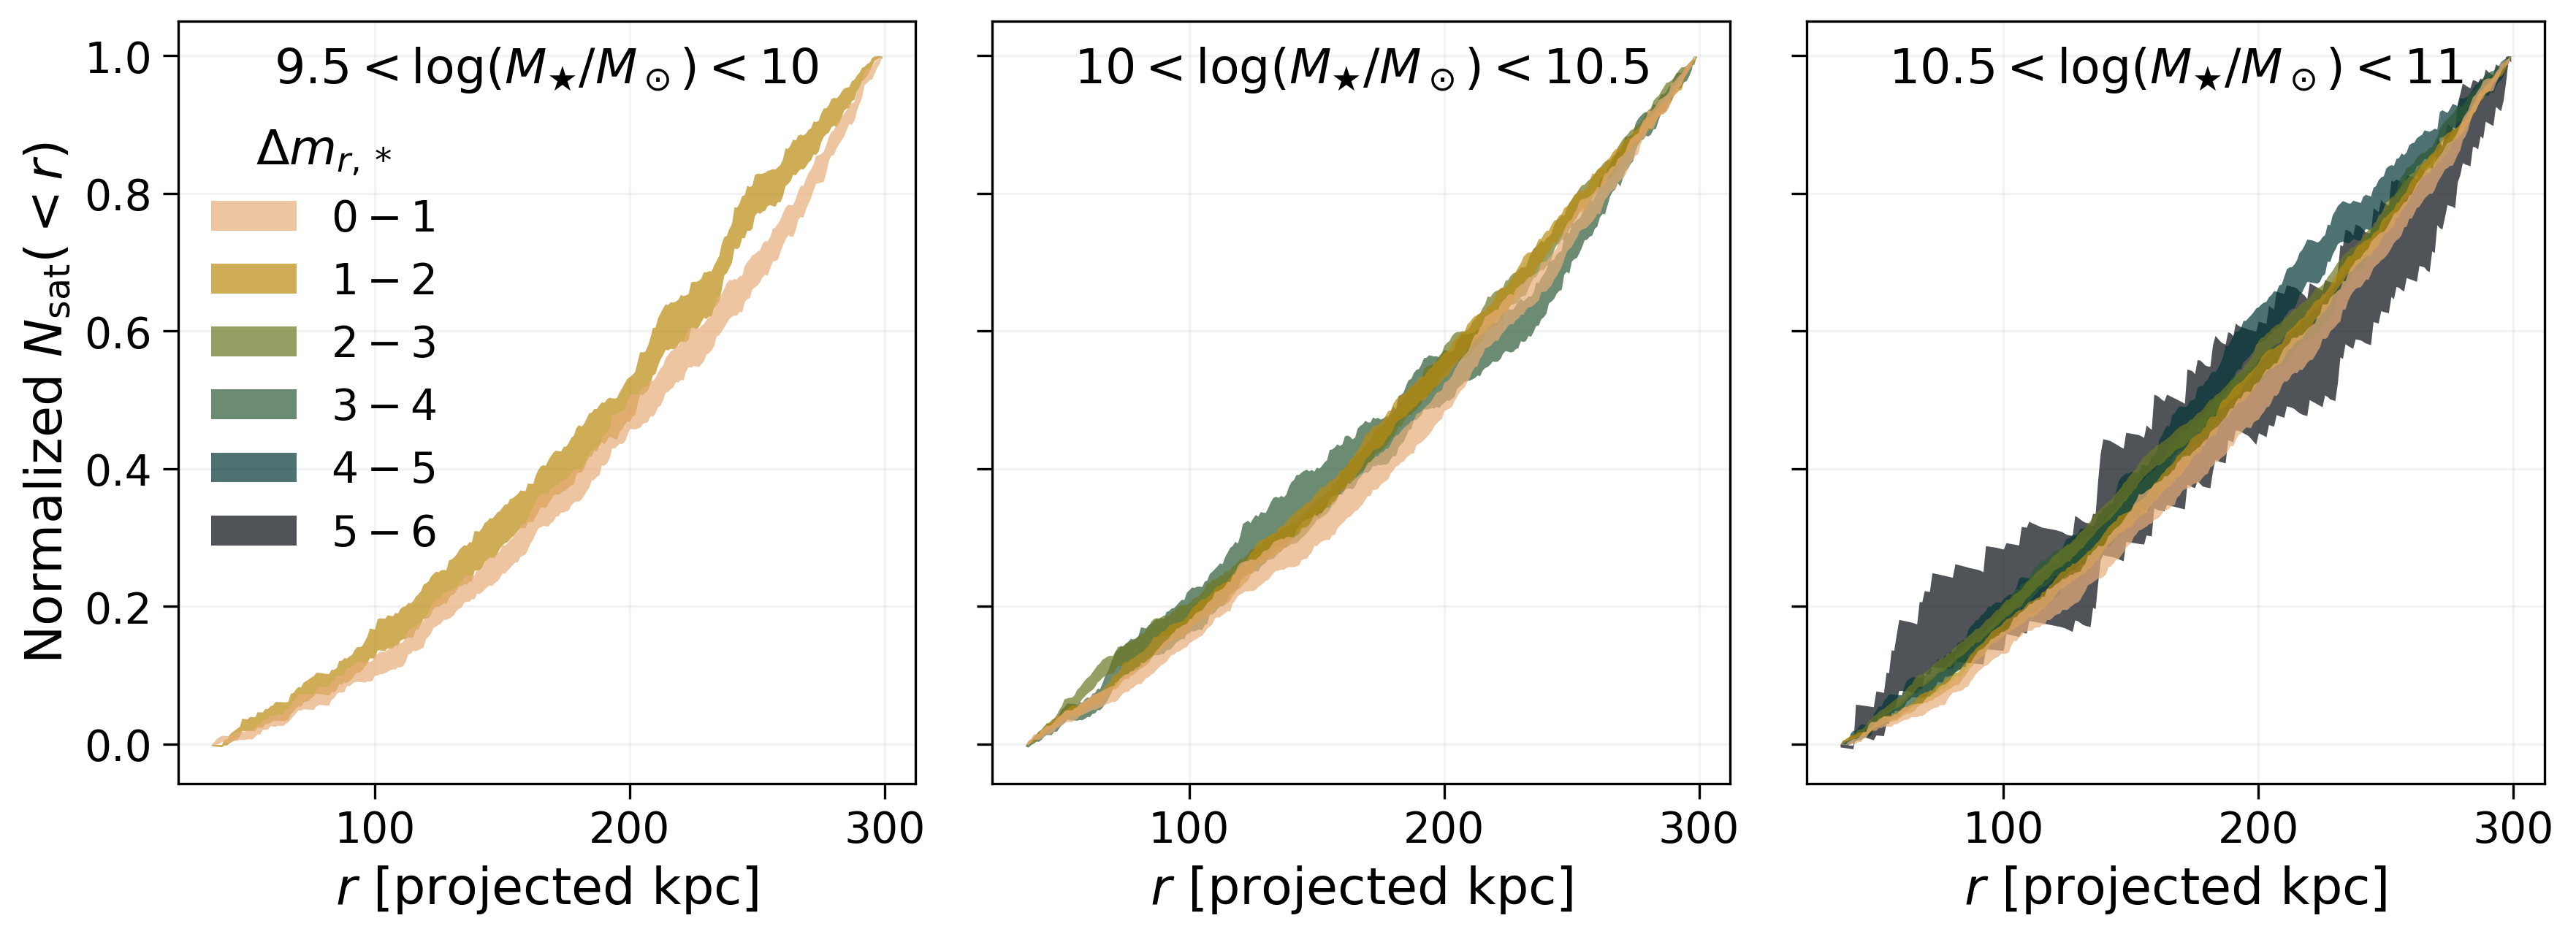

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), dpi=300, sharey=True)


N_boot = 100
radial_bins = np.arange(36, 300, 1)
mass_bins = np.arange(9.5, 11, 0.5)
magnitude_gap_bins = np.arange(0, 6, 1)

for i, (ax, m1, m2) in enumerate(zip(axes.flat, mass_bins, mass_bins + 0.5)):
    q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    for mag1, mag2 in zip(magnitude_gap_bins, magnitude_gap_bins + 1):
            
        q = Query(f"magnitude_gap > {mag1}", f"magnitude_gap < {mag2}") & q_mass
        satellite_separations = q.filter(sats_subset).sep.values

        if (len(satellite_separations) < 50) or (mag2 > 2 * (i + 1)):
            continue
            
        profile_bootstrapped = bootstrap(
            satellite_separations,
            bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
            bootnum=N_boot,
        )

        profile_bootstrapped = profile_bootstrapped / q.count(hosts_subset)

        interloper_profile = compute_interloper_profile(
            q.filter(sats_subset).z_NSA,
            radial_bins,
        )

        interloper_profile_bootstrapped = rng.choice(
            interloper_profile, size=N_boot, replace=True
        )

        nonsatellite_profile = compute_nonsatellite_profile(
            hosts_subset.loc[q.filter(sats_subset).NSAID].N_unrelated_lowz, radial_bins
        )

        nonsatellite_profile_bootstrapped = rng.choice(
            nonsatellite_profile, size=N_boot, replace=True
        )

        profile_bootstrapped = (
            profile_bootstrapped / 0.600
            - interloper_profile_bootstrapped
            - nonsatellite_profile_bootstrapped
        )

        # xSAGA
        ax.fill_between(
            radial_bins,
            *np.quantile(profile_bootstrapped / profile_bootstrapped.max(1, keepdims=True), [0.16, 0.84], axis=0),
            color=gap2color((mag1 + mag2) / 2),
            label=f"${mag1}-{mag2}$",
            lw=0,
            alpha=0.7,
            zorder=10-mag1,
        )
    ax.grid(alpha=0.15)
    ax.set_xlabel("$r$ [projected kpc]")
    ax.text(
        0.5,
        0.92,
        r"${0:g} < \log(M_★/M_\odot) < {1:g}$".format(m1, m2),
        transform=ax.transAxes,
        ha="center",
        fontsize=16,
    )
axes.flat[0].set_ylabel(r"Normalized $N_{\rm sat}(<r)$")
fig.legend(
    *axes.flat[-1].get_legend_handles_labels(),
    loc="upper left",
    fontsize=14,
    title="$\Delta m_{r,*}$",
    title_fontsize=16,
    bbox_to_anchor=(0.075, 0.885)
)
fig.tight_layout()

plt.savefig(figures_dir / "normalized-radial_profile-by-magnitude_gap.pdf")


# Determine halo mass and virial radius

In [31]:
# fit only to central galaxies (see second row in Table J1 of Behroozi+19)
UniverseMachine_params = {
    "alpha": 1.957,
    "beta": 0.474,
    "gamma": -1.065,
    "delta": 0.386,
    "epsilon": -1.435,
    "M0": 12.081,
}

def SHMR(M_halo, params):
    """Stellar Mass Halo Mass Relation from Behroozi+19. See Appendix J."""
    
    x = M_halo - params["M0"]
    
    return (
        params["M0"] + params["epsilon"] 
        - np.log10(10**(-params["alpha"]*x) + 10**(-params["beta"]*x))
        + 10**params["gamma"]*np.exp(-0.5 * (x / params["delta"])**2)
    )

# tabulate
class StellarMassHaloMassRelation():
    def __init__(self):
        self.halo_masses = np.arange(11, 15, 0.001)
        self.stellar_masses = SHMR(self.halo_masses, UniverseMachine_params)
    
    def stellar_mass(self, M_halo):
        return self.stellar_masses[np.argmin((M_halo - self.halo_masses)**2)]

    def halo_mass(self, M_star):
        return self.halo_masses[np.argmin((M_star - self.stellar_masses)**2)]
    
    def R_vir(self, M_star=None, M_halo=None):
        if M_halo is None:
            if M_star is None:
                raise ValueError("Please enter M_star or M_halo")
            else:
                M_halo = self.halo_mass(M_star)
                return self.R_vir(M_halo=M_halo)
        else:
            return mass_so.M_to_R(10**(M_halo), z=0, mdef='vir')
    


In [32]:
B19 = StellarMassHaloMassRelation()

print(B19.R_vir(M_star=9.5))
print(B19.R_vir(M_star=11))
print(B19.R_vir(M_halo=12.))

140.13671215656834
396.78196511752026
204.11985790378375


## Redo host-satellite matching

In [33]:
lowz_file = results_dir / "lowz-p0_5.parquet"
lowz = pd.read_parquet(lowz_file)

In [34]:
hosts_file = results_dir / "hosts-nsa.parquet"
nsa = pd.read_parquet(hosts_file)
hosts = Query("mass_GSE > 9.5").filter(nsa)

lowz, hosts_x_lowz = remove_hosts_from_lowz(hosts, lowz, savefig=False)

In [35]:
hosts = Query("z_NSA <= 0.03").filter(hosts)
hosts = isolate_hosts(hosts)
hosts = Query("mass_GSE < 11").filter(hosts)

sats = assign_satellites_to_hosts(
    hosts, lowz, rank_by="mass_GSE", z_min=0.005, sep_max=400., savefig=False
)


In [37]:
sats['M_halo'] = [B19.halo_mass(M_star) for M_star in sats.mass_GSE]
sats['R_vir'] = [B19.R_vir(M_halo=M_halo) for M_halo in sats.M_halo]

hosts['M_halo'] = [B19.halo_mass(M_star) for M_star in hosts.mass_GSE]
hosts['R_vir'] = [B19.R_vir(M_halo=M_halo) for M_halo in hosts.M_halo]

In [38]:
sats = sats[sats.sep < sats.R_vir].copy()

## Radial distributions from $(0.26 - 1) \times R_{\rm vir}$

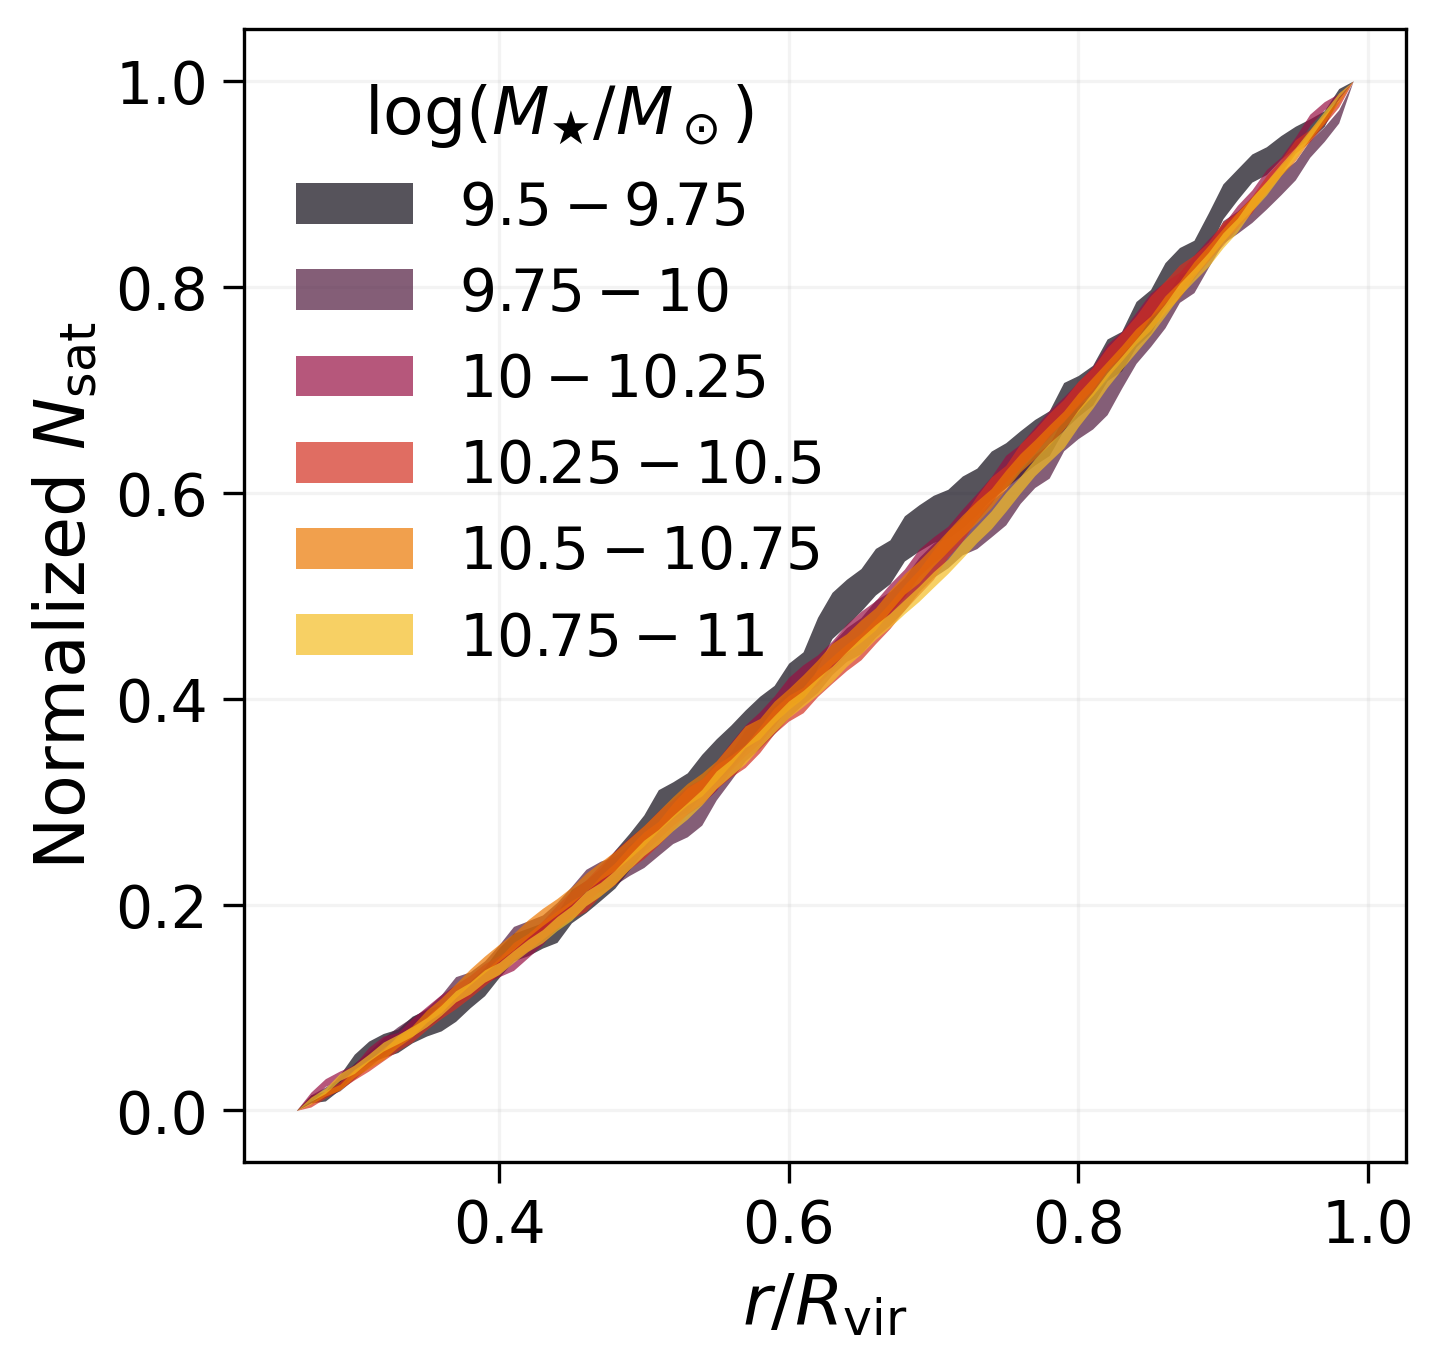

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)


dmass = 0.25
mass_bins = np.arange(9.5, 11, dmass)

for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):
    q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    satellite_separations = q.filter(sats).sep.values
    
    normalized_separations = (q.filter(sats).sep / q.filter(sats).R_vir).values
    
    radial_bins = np.arange(0.26, 1, 0.01)

    profile_bootstrapped = bootstrap(
        normalized_separations,
        bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
        bootnum=N_boot,
    )
    

    profile_bootstrapped = profile_bootstrapped / q.count(hosts)


    
    ax.fill_between(
        radial_bins,
        *np.quantile((profile_bootstrapped - profile_bootstrapped.min(1, keepdims=True)) / (profile_bootstrapped.max(1, keepdims=True) - profile_bootstrapped.min(1, keepdims=True)), [0.16, 0.84], axis=0),
        color=mass2color((m1 + m2) / 2),
        label=f"${m1:g} - {m2:g}$",
        lw=0,
        alpha=0.7,
        zorder=3,
    )
    
    
plt.xlabel('$r/R_{\\rm vir}$')
plt.ylabel('Normalized $N_{\\rm sat}$')

plt.legend(title=r'$\log(M_★/M_\odot)$', title_fontsize=16, loc='upper left')
plt.grid(alpha=0.15)

## (Fig 12) Satellite richness vs magnitude gap 

In [42]:
sats_subset.shape, hosts_subset.shape

((11449, 28), (7542, 24))

In [43]:
sats["M_r"] = sats.r0 - cosmo.distmod(sats.z_NSA).value

sats_subset = sats.join(
    sats.groupby("NSAID").M_r.min().rename("M_r_sat"),
    on="NSAID",
)

hosts_subset = hosts.join(
    sats_subset.set_index("NSAID", drop=True).M_r_sat, on="NSAID", how="left"
).drop_duplicates()

hosts_subset['magnitude_gap'] = hosts_subset.M_r_sat - hosts_subset.M_r_NSA

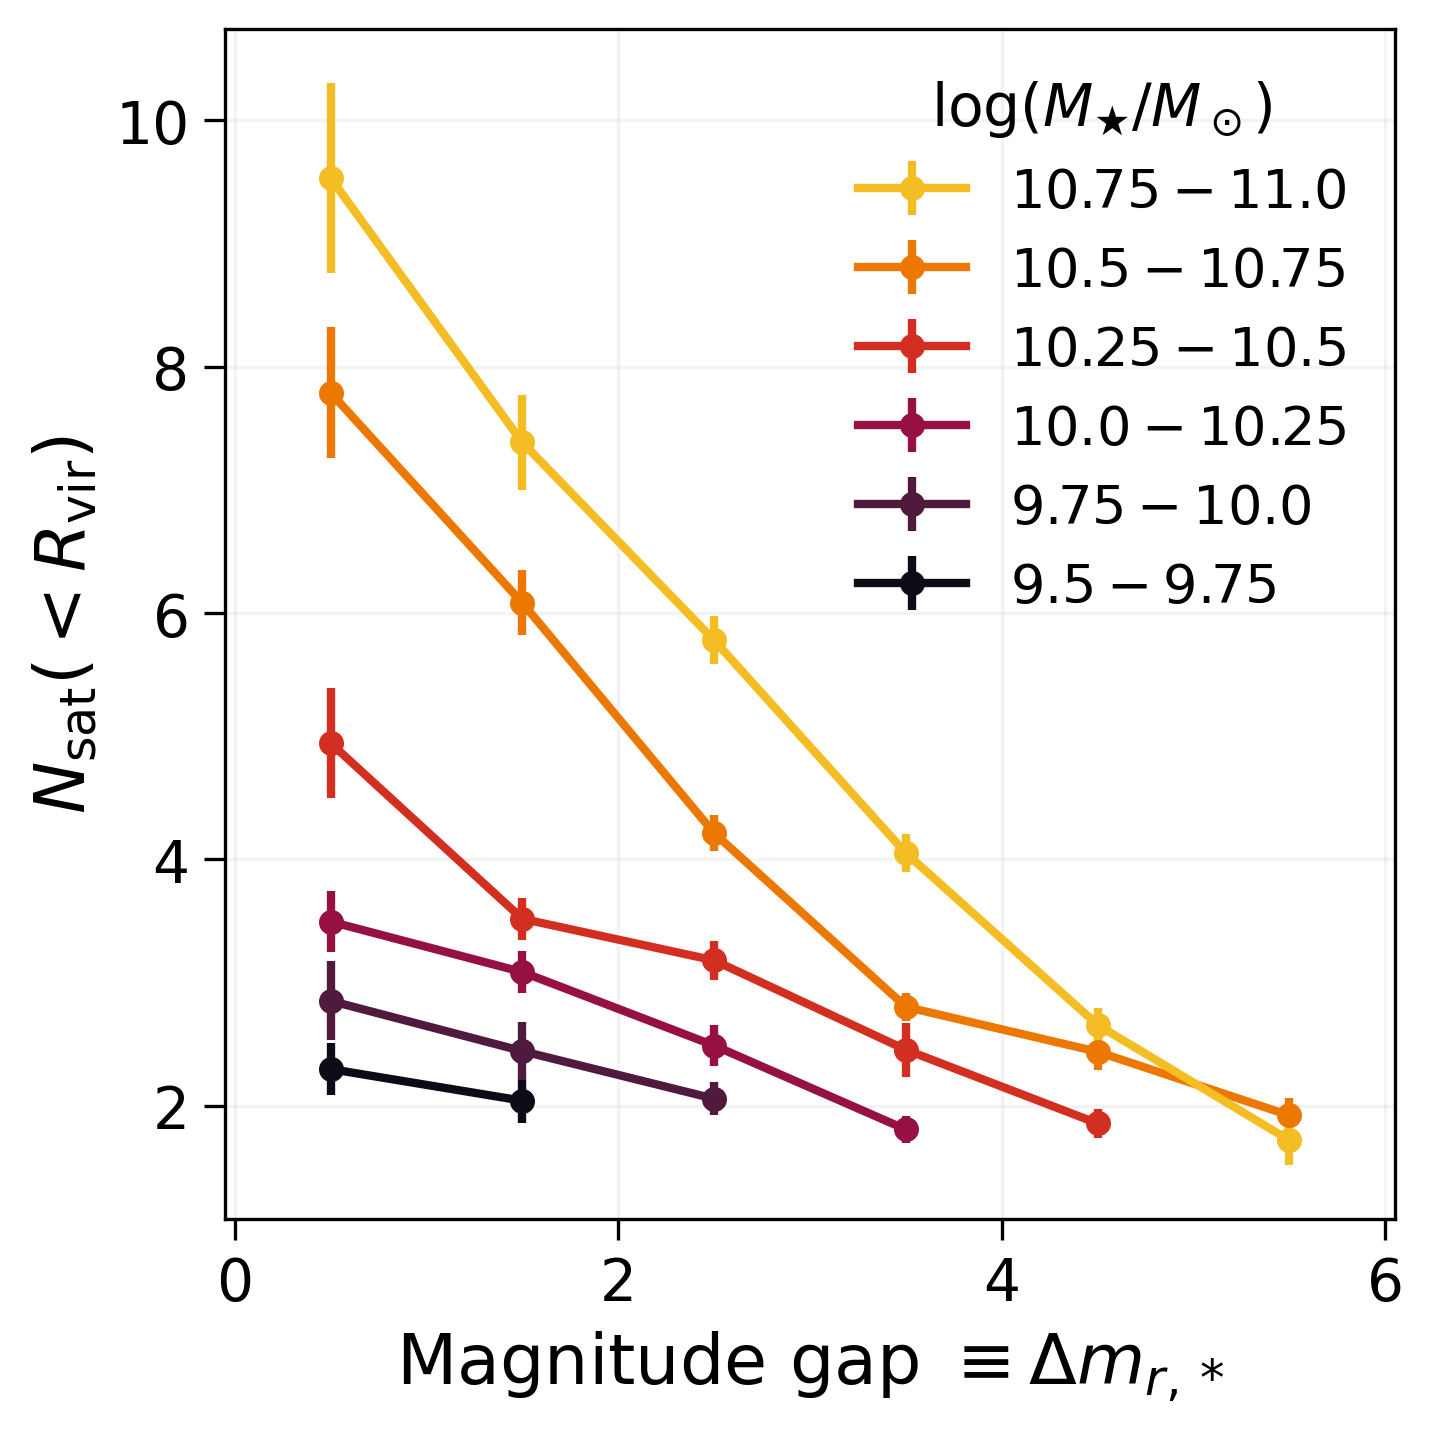

In [86]:
plt.figure(figsize=(5, 5), dpi=300)

dmass = 0.25
mass_bins = np.arange(9.5, 11, dmass)

for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):

    q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    boot_mag_gap = []
    
    magnitude_gap_bins = np.arange(0, 6, 1)
    for j, [mag1, mag2] in enumerate(zip(magnitude_gap_bins, magnitude_gap_bins + 1)):

        q_mag = Query(f"magnitude_gap > {mag1}", f"magnitude_gap < {mag2}")
        number_of_hosts = (q_mag & q_mass).count(hosts_subset)

        if mag2 > (i + 2):
            boot_mag_gap.append(np.full((N_boot,), np.nan))
        else:
            boot_mag_gap.append(
                f(sats_subset, q_mag.filter(hosts_subset), q_mass)
            )


    boot_mag_gap = np.array(boot_mag_gap)
    plt.errorbar(
        magnitude_gap_bins[:len(boot_mag_gap)] + 0.5,# + 0.05*(i-2.5), 
        boot_mag_gap.mean(1), 
        boot_mag_gap.std(1), 
        c=mass2color((m1+m2)/2), 
        markersize=5,
        ls='-',
        lw=2,
        fmt='o', 
        label=f'${m1} - {m2}$'
    )

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=13, framealpha=1, title='log($M_★/M_\odot$)', title_fontsize=14,
)
plt.grid(alpha=0.15)
plt.xlim(-0.05, 6.05)
# plt.ylim(1.5, 13.5)

plt.xlabel(r'Magnitude gap $\equiv \Delta m_{r,*}$')
plt.ylabel(r'$N_{\rm sat}(<R_{\rm vir})$')
plt.tight_layout()

plt.savefig(figures_dir / "satellite_richness-by-magnitude_gap-stellar_mass.pdf")

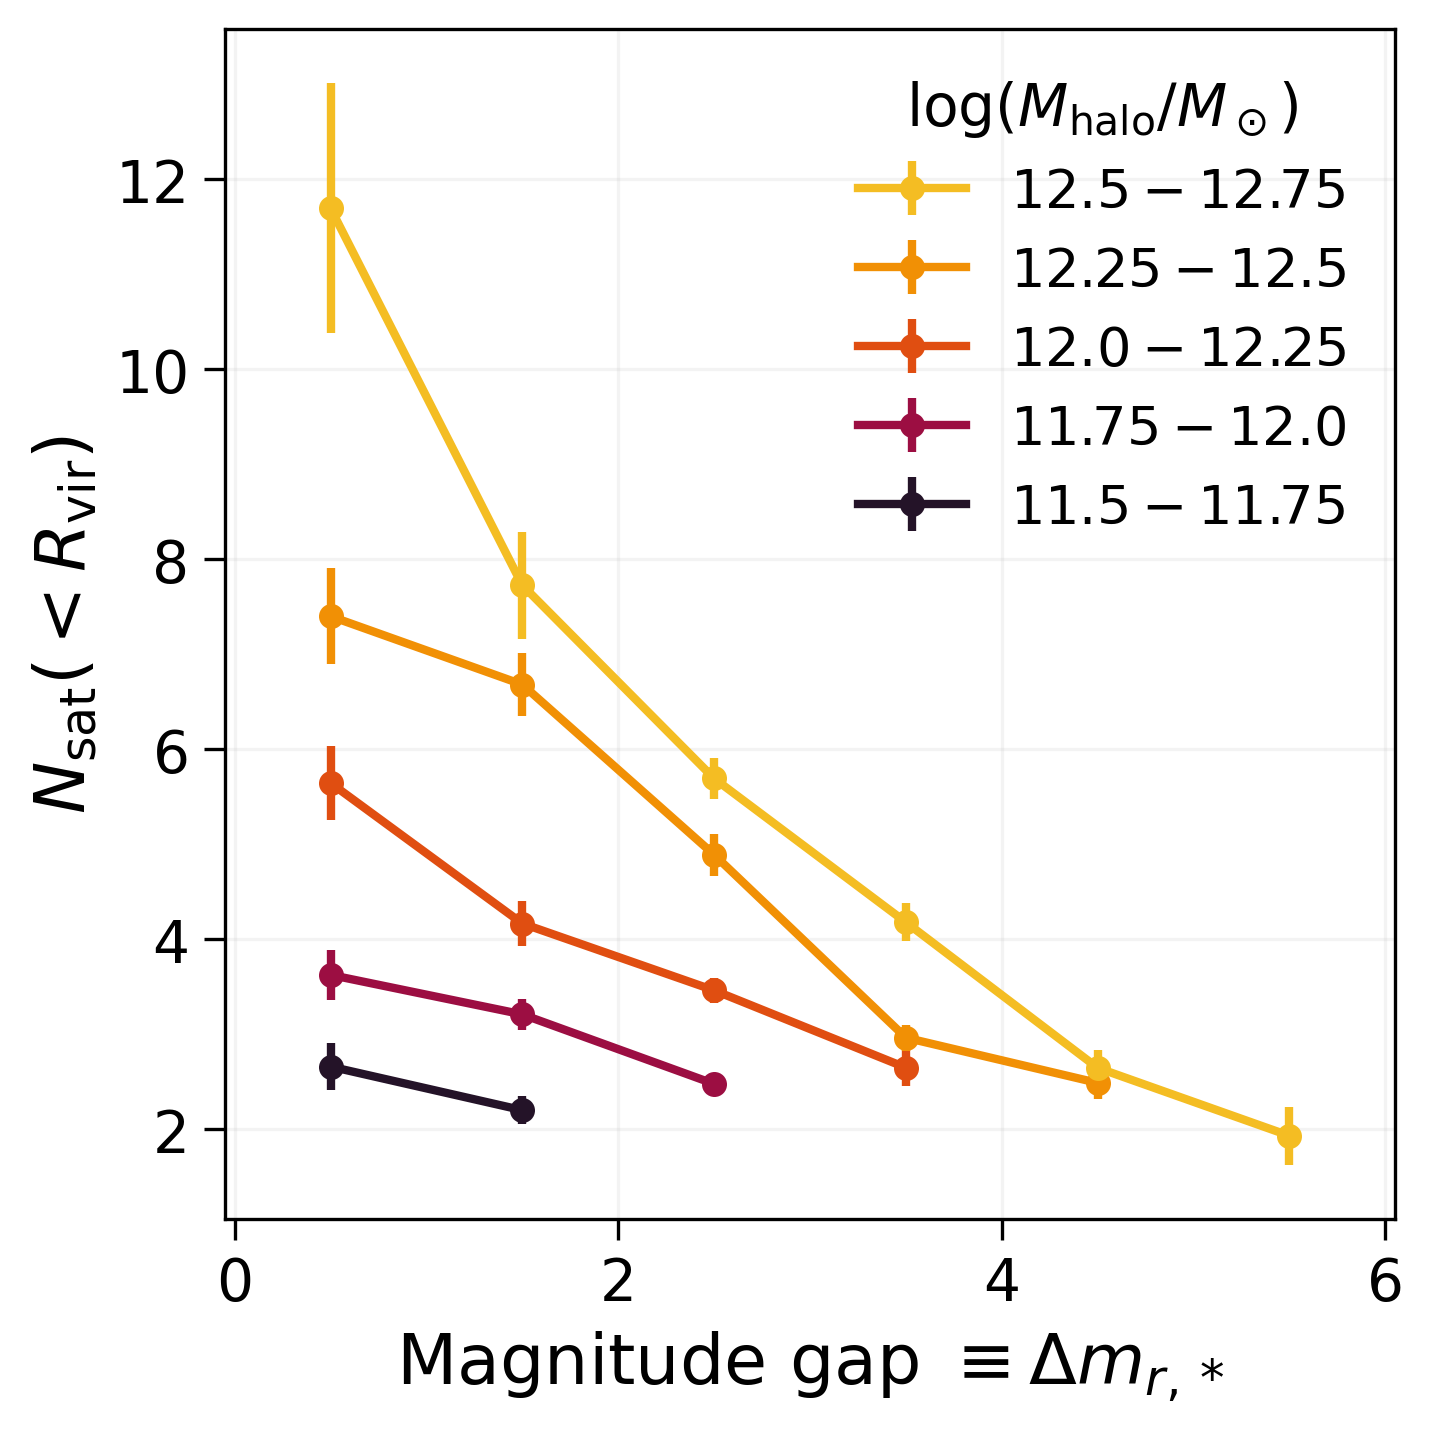

In [87]:
plt.figure(figsize=(5, 5), dpi=300)

dmass = 0.25
mass_bins = np.arange(11.5, 12.75, dmass)

for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):

    q_mass = Query(f"M_halo > {m1}", f"M_halo < {m2}")
    boot_mag_gap = []
    
    magnitude_gap_bins = np.arange(0, 6, 1)
    for j, [mag1, mag2] in enumerate(zip(magnitude_gap_bins, magnitude_gap_bins + 1)):

        q_mag = Query(f"magnitude_gap > {mag1}", f"magnitude_gap < {mag2}")
        number_of_hosts = (q_mag & q_mass).count(hosts_subset)

        if mag2 > (i + 2):
            boot_mag_gap.append(np.full((N_boot,), np.nan))
        else:
            boot_mag_gap.append(
                f(sats_subset, q_mag.filter(hosts_subset), q_mass)
            )


    boot_mag_gap = np.array(boot_mag_gap)
    plt.errorbar(
        magnitude_gap_bins[:len(boot_mag_gap)] + 0.5, 
        boot_mag_gap.mean(1), 
        boot_mag_gap.std(1), 
        c=mass2color(B19.stellar_mass((m1+m2)/2)), 
        markersize=5,
        ls='-',
        lw=2,
        fmt='o', 
        label=f'${m1} - {m2}$'
    )

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=13, framealpha=1, title=r'log($M_{\rm halo}/M_\odot$)', title_fontsize=14,
)
plt.grid(alpha=0.15)
plt.xlim(-0.05, 6.05)
# plt.ylim(1.5, 13.5)

plt.xlabel(r'Magnitude gap $\equiv \Delta m_{r,*}$')
plt.ylabel(r'$N_{\rm sat}(<R_{\rm vir})$')
plt.tight_layout()
plt.savefig(figures_dir / "satellite_richness-by-magnitude_gap-halo_mass.pdf")

## Same as above but using $(0.3-1)\times R_{\rm vir}$ (dashed lines)

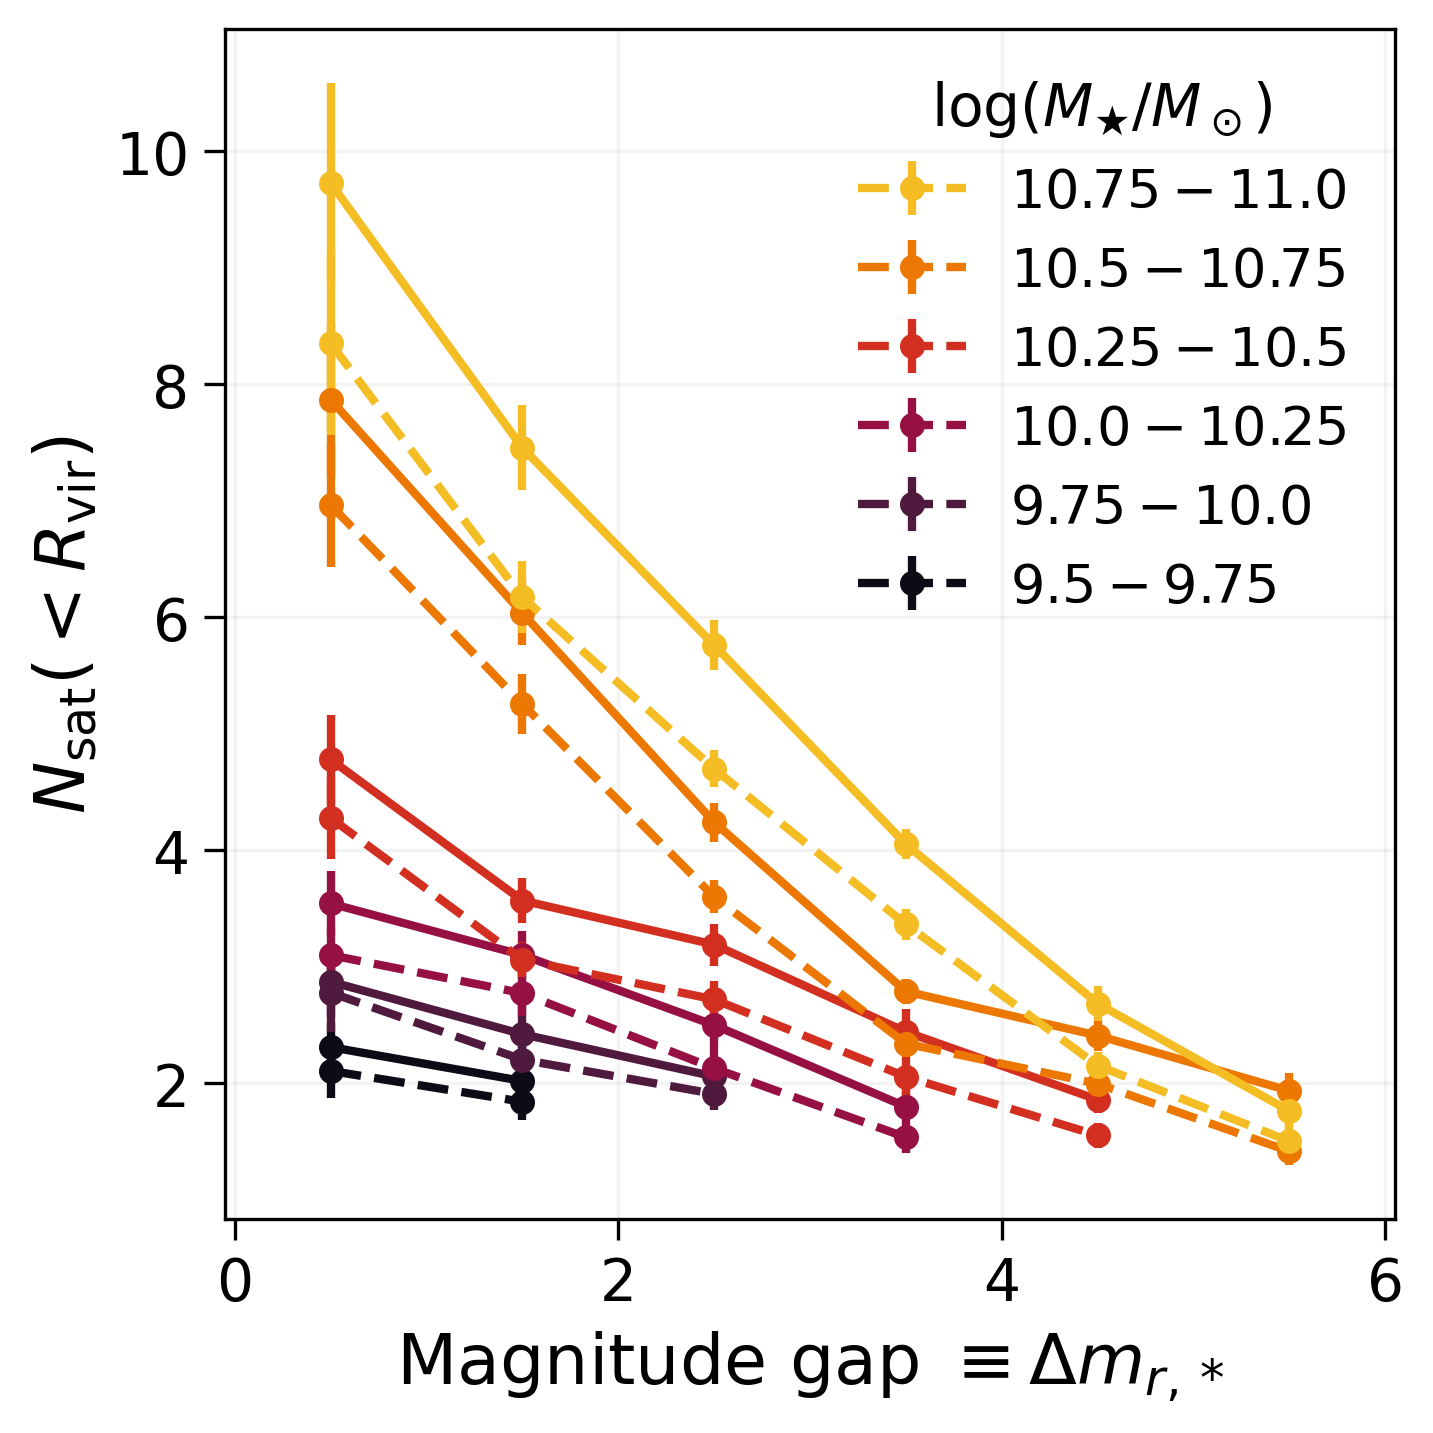

In [56]:
plt.figure(figsize=(5, 5), dpi=300)

dmass = 0.25
mass_bins = np.arange(9.5, 11, dmass)

for i, [m1, m2] in enumerate(zip(mass_bins, mass_bins + dmass)):

    q_mass = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    boot_mag_gap_original = []
    boot_mag_gap_limited = []
    
    magnitude_gap_bins = np.arange(0, 6, 1)
    for j, [mag1, mag2] in enumerate(zip(magnitude_gap_bins, magnitude_gap_bins + 1)):

        q_mag = Query(f"magnitude_gap > {mag1}", f"magnitude_gap < {mag2}")
        number_of_hosts = (q_mag & q_mass).count(hosts_subset)

        if mag2 > (i + 2):
            boot_mag_gap_original.append(np.full((N_boot,), np.nan))
            boot_mag_gap_limited.append(np.full((N_boot,), np.nan))
        else:
            q_sep = Query(f"sep > 0.3*R_vir")
            boot_mag_gap_original.append(
                f(sats_subset, q_mag.filter(hosts_subset), q_mass)
            )
            boot_mag_gap_limited.append(
                f(q_sep.filter(sats_subset), q_mag.filter(hosts_subset), q_mass)
            )


    boot_mag_gap_original = np.array(boot_mag_gap_original)
    boot_mag_gap_limited = np.array(boot_mag_gap_limited)
    
    plt.errorbar(
        magnitude_gap_bins[:len(boot_mag_gap)] + 0.5,# + 0.05*(i-2.5), 
        boot_mag_gap_original.mean(1), 
        boot_mag_gap_original.std(1), 
        c=mass2color((m1+m2)/2), 
        markersize=5,
        ls='-',
        lw=2,
        fmt='o', 
#         label=f'${m1} - {m2}$'
    )

    plt.errorbar(
        magnitude_gap_bins[:len(boot_mag_gap)] + 0.5,# + 0.05*(i-2.5), 
        boot_mag_gap_limited.mean(1), 
        boot_mag_gap_limited.std(1), 
        c=mass2color((m1+m2)/2), 
        markersize=5,
        ls='--',
        lw=2,
        fmt='o', 
        label=f'${m1} - {m2}$'
    )

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize=13, framealpha=1, title='log($M_★/M_\odot$)', title_fontsize=14,
)
plt.grid(alpha=0.15)
plt.xlim(-0.05, 6.05)
# plt.ylim(1.5, 13.5)

plt.xlabel(r'Magnitude gap $\equiv \Delta m_{r,*}$')
plt.ylabel(r'$N_{\rm sat}(<R_{\rm vir})$')
plt.tight_layout()


# (Fig 13) Comparison to simulations

In [65]:
hosts, sats = load_hosts_and_sats()

# impose cuts
hosts = HOST_QUERY.filter(hosts)
sats = (HOST_QUERY & SAT_QUERY).filter(sats)

# isolate hosts and sats
hosts = isolate_hosts(hosts, delta_mass=0.0, delta_z=0.005, delta_d=1.0)
sats = sats[sats.NSAID.isin(hosts.index)].copy()

xSAGA 10.0-11.0: 2.446808 +/- 0.206950
FIRE sphere: 2.497500 +/- 0.066620
FIRE cylinder: 2.690417 +/- 0.236823
Romulus sphere: 2.053551 +/- 0.029326


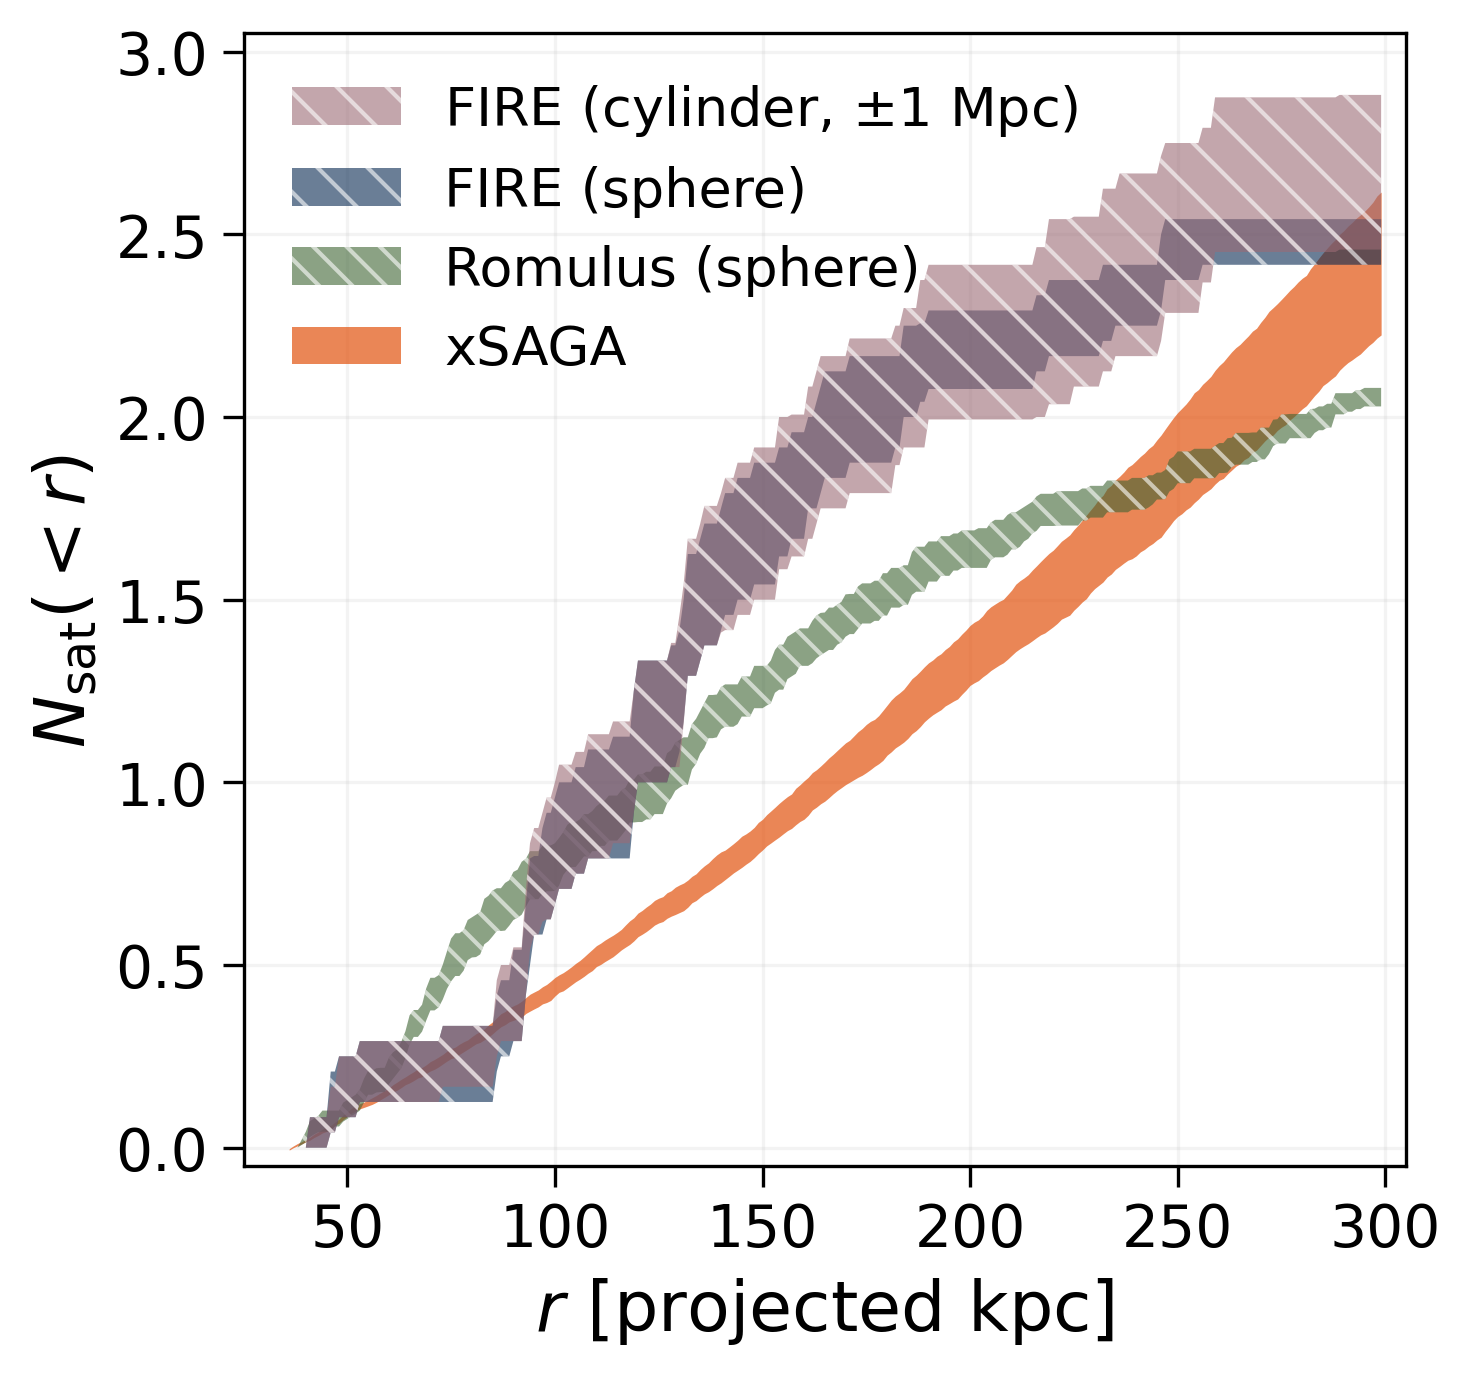

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

N_boot = 30
radial_bins = np.arange(36, 300, 1)
mass_bins = np.arange(10., 11, 1)

# compute profile and correct for each mass bin
for m1, m2 in zip(mass_bins, mass_bins+1):
    q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
    satellite_separations = q.filter(sats).sep.values

    profile_bootstrapped = bootstrap(
        satellite_separations,
        bootfunc=partial(compute_radial_profile, radial_bins=radial_bins),
        bootnum=N_boot,
    )

    profile_bootstrapped = profile_bootstrapped / q.count(hosts)
    
    # corrections
    interloper_profile = compute_interloper_profile(
        q.filter(sats).z_NSA,
        radial_bins,
    )
    
    interloper_profile_bootstrapped = rng.choice(
        interloper_profile, size=N_boot, replace=True
    )

    nonsatellite_profile = compute_nonsatellite_profile(
        hosts.loc[q.filter(sats).NSAID].N_unrelated_lowz, radial_bins
    )

    nonsatellite_profile_bootstrapped = rng.choice(
        nonsatellite_profile, size=N_boot, replace=True
    )

    profile_bootstrapped = (
        profile_bootstrapped / 0.600
        - interloper_profile_bootstrapped
        - nonsatellite_profile_bootstrapped
    )
    
    ax.fill_between(
        radial_bins,
        *np.quantile(profile_bootstrapped, [0.16, 0.84], axis=0),
        color=mass2color((m1 + m2) / 2),
        label=f"xSAGA",
        lw=0,
        alpha=0.7,
        zorder=3,
    )
    print(f'xSAGA {m1}-{m2}: {profile_bootstrapped.mean(0).max() - profile_bootstrapped.mean(0).min():2f} +/- {profile_bootstrapped.std(0)[-1]:2f}')


# Romulus 25
boot_Rom2_profile = np.load(data_dir / 'Romulus/Romulus-spherical.npy')
ax.fill_between(
    radial_bins,
    *np.quantile(boot_Rom2_profile, [0.16, 0.84], axis=0) - boot_Rom2_profile.mean(0).min(),
    lw=0,
    facecolor=cmr.savanna(0.4),
    edgecolor='white',
    alpha=0.6,
    hatch='\\\\\\',
    label="Romulus (sphere)",
    zorder=4,
)

    
# FIRE-2
boot_fire_profile_sphere = np.load(data_dir / 'FIRE/FIRE-isolated_bootstrapped_projected-profile_sphere.npy')
boot_fire_profile_sphere = boot_fire_profile_sphere - boot_fire_profile_sphere.min(1, keepdims=True)
ax.fill_between(
    radial_bins,
    *np.quantile(boot_fire_profile_sphere, [0.16, 0.84], axis=0),
    lw=0,
    facecolor=cmr.lilac(0.2),
    edgecolor='white',
    alpha=0.6,
    hatch='\\\\',
    label="FIRE (sphere)",
    zorder=4,
)

boot_fire_profile_cylinder = np.load(data_dir / 'FIRE/FIRE-isolated_bootstrapped_projected-profile_cylinder1000kpc.npy')
boot_fire_profile_cylinder = boot_fire_profile_cylinder - boot_fire_profile_cylinder.min(1, keepdims=True)
ax.fill_between(
    radial_bins,
    *np.quantile(boot_fire_profile_cylinder, [0.16, 0.84], axis=0),
    lw=0,
    facecolor=cmr.lilac(0.6),
    edgecolor='white',
    alpha=0.6,
    hatch='\\\\',
    label="FIRE (cylinder, $\\pm$1 Mpc)",
    zorder=4,
)

ax.set_xlabel("$r$ [projected kpc]")
ax.set_ylabel(r"$N_{\rm sat}(<r)$")

print(f'FIRE sphere: {boot_fire_profile_sphere.max(1).mean():2f} +/- {boot_fire_profile_sphere.max(1).std():2f}')
print(f'FIRE cylinder: {boot_fire_profile_cylinder.max(1).mean():2f} +/- {boot_fire_profile_cylinder.max(1).std():2f}')
print(f'Romulus sphere: {boot_Rom2_profile.max(1).mean():2f} +/- {boot_Rom2_profile.max(1).std():2f}')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=13)
ax.grid(alpha=0.15)
ax.set_xlim(25, 305)
ax.set_ylim(-0.05, 3.05)

plt.savefig(figures_dir / "compare-sims.pdf")

# (Fig 19 --- B.1) Bootstrap resampling

In [93]:
from easyquery import QueryMaker
from radial_profiles import *

In [94]:
hosts, sats = load_hosts_and_sats()

# impose cuts
hosts = HOST_QUERY.filter(hosts)
sats = (HOST_QUERY & SAT_QUERY).filter(sats)

# isolate hosts and sats
hosts = isolate_hosts(hosts, delta_mass=0.0, delta_z=0.005, delta_d=1.0)
sats = sats[sats.NSAID.isin(hosts.index)].copy()

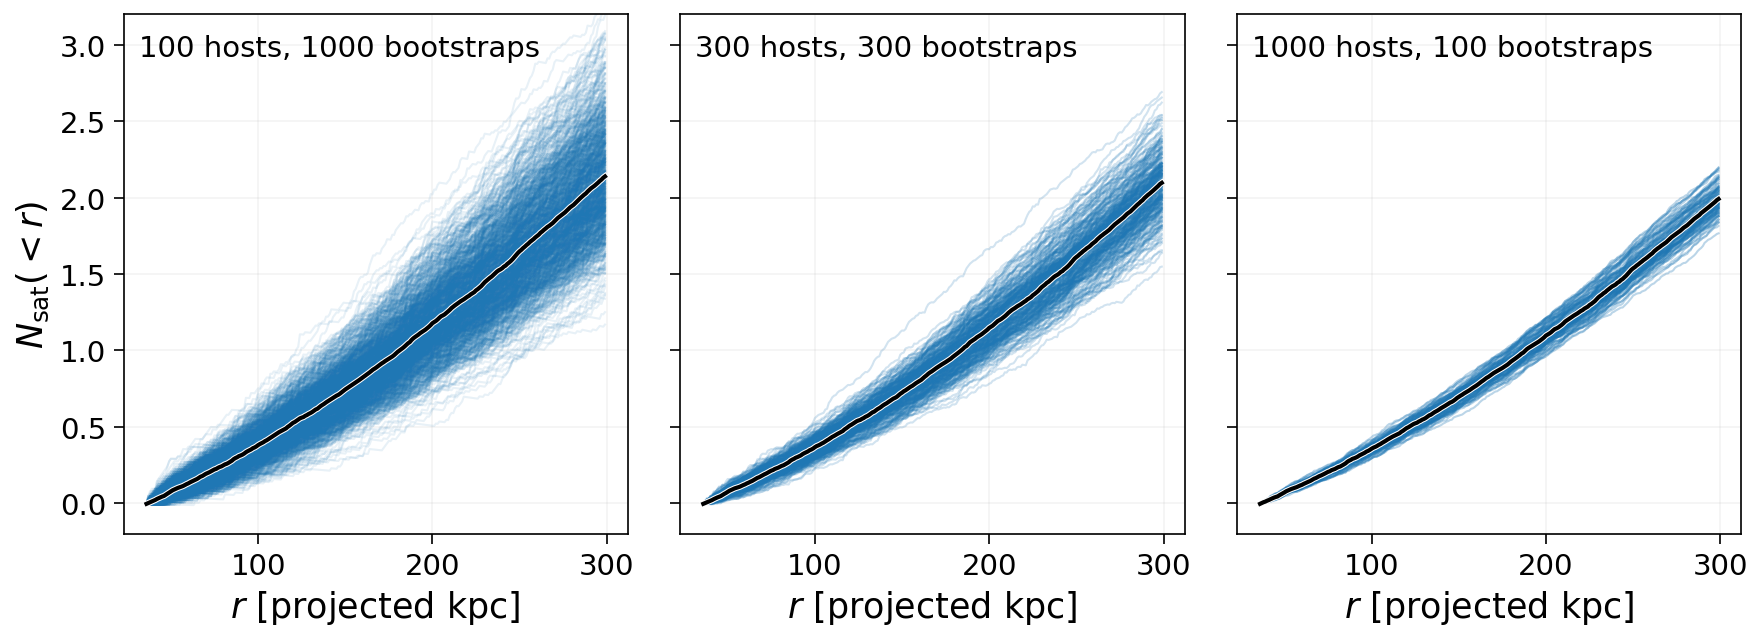

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), dpi=150, sharey=True)


radial_bins = np.arange(36, 300, 1)
m1, m2 = 10.0, 11

# compute profile and correct for each mass bin
q = Query(f"mass_GSE > {m1}", f"mass_GSE < {m2}")
satellite_separations = q.filter(sats).sep.values

for a, (ax, N_iterations, N_sample) in enumerate(zip(axes.flat, [1000, 300, 100], [100, 300, 1000])):

    boot_profile = np.empty((N_iterations, len(radial_bins)))

    for i in range(N_iterations):

        hosts_subset = hosts.sample(N_sample, replace=True)
        sats_subset = QueryMaker.isin('NSAID', hosts_subset.index).filter(sats)

        profile = compute_radial_profile(sats_subset.sep.values, radial_bins)

        profile = profile / N_sample

        # corrections
        interloper_profile = compute_interloper_profile(
            sats_subset.z_NSA,
            radial_bins,
        ).mean(0)

        nonsatellite_profile = compute_nonsatellite_profile(
            hosts_subset.loc[sats_subset.NSAID].N_unrelated_lowz, radial_bins
        ).mean(0)

        profile = (
            profile / 0.600
            - interloper_profile
            - nonsatellite_profile
        )

        boot_profile[i] = profile

        ax.plot(
            radial_bins,
            profile,
            color='C0',
            lw=1,
            alpha=0.1*(a + 1),
        )

    ax.plot(radial_bins, boot_profile.mean(0), color='white', lw=3, alpha=1)
    ax.plot(radial_bins, boot_profile.mean(0), color='k', lw=2, alpha=1)

    ax.grid(alpha=0.15)
    ax.set_ylim(-0.2, 3.2)
    ax.text(0.03, 0.92, f'{N_sample} hosts, {N_iterations} bootstraps', transform=ax.transAxes);

    ax.set_xlabel("$r$ [projected kpc]")
axes.flat[0].set_ylabel(r"$N_{\rm sat}(<r)$")

fig.tight_layout()

plt.savefig(figures_dir / "bootstrap-scatter.pdf")